### <center>«Модель прогнозирования стоимости жилья для агентства недвижимости»

### <center>"Model for predicting housing prices for a real estate agency"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
%matplotlib inline
# import plotly
# import plotly.express as px
# import plotly.graph_objs as go
# from plotly.subplots import make_subplots
import json

import category_encoders as ce
from sklearn.preprocessing  import MinMaxScaler, StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import tree #модели деревьев решения
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

import torch
# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

import pickle
import joblib
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

c:\Users\USER\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\USER\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
c:\Users\USER\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


c:\Users\USER\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## <center> 1. Cleaning and Exploratory Data Analysis

Let's read the data from the file and look at the dataset.

In [2]:
data_prop = pd.read_csv('data.csv', sep=',')

In [3]:
data = data_prop.copy()
data.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [5]:
print('The initial dataset consists of {} features and {} objects.'.format(data.shape[1], data.shape[0]))
print('Number of complete duplicates in the dataset: {:.0f}'.format(data.duplicated().sum()))
tabela = pd.DataFrame({
    'Unique':data.nunique(),
    'Null':data.isna().sum(),
    'NullPercent':round(data.isnull().mean()*100), #sum() / len(df),
    'Types':data.dtypes.values
}).reset_index().rename(columns={'index': 'Column_name'})
display(tabela.sort_values(by='Unique', ascending=True, ignore_index=True))

The initial dataset consists of 18 features and 377185 objects.
Number of complete duplicates in the dataset: 50


,Column_name,Unique,Null,NullPercent,Types
0,private pool,1,373004,99.0,object
1,PrivatePool,2,336874,89.0,object
2,state,39,0,0.0,object
3,status,159,39918,11.0,object
4,baths,229,106338,28.0,object
5,stories,348,150715,40.0,object
6,beds,1184,91282,24.0,object
7,propertyType,1280,34733,9.0,object
8,fireplace,1653,274070,73.0,object
9,city,2026,34,0.0,object


Remove complete duplicates from the dataset.

In [6]:
data = data.drop_duplicates()
data.duplicated().sum()

0

Let's create functions in advance to identify outliers in features.

In [7]:
# метод межквартильного размаха (метод Тьюки)
# interquartile range method (Tukey's method)
def outliers_iqr(data, feature, log_scale=True):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [8]:
# метод z-отклонений (метод, основанный на правиле трёх сигм - метод сигм)
# z-deviation method (sigma method)
def outliers_z_score(data, feature, log_scale=True):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

Оба метода (метод межквартильного размаха - метод Тьюки и метод z-отклонений - sigma method) разработаны для данных, распределённых приблизительно нормально.

Both methods (interquartile range method - Tukey's method and z-deviation method - sigma method) are developed for data that are approximately normally distributed.

In [9]:
# создадим списки для числовых, категориальных и бинарных переменных (бинарные переменные являются подгруппой категориальных)
num_cols = []
cat_cols = []
bin_cols = []

<center>Let's carry out a sequential analysis of each feature.

У нас в датасете есть два признака ("PrivatePool" - "private pool", "MlsId" - "mls-id"), каждый из которых имеет дубликат. Объединим дубликаты в один признак.

We have two features in the dataset ("PrivatePool" - "private pool", "MlsId" - "mls-id"), each of which has a duplicate. Let's combine the duplicates into one feature.

In [10]:
data = data.fillna(value = {'PrivatePool': data['private pool'], 'MlsId': data['mls-id']})
data = data.drop(['private pool', 'mls-id'], axis=1)
data.head(3)

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,MlsId,target
0,Active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,611019,"$418,000"
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,201916904,"$310,000"
2,for sale,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,yes,FR19221027,"$2,895,000"


### 1. Рассмотрим признак "PrivatePool" - наличие собственного бассейна

### 1. Consider the feature "PrivatePool" - having a private pool

In [11]:
data['PrivatePool'].isnull().sum()

332644

Данный столбец состоит из одного значения - 'Yes' и 332644 пропуска. Предположим, что пропуск означает отсутствие бассейна, тогда заменим все пустые ячейки на нули (0), а 'Yes' на единицы (1).

This column consists of one value - 'Yes' and 332644 blanks. Let's assume that a blank means there is no pool, then we replace all empty cells with zeros (0), and 'Yes' with ones (1).

In [12]:
data['PrivatePool'] = data['PrivatePool'].replace({'Yes': 1, 'yes': 1}, regex=True)
data = data.fillna(value = {'PrivatePool': 0})

Text(0.5, 1.0, 'Distribution of the number of presence (1) and absence (0) of the pool')

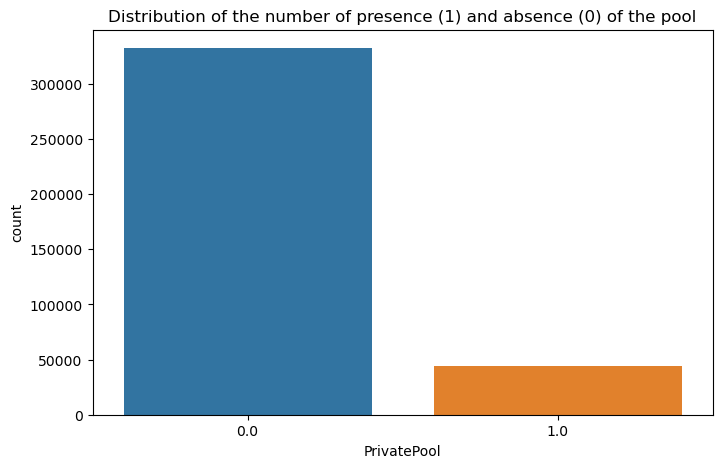

In [13]:
# Посмотрим на гистограмму распределения признака "PrivatePool".
# Let's look at the histogram of the distribution of the "PrivatePool" feature.
fig = plt.figure(figsize=(8, 5))
axes = sns.countplot(x='PrivatePool', data = data);
axes.set_title('Distribution of the number of presence (1) and absence (0) of the pool', fontsize=12)

In [14]:
data['PrivatePool'].value_counts(normalize=True, ascending=False)

0.0    0.882029
1.0    0.117971
Name: PrivatePool, dtype: float64

In [15]:
bin_cols.append('PrivatePool')

### 2. Рассмотрим признак "MlsId" - идентификатор MLS (Multiple Listing Service, система мультилистинга)

### 2. Consider the feature "MlsId" - Multiple Listing Service

In [16]:
print('Proportion of gaps in the "MlsId" feature: {:.2f}%.'.format(data['MlsId'].isnull().mean()*100)) #Доля пропусков в признаке "MlsId"
print('Number of unique values in the "MlsId" feature: {:.0f}.'.format(data['MlsId'].nunique())) #Количество уникальных значений в признаке "MlsId"

Proportion of gaps in the "MlsId" feature: 11.12%.
Number of unique values in the "MlsId" feature: 249012.


Признак 'MlsId'- идентификатор MLS (Multiple Listing Service, система мультилистинга) является уникальным для каждого объекта и не имеет статистической значимости. Избавимся от данного признака (удалим признак 'MlsId'), т.к. выделить из этого признака какие-то общие черты не представляется возможным.

The feature 'MlsId' - MLS identifier (Multiple Listing Service, multi-listing system) is unique for each object and has no statistical significance. Let's get rid of this attribute (remove the feature 'MlsId'), because It is not possible to identify any common features from this characteristic.

In [17]:
data = data.drop(['MlsId'], axis=1)

### 3. Рассмотрим признак "status" - статус продажи объекта недвижимости

### 3. Let's consider the feature "status" - the status of the sale of the property

In [18]:
print('Proportion of gaps in the "status" feature: {:.2f}%.'.format(data['status'].isnull().mean()*100)) #Доля пропусков в признаке "status"
print('Number of unique values in the "status" feature: {:.0f}.'.format(data['status'].nunique())) #Количество уникальных значений в признаке "status"

Proportion of gaps in the "status" feature: 10.58%.
Number of unique values in the "status" feature: 159.


In [19]:
data = data.fillna(value = {'status': '0'})
data['status'] = data['status'].apply(lambda x: 'Sold' if ('Sold' in x) or ('sold' in x) else 'In progress')
data['status'].unique()

array(['In progress', 'Sold'], dtype=object)

Text(0.5, 1.0, 'Histogram of the distribution of the "status" feature')

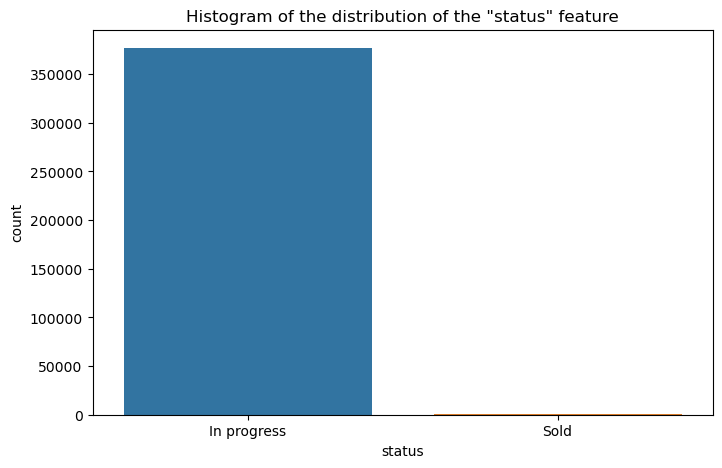

In [20]:
# Посмотрим на гистограмму распределения признака "status".
# Let's look at the histogram of the distribution of the "status" feature.
fig = plt.figure(figsize=(8, 5))
axes = sns.countplot(x='status', data = data);
axes.set_title('Histogram of the distribution of the "status" feature', fontsize=12)

In [21]:
print('Shares by object types in the "status" feature % \n{}'.format(round(data['status'].value_counts(normalize=True)*100, 2))) #Доли по типам объектов в признаке "status"

Shares by object types in the "status" feature % 
In progress    99.92
Sold            0.08
Name: status, dtype: float64


In [22]:
# Осуществим проверку на неинформативность следующих признаков: "PrivatePool", "status"
# список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in data[['PrivatePool', 'status']].columns:
    #наибольшая относительная частота в признаке
    top_freq = data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = data[col].nunique() / data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений - признак неинформативный')
    else:
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений - признак информативный')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений - признак неинформативный')
    else:
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений - признак информативный')

PrivatePool: 88.2% одинаковых значений - признак информативный
PrivatePool: 0.0% уникальных значений - признак информативный
status: 99.92% одинаковых значений - признак неинформативный
status: 0.0% уникальных значений - признак информативный


В результате мы имеем очень сильно несбалансированный бинарный признак. Удалим его.

As a result, we have a very unbalanced binary feature. Let's delete it.

In [23]:
data = data.drop('status', axis=1)

### 4. "propertyType" feature

In [24]:
print('Proportion of gaps in the "propertyType" feature: {:.2f}%.'.format(data['propertyType'].isnull().mean()*100)) #Доля пропусков в признаке "propertyType"
print('Number of unique values in the "propertyType" feature: {:.0f}.'.format(data['propertyType'].nunique())) #Количество уникальных значений в признаке "propertyType"

Proportion of gaps in the "propertyType" feature: 9.21%.
Number of unique values in the "propertyType" feature: 1280.


In [25]:
data['propertyType'].unique()

array(['Single Family Home', 'single-family home', 'lot/land', ...,
       'Cabin/Lodge, Contemporary, Converted Barn, Cottage, Loft with Bedrooms, Log Home, Post & Beam',
       'Lake House, Single Detached, Tudor',
       'Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit'],
      dtype=object)

Заполним пропуски значением 'other', означающее отсутствие информации о типе нежвижимости.

Let's fill in the blanks with the value 'other', which means there is no information about the type of property.

In [26]:
data = data.fillna(value={'propertyType': 'other'})

Обработаем признак на предмет сокращений и идентичности находящейся в нем информации, т.е. приведём к единообразию некоторые значения.

Let's process the feature for abbreviations and the identity of the information contained in it, ie we will bring some meanings to uniformity.

In [27]:
data['manufactured home'] = data['propertyType'].apply(lambda x: 'manufactured home' if ('manuf' in x) or ('Manuf' in x) or ('Mob' in x) or 
                                                    ('Single Wide' in x) else x)
data['Single-Family home'] = data['manufactured home'].apply(lambda x: 'Single-Family home' if ('Single Family' in x) or ('Single Detached' in x) 
                                                      or ('single-family home' in x) or ('SingleFamilyResidence' in x) or ('Detach' in x) else x) 
data['apartment'] = data['Single-Family home'].apply(lambda x: 'apartment' if ('apart' in x) or ('Apart' in x) else x) 
data['bungalow'] = data['apartment'].apply(lambda x: 'bungalow' if ('Bung' in x) else x)
data['CoNdo/TownHouse'] = data['bungalow'].apply(lambda x: 'CoNdo/TownHouse' if ('Condo/Townh' in x) else x) 
data['Condo'] = data['CoNdo/TownHouse'].apply(lambda x: 'Condo' if ('Condo' in x) or ('condo' in x) else x) 
data['townhouse'] = data['Condo'].apply(lambda x: 'townhouse' if ('Townh' in x) or ('townh' in x) else x)
data['Cooperative'] = data['townhouse'].apply(lambda x: 'Cooperative' if ('Coop' in x) or ('Co-op' in x) or ('coop' in x) else x) 
data['colonial home'] = data['Cooperative'].apply(lambda x: 'colonial home' if ('Colon' in x) else x) 
data['contemporary'] = data['colonial home'].apply(lambda x: 'contemporary' if ('Contemp' in x) else x)
data['cape cod'] = data['contemporary'].apply(lambda x: 'cape cod' if ('Cape' in x) else x)
data['cottage'] = data['cape cod'].apply(lambda x: 'cottage' if ('Cottage' in x) else x)
data['craftsman'] = data['cottage'].apply(lambda x: 'craftsman' if ('Craft' in x) else x)
data['farmhouse'] = data['craftsman'].apply(lambda x: 'farmhouse' if ('Farm' in x) else x)
data['french country'] = data['farmhouse'].apply(lambda x: 'french country' if ('French' in x) else x)
data['penthouse'] = data['french country'].apply(lambda x: 'penthouse' if ('Penthouse' in x) else x)
data['mediterranean'] = data['penthouse'].apply(lambda x: 'mediterranean' if ('Medit' in x) else x)
data['midcentury modern'] = data['mediterranean'].apply(lambda x: 'midcentury modern' if ('Mid-C' in x) or ('Mid C' in x) else x)
data['high-rise'] = data['midcentury modern'].apply(lambda x: 'high-rise' if ('High R' in x) or ('High-R' in x) or ('Hi-R' in x) else x)
data['low-rise'] = data['high-rise'].apply(lambda x: 'low-rise' if ('Low R' in x) or ('Low-R' in x) else x)
data['mid-rise'] = data['low-rise'].apply(lambda x: 'mid-rise' if ('Mid R' in x) or ('Mid-R' in x) or ('Mid-L' in x) else x)
data['ranch'] = data['mid-rise'].apply(lambda x: 'ranch' if ('Ranch' in x) else x)
data['split-level'] = data['ranch'].apply(lambda x: 'split-level' if ('Split' in x) or ('Bilevel' in x) or ('Bi-Level' in x) else x)
data['tudor'] = data['split-level'].apply(lambda x: 'tudor' if ('Tudor' in x) else x)
data['victorian'] = data['tudor'].apply(lambda x: 'victorian' if ('Victor' in x) or ('Queen' in x) else x)
data['european houses style'] = data['victorian'].apply(lambda x: 'european houses style' if ('Europe' in x) else x)
data['log home'] = data['european houses style'].apply(lambda x: 'log home' if ('Log' in x) else x)
data['traditional'] = data['log home'].apply(lambda x: 'traditional' if ('radit' in x) or ('eorgi' in x) else x)
data['Multi-Level'] = data['traditional'].apply(lambda x: 'Multi-Level' if ('Multi-L' in x) or ('Floor' in x) else x)
data['Multi Family Home'] = data['Multi-Level'].apply(lambda x: 'Multi Family Home' if ('Multi-F' in x) or ('Multi F' in x) or('multi-family' in x)
                                                                   or ('Multiple Occupancy' in x) or ('Multiplex' in x) or ('Multi Generational' in x) else x)
data['lot/land'] = data['Multi Family Home'].apply(lambda x: 'lot/land' if (x == 'Land') else x)

data['duplex'] = data['lot/land'].apply(lambda x: 'duplex' if ('Duplex' in x) else x)

In [28]:
data['duplex'].value_counts(normalize=True, ascending=False).cumsum().head(11)

Single-Family home    0.511276
Condo                 0.625174
other                 0.717271
lot/land              0.800689
townhouse             0.849945
Multi Family Home     0.882870
CoNdo/TownHouse       0.905445
traditional           0.923598
Cooperative           0.933780
contemporary          0.943537
manufactured home     0.953062
Name: duplex, dtype: float64

In [29]:
# применим метод уменьшения количества уникальных категорий, оставим 10 наиболее часто встречающихся категорий
# apply the method of reducing the number of unique categories, leaving the 10 most common categories
popular_ptypes =data['duplex'].value_counts().nlargest(11).index # nlargest(11) because the list of categories already contains the category "other" - nlargest(11) потому-что в перечне категорий уже присутствует категория "other"
print('11 most common categories in the "propertyType" feature, including "other" categories: {}.'.format(list(popular_ptypes)))
data['propertyType'] = data['duplex'].apply(lambda x: x if x in popular_ptypes else 'other')
print('Names of unique categories in the "propertyType" feature: {}.'.format(data['propertyType'].unique()))
print('Number of unique categories in the "propertyType" feature, including "other" categories: {:.0f}.'.format(data['propertyType'].nunique()))

11 most common categories in the "propertyType" feature, including "other" categories: ['Single-Family home', 'Condo', 'other', 'lot/land', 'townhouse', 'Multi Family Home', 'CoNdo/TownHouse', 'traditional', 'Cooperative', 'contemporary', 'manufactured home'].
Names of unique categories in the "propertyType" feature: ['Single-Family home' 'lot/land' 'townhouse' 'other' 'Cooperative'
 'Multi Family Home' 'Condo' 'CoNdo/TownHouse' 'manufactured home'
 'contemporary' 'traditional'].
Number of unique categories in the "propertyType" feature, including "other" categories: 11.


In [30]:
data['propertyType'].value_counts(normalize=True, ascending=False).cumsum().head(11)

Single-Family home    0.511276
other                 0.650311
Condo                 0.764209
lot/land              0.847628
townhouse             0.896883
Multi Family Home     0.929808
CoNdo/TownHouse       0.952383
traditional           0.970536
Cooperative           0.980718
contemporary          0.990476
manufactured home     1.000000
Name: propertyType, dtype: float64

In [31]:
list_propertyType = list(data.columns)[14:]
list_propertyType

['manufactured home',
 'Single-Family home',
 'apartment',
 'bungalow',
 'CoNdo/TownHouse',
 'Condo',
 'townhouse',
 'Cooperative',
 'colonial home',
 'contemporary',
 'cape cod',
 'cottage',
 'craftsman',
 'farmhouse',
 'french country',
 'penthouse',
 'mediterranean',
 'midcentury modern',
 'high-rise',
 'low-rise',
 'mid-rise',
 'ranch',
 'split-level',
 'tudor',
 'victorian',
 'european houses style',
 'log home',
 'traditional',
 'Multi-Level',
 'Multi Family Home',
 'lot/land',
 'duplex']

In [32]:
data.head(1)

,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,...,split-level,tudor,victorian,european houses style,log home,traditional,Multi-Level,Multi Family Home,lot/land,duplex
0,Single-Family home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,...,Single-Family home,Single-Family home,Single-Family home,Single-Family home,Single-Family home,Single-Family home,Single-Family home,Single-Family home,Single-Family home,Single-Family home


In [33]:
# Удалим лишние признаки, созданные в результате обработки признака "propertyType"
# Let's remove unnecessary features created as a result of processing the "propertyType" feature
data = data.drop(list_propertyType, axis=1)

In [34]:
cat_cols.append('propertyType')

### 5. "street" feature

In [35]:
print('Proportion of gaps in the "street" feature: {:.2f}%.'.format(data['street'].isnull().mean()*100)) #Доля пропусков в признаке "street"
print('Number of gaps in the "street" feature: {:.0f}.'.format(data['street'].isnull().sum())) # Количество пропусков в признаке "street"
print('Number of unique values in the "street" feature: {:.0f}.'.format(data['street'].nunique())) #Количество уникальных значений в признаке "street"

Proportion of gaps in the "street" feature: 0.00%.
Number of gaps in the "street" feature: 2.
Number of unique values in the "street" feature: 337076.


In [36]:
data['street'].value_counts(normalize=True, ascending=False).cumsum().head(10)

Address Not Disclosed    0.001782
Undisclosed Address      0.003153
(undisclosed Address)    0.004190
Address Not Available    0.004654
Unknown Address          0.004844
2103 E State Hwy 21      0.004996
11305 Gulf Fwy           0.005139
17030 Youngblood Rd.     0.005240
NE 58th Cir              0.005330
9470 Lancaster Rd. SW    0.005415
Name: street, dtype: float64

Признак 'street' является уникальным для каждого объекта и не имеет статистической значимости. Избавимся от данного признака (удалим признак 'street'),  т.к. выделить из этого признака какие-то общие черты, например, подтипы улиц не представляется возможным. 

In [37]:
data = data.drop(['street'], axis=1)

### 6. "baths" feature

In [38]:
print('Proportion of gaps in the "baths" feature: {:.2f}%.'.format(data['baths'].isnull().mean()*100)) #Доля пропусков в признаке "baths"
print('Number of gaps in the "baths" feature: {:.0f}.'.format(data['baths'].isnull().sum())) # Количество пропусков в признаке "baths"
print('Number of unique values in the "baths" feature: {:.0f}.'.format(data['baths'].nunique())) #Количество уникальных значений в признаке "baths"

Proportion of gaps in the "baths" feature: 28.19%.
Number of gaps in the "baths" feature: 106308.
Number of unique values in the "baths" feature: 229.


In [39]:
# Посмотрим на уникальные значения.
# Let's look at the unique values.
data['baths'].unique()

array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5',
       '1,000', '7 Baths', '2.0', '3.0', 'Bathrooms: 1', '4.0',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5', '6 Baths',
       'Bathrooms: 4', '3 ba', '5', '2,500', '5.5 Baths', '1.0',
       '5 Baths', '1.5', '4', '~', '2.5', '4,000', '3.5 Baths', '2,000',
       '3,000', '8.0', '1 ba', '3.5 ba', '0', '5.0', '1,500', '7.0',
       '1,250', '9 Baths', '2,250', '6.0', '12 Baths', '5.5', '3,500',
       '1.5 Baths', '2,750', 'Bathrooms: 6', '4.5 Baths', '750', '5.5+',
       '6', '10 Baths', '6 ba', 'Bathrooms: 19', '10.0', '1.5 ba', '4 ba',
       '12 ba', '2.5+', '8', '7.5+', 'Bathrooms: 10', '0 / 0', 'Sq. Ft. ',
       '5 ba', '4.5+', '18 Baths', '-- baths', 'Bathrooms: 7', '7', '18',
       '3.5+', '1.5+', '11 Baths', '5,000', '1.75 Baths', '9', '12.0',
       '1.1 Baths', '6.5', 'Bathrooms: 8', '10', '19 Baths',
       'Bathrooms: 9', '16 B

In [40]:
# посмотрим на данные в признаке, которые не содержат цифр
# Let's look at the data in the feature that does not contain numbers
data['baths'][data['baths'].str.contains(r'\d+', regex=True) != True].unique()

array([nan, '~', 'Sq. Ft. ', '-- baths', '—', 'Bathrooms: SemiMod'],
      dtype=object)

In [41]:
# присвоим значение "1000" данным в признаке, которые не содержат цифр
# assign the value "1000" to data in the feature that does not contain numbers
data['baths'] = data['baths'].fillna('1000')
data['baths'] = data['baths'].apply(lambda x: '1000' if (x=='-- baths') | (x=='—') | (x=='Sq. Ft. ') | (x=='~') | (x=='Bathrooms: SemiMod') else x)

In [42]:
pattern = re.compile('\d+')
data['baths_cleared'] = data['baths'].apply(lambda x: int(pattern.findall(x)[0]))
data.baths_cleared.unique()

array([   3,    2,    8, 1000,    1,    4,    5,    7,    6,    0,    9,
         12,  750,   10,   19,   18,   11,   16,   13,   14,   17,  241,
         20,   40,   24,   22,   32,   27,   26,   15,   35,   29,  116,
         21,   76,   23,   43,   34,   55,   25,   44,   41,   36,   30,
         28,   64,   39,   42,   60,   68], dtype=int64)

In [43]:
print('Number of unique values after preprocessing of the "baths" feature: {:.0f}.'.format(data['baths_cleared'].nunique())) #Количество уникальных значений после предобработки признака "baths"

Number of unique values after preprocessing of the "baths" feature: 50.


In [44]:
data['baths_cleared'].value_counts(normalize=True, ascending=False).head()

2       0.317687
1000    0.285861
3       0.193204
4       0.073974
1       0.066822
Name: baths_cleared, dtype: float64

Разделим количество ванных комнат на диапазоны, а отсутствие значения, в т.ч. значения больше 100 закодируем категорией 'no_data'.

Let's divide the number of bathrooms into ranges, and the lack of value, incl. We'll make values greater than 100 the 'no_data' category.

In [45]:
def translate_baths(baths):
    if baths == 0:
        return 'no'
    elif baths == 1:
        return '1'
    elif baths == 2:
        return '2'
    elif baths == 3:
        return '3'
    elif 3 < baths < 100:
        return 'more_than_3'
    elif baths >= 100:
        return 'no_data'

data['baths_cleared'] = data['baths_cleared'].apply(translate_baths)

In [46]:
data['baths_cleared'].value_counts(normalize=True, ascending=False)

2              0.317687
no_data        0.286494
3              0.193204
more_than_3    0.125403
1              0.066822
no             0.010389
Name: baths_cleared, dtype: float64

Удалим столбец **baths**.

Delete the **baths** column.

In [47]:
data = data.drop('baths', axis=1)

In [48]:
cat_cols.append('baths_cleared')

### 7. "homeFacts" feature

In [49]:
print('Proportion of gaps in the "homeFacts" feature: {:.2f}%.'.format(data['homeFacts'].isnull().mean()*100)) #Доля пропусков в признаке "homeFacts"
print('Number of gaps in the "homeFacts" feature: {:.0f}.'.format(data['homeFacts'].isnull().sum())) # Количество пропусков в признаке "homeFacts"
print('Number of unique values in the "homeFacts" feature: {:.0f}.'.format(data['homeFacts'].nunique())) #Количество уникальных значений в признаке "homeFacts"

Proportion of gaps in the "homeFacts" feature: 0.00%.
Number of gaps in the "homeFacts" feature: 0.
Number of unique values in the "homeFacts" feature: 321009.


In [50]:
# Посмотрим на информацию представленную в признаке "homeFacts"
# Let's look at the information provided in the "homeFacts" feature
data['homeFacts'][0]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

В признаке "homeFacts" типом данных является строка, в которой закодирован словарь. Применим функцию eval для раскодировки словаря.

In the "homeFacts" feature, the data type is a string in which the dictionary is encoded. We will use the eval function to decode the dictionary.

In [51]:
data['homeFacts'] = data['homeFacts'].apply(eval)

1. Извлечем из словаря год реконструкции дома и создадим новый признак **'remodeled_year'**.

Let's extract the year the house was remodeled from the dictionary and create a new feature **'remodeled_year'**.

In [52]:
data['remodeled_year'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][1]['factValue'])

In [53]:
print('Proportion of gaps in the "remodeled_year" feature: {:.2f}%.'.format(data['remodeled_year'].isnull().mean()*100)) #Доля пропусков в признаке "remodeled_year"
print('Number of gaps in the "remodeled_year" feature: {:.0f}.'.format(data['remodeled_year'].isnull().sum())) # Количество пропусков в признаке "remodeled_year"
print('Number of unique values in the "remodeled_year" feature: {:.0f}.'.format(data['remodeled_year'].nunique())) #Количество уникальных значений в признаке "remodeled_year"

Proportion of gaps in the "remodeled_year" feature: 7.04%.
Number of gaps in the "remodeled_year" feature: 26567.
Number of unique values in the "remodeled_year" feature: 154.


In [54]:
data['remodeled_year'].unique()

array(['', '1967', '2006', None, '2015', '1997', '2019', '1982', '1905',
       '2009', '2007', '1996', '1995', '1988', '1972', '1949', '1954',
       '1930', '2003', '2000', '1994', '2005', '1983', '1965', '1968',
       '1993', '1999', '2014', '2008', '2010', '2004', '2002', '1984',
       '1952', '1978', '1975', '1971', '1947', '1957', '1950', '2012',
       '1973', '1970', '2016', '1989', '1998', '1980', '1986', '1955',
       '1991', '2011', '2017', '1941', '2001', '1990', '1979', '1901',
       '1918', '1977', '1962', '1956', '2013', '1960', '1981', '1969',
       '1987', '1958', '1910', '1925', '1964', '1966', '1992', '1943',
       '1961', '1948', '1931', '1976', '1974', '1935', '1940', '2018',
       '1916', '1914', '1963', '1985', '1951', '1944', '1942', '1959',
       '1927', '1946', '1945', '1920', '1938', '1936', '0', '1939',
       '1915', '1928', '1923', '1929', '1898', '1899', '1934', '1953',
       '1926', '1937', '1912', '1917', '1906', '1932', '1919', '1921',
       

Проведем обработку данных признака "remodeled_year". Предположим, что пустая строка '', '0' и пропуски означают то, что реконструкция дома не проводилась. Заменим пустую строку '' и пропуски на '0'.

Let's process the data of the "remodeled_year" feature. Let's assume that the empty string '', '0' and spaces mean that the house was not reconstructed. Replace the empty string '' and spaces with '0'.

In [55]:
data[data['remodeled_year'].str.contains(r'[0-9]', regex=True) == False]['remodeled_year'].unique()

array([''], dtype=object)

In [56]:
data['remodeled_year'] = data['remodeled_year'].apply(lambda x: '0' if x == '' else x)
data['remodeled_year'] = data['remodeled_year'].fillna('0')

In [57]:
# Переведем признак "remodeled_year" в числовой формат.
# Let's convert the "remodeled_year" feature into a number format.
data['remodeled_year'] = data['remodeled_year'].astype(int)

In [58]:
print('Shares by object types in the "status" feature % \n{}'.format(round(data['remodeled_year'].value_counts(normalize=True, ascending=False).head(5)*100, 2))) #Доли по типам объектов в признаке "status"

Shares by object types in the "status" feature % 
0       60.01
2006     1.47
2005     1.28
2007     1.16
2008     1.01
Name: remodeled_year, dtype: float64


Количество нулей в столбце равно 60%, закодируем его в бинарный признак "remodeling", где нули заменим на значение 'no', которое будет означать то, что реконструкция дома не проводилась, а значения годов заменим на 'yes', что будет означать проведение реконструкции. Признак "remodeled_year" пока удалять не будем, он еще пригодится.

In [59]:
data['remodeling'] = data['remodeled_year'].apply(lambda x: 'yes' if x > 0 else 'no')

In [60]:
print('Shares by object types in the "status" feature % \n{}'.format(round(data['remodeling'].value_counts(normalize=True, ascending=False)*100, 2)))

Shares by object types in the "status" feature % 
no     60.01
yes    39.99
Name: remodeling, dtype: float64


Text(0.5, 1.0, 'Histogram of the distribution of the "remodeling" feature')

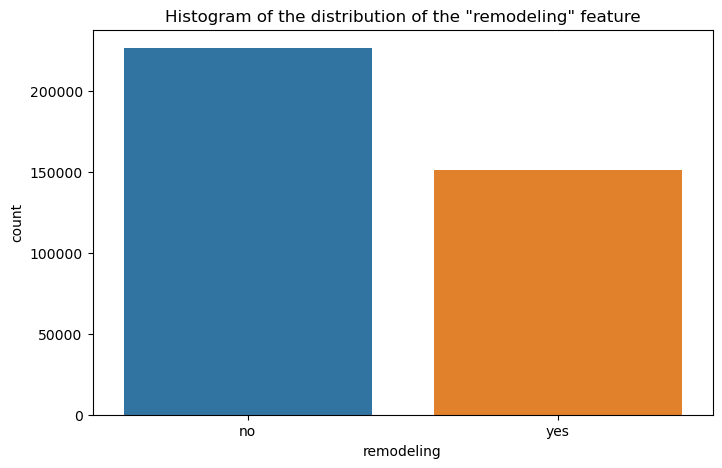

In [61]:
# Посмотрим на гистограмму распределения признака "remodeling".
# Let's look at the histogram of the distribution of the "remodeling" feature.
fig = plt.figure(figsize=(8, 5))
axes = sns.countplot(x='remodeling', data = data);
axes.set_title('Histogram of the distribution of the "remodeling" feature', fontsize=12)

Признак "remodeling" можно считать сбалансированным.

The "remodeling" feature can be considered balanced.

In [62]:
bin_cols.append('remodeling')

2. Извлечем из словаря год постройки дома и создадим новый признак **'year_built'**.

Let's extract the year the house was built from the dictionary and create a new feature **'year_built'**.

In [63]:
data['year_built'] = data['homeFacts'].apply(lambda x: x['atAGlanceFacts'][0]['factValue'])

In [64]:
print('Proportion of gaps in the "year_built" feature: {:.2f}%.'.format(data['year_built'].isnull().mean()*100)) #Доля пропусков в признаке "year_built"
print('Number of gaps in the "year_built" feature: {:.0f}.'.format(data['year_built'].isnull().sum())) # Количество пропусков в признаке "year_built"
print('Number of unique values in the "year_built" feature: {:.0f}.'.format(data['year_built'].nunique())) #Количество уникальных значений в признаке "year_built"

Proportion of gaps in the "year_built" feature: 0.96%.
Number of gaps in the "year_built" feature: 3613.
Number of unique values in the "year_built" feature: 230.


In [65]:
data['year_built'].unique()

array(['2019', '1961', '2006', '', '1920', '1976', '1970', '1965', '2015',
       '1996', '1982', '1905', '2008', '1899', '2016', '1954', '1989',
       '2014', '1915', '1994', '1910', '1923', '1960', '1977', '1972',
       '1963', '1981', '1949', '1930', '1991', '1958', '2005', '2017',
       '2018', '1983', '1928', '1998', '1997', '1964', '1974', '1940',
       '1973', '1968', '1999', '1918', '2007', '1984', '1946', '2003',
       '2000', '2004', '1969', '2002', '1952', '1947', '1957', '1978',
       '1956', '1967', '1975', '1988', '1955', '1950', '1959', '2012',
       '1924', '1966', '1992', '2001', '1995', '1985', '2010', '1971',
       '1909', '1953', '1993', '1990', '1980', '1951', '1907', '1885',
       '1941', '1927', '1929', '1901', None, '1922', '1906', '1945',
       '1979', '2009', '1962', '1913', '2011', '1897', '1987', '2020',
       '1926', '1939', '1925', '2013', '1986', 'No Data', '1943', '1935',
       '1890', '1900', '1895', '1911', '1948', '1942', '1916', '1931',
 

Приведем к единому виду отсутствующую информацию в признаке "year_built".

Let's bring the missing information in the "year_built" feature to a unified form.

In [66]:
data[data['year_built'].str.contains(r'[0-9]', regex=True) == False]['year_built'].unique()

array(['', 'No Data'], dtype=object)

In [67]:
data['year_built'] = data['year_built'].apply(lambda x: None if (x == '') | (x == 'No Data') | (x == '559990649990') | (x == '1') else x)

Заполним пропуски признака "year_built" имеющимися данными в признаке "Remodeled year", затем оставшиеся пропуски признака "year_built"заполним медианным значением данного признака.

Let's fill in the gaps of the "year_built" feature with the available data in the "Remodeled year" atfeaturetribute, then fill in the remaining gaps in the "year_built" feature with the median value of this feature.

In [68]:
data = data.fillna(value = {'year_built': data['remodeled_year'][data['remodeled_year'] != 0]})

In [69]:
# Переведем признак "year_built" в числовой формат.
# Let's convert the "year_built" feature into a number format.
data['year_built'] = data['year_built'].astype(float)

In [70]:
print('Median value of the "year_built" feature: {:.0f}'.format(data['year_built'].median())) # Медианное значение признака "year_built"

Median value of the "year_built" feature: 1985


In [71]:
# Let's fill in the remaining gaps in the "year_built" feature with the median value of this feature.
data = data.fillna(value = {'year_built': data['year_built'].median()})

In [72]:
# Переведем признак "remodeled_year" в числовой формат с целыми числами (тип int).
# Let's convert the "remodeled_year" feature into a numeric format with integers (int type).
data['year_built'] = data['year_built'].astype(int)
data['year_built'].dtype

dtype('int32')

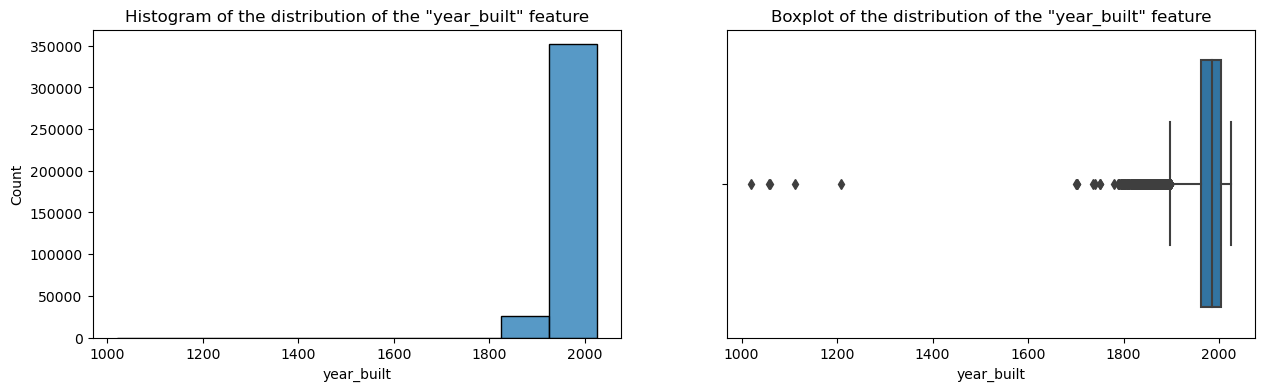

In [73]:
# Посмотрим на гистограмму распределения и коробчатую диаграмму признака "year_built".
# Let's look at the histogram of the distribution and boxplot of the "year_built" feature.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='year_built', bins=10, ax=axes[0]);
histplot.set_title('Histogram of the distribution of the "year_built" feature');
boxplot = sns.boxplot(data=data, x='year_built', ax=axes[1]);
boxplot.set_title('Boxplot of the distribution of the "year_built" feature');

Из полученных графиков видим, что данные признака "year_built" необходимо очистить от выбросов. Отфильтруем выбросы воспользовавшись методом Тьюки (метод межквартильного размаха). Для этого воспользуемся функцией outliers_iqr.

From the resulting graphs we see that the "year_built" feature data must be cleared of outliers.
Let's filter out outliers using Tukey's method (interquartile range method). To do this, we will use the outliers_iqr function.

In [74]:
outliers_yb, cleaned_yb = outliers_iqr(data, 'year_built')
print(f"Number of outliers according to Tukey's method: {outliers_yb.shape[0]}") # Число выбросов по методу Тьюки
print(f'Resulting number of records: {cleaned_yb.shape[0]}') # Результирующее число записей
# Number of outliers according to Tukey's method: 3795
# Resulting number of records: 373340

Number of outliers according to Tukey's method: 3795
Resulting number of records: 373340


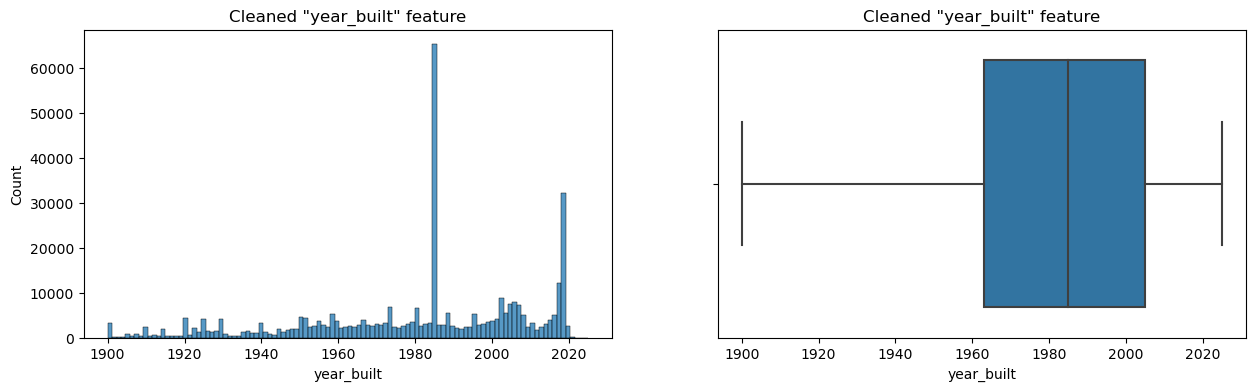

In [75]:
# Посмотрим на гистограмму распределения и коробчатую диаграмму признака "year_built" построенных на данных, очищенных от выбросов.
# Let's look at the distribution histogram and boxplot of the "year_built" feature built on data cleared of outliers.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_yb, x='year_built', ax=axes[0]);
histplot.set_title('Cleaned "year_built" feature');
boxplot = sns.boxplot(data=cleaned_yb, x='year_built', ax=axes[1]);
boxplot.set_title('Cleaned "year_built" feature');

Распределение имеет левый хвост. Далее можем подобрать ранее зафиксированные 1.5 межквартильных размахов влево и/или вправо и таким образом отобрать выбросы, учитывая особенности данных.

The distribution has a left tail. Next, we can select the previously recorded 1.5 interquartile ranges, to the left and/or to the right, and thus select outliers, taking into account the features of the data.

Посмотрим все ли значения соответствуют здравому смыслу.

Let's see if all the values correspond to common sense.

In [76]:
cleaned_yb['year_built'].describe()

count    373340.000000
mean       1981.099004
std          29.356118
min        1900.000000
25%        1963.000000
50%        1985.000000
75%        2005.000000
max        2025.000000
Name: year_built, dtype: float64

Видим, что в данных присутствуют не наступившие года на момент формирования отчета, удалим их.

We see that the data contains years that were not current at the time of generating the report, let’s delete them.

In [77]:
cleaned_yb = cleaned_yb.drop(cleaned_yb[cleaned_yb['year_built'] > 2021].index, axis=0)
cleaned_yb = cleaned_yb.reset_index(drop = True)

In [78]:
# Теперь нам не понадобится признак "remodeled_year", удалим его
# Now we don't need the "remodeled_year" attribute, let's remove it
cleaned_yb = cleaned_yb.drop(['remodeled_year'], axis=1)

In [79]:
num_cols.append('year_built')

3. Извлечем из словаря "Heating" (отопление) и создадим новый признак **'heating'**.

Let's extract "Heating" from the dictionary and create a new feature **'heating'**.

In [80]:
cleaned_yb['heating'] = cleaned_yb['homeFacts'].apply(lambda x: x['atAGlanceFacts'][2]['factValue'])

In [81]:
print('Proportion of gaps in the "heating" feature: {:.2f}%.'.format(cleaned_yb['heating'].isnull().mean()*100)) #Доля пропусков в признаке "heating"
print('Number of gaps in the "heating" feature: {:.0f}.'.format(cleaned_yb['heating'].isnull().sum())) # Количество пропусков в признаке "heating"
print('Number of unique values in the "heating" feature: {:.0f}.'.format(cleaned_yb['heating'].nunique())) #Количество уникальных значений в признаке "heating"

Proportion of gaps in the "heating" feature: 0.95%.
Number of gaps in the "heating" feature: 3533.
Number of unique values in the "heating" feature: 1942.


In [82]:
cleaned_yb['heating'].unique()

array(['Central A/C, Heat Pump', '', 'Forced Air', ...,
       'Central Furnace,Natural Gas',
       'Electric Furnace, Electric Heat Pump',
       'Floor Furnace, Wall Electric, Wall Gas'], dtype=object)

В признаке "heating" некоторые катеории имеют различное написание, но одинаковый смысл, приведём их к единообразию. Для упрощения поиска похожих категорий сначала приведём всё к нижнему регистру.

In the “heating” attribute, some categories have different spellings, but the same meaning, let’s bring them to uniformity. To simplify the search for similar categories, we first convert everything to lower case.

In [83]:
cleaned_yb['heating'] = cleaned_yb['heating'].fillna('other')

In [84]:
cleaned_yb['heating'] = cleaned_yb['heating'].apply(lambda x: str(x).lower())

In [85]:
cleaned_yb['heating'].value_counts(normalize=True, ascending=False)[:20]

forced air                     0.355779
                               0.281317
other                          0.087863
electric                       0.027228
gas                            0.024038
heat pump                      0.023582
no data                        0.022824
central air                    0.020896
central electric               0.019034
central                        0.016717
central, electric              0.011392
baseboard                      0.009638
wall                           0.008751
electric heat                  0.008205
heating system                 0.007230
forced air, heat pump          0.004709
central air, ceiling fan(s)    0.003836
radiant                        0.003798
natural gas heat               0.003704
central furnace                0.002770
Name: heating, dtype: float64

In [86]:
cleaned_yb['heating'] = cleaned_yb['heating'].apply(lambda x: 'forced' if 'forced' in x else x)
cleaned_yb['heating'] = cleaned_yb['heating'].apply(lambda x: 'central' if 'central' in x else x)
cleaned_yb['heating'] = cleaned_yb['heating'].apply(lambda x: 'other' if ('forced' not in x) and ('central' not in x) else x)

In [87]:
cleaned_yb['heating'].value_counts(normalize=True, ascending=False)

other      0.534141
forced     0.373327
central    0.092532
Name: heating, dtype: float64

In [88]:
cat_cols.append('heating')

4. Извлечем из словаря "Cooling" (охлаждение) и создадим новый признак **'cooling'**.

Let's extract "Cooling" from the dictionary and create a new feature **'cooling'**.

In [89]:
cleaned_yb['cooling'] = cleaned_yb['homeFacts'].apply(lambda x: x['atAGlanceFacts'][3]['factValue'])

In [90]:
print('Proportion of gaps in the "cooling" feature: {:.2f}%.'.format(cleaned_yb['cooling'].isnull().mean()*100)) #Доля пропусков в признаке "cooling"
print('Number of gaps in the "cooling" feature: {:.0f}.'.format(cleaned_yb['cooling'].isnull().sum())) # Количество пропусков в признаке "cooling"
print('Number of unique values in the "cooling" feature: {:.0f}.'.format(cleaned_yb['cooling'].nunique())) #Количество уникальных значений в признаке "cooling"

Proportion of gaps in the "cooling" feature: 0.95%.
Number of gaps in the "cooling" feature: 3533.
Number of unique values in the "cooling" feature: 1432.


In [91]:
cleaned_yb['cooling'].unique()

array(['', 'Central', 'Central Air', ...,
       'Central Air, Electric Hot Air, Gas (Hot Air), Heat Pump for A/C, Heat Pump for Heat, Multi-Zone A/C, Multi-Zone Heat, Natural Gas',
       '90%+ High Efficiency, Ductless HP-Mini Split, Tankless Water Heater',
       'Central A/C (Gas), Central Heat (Gas), Heat Pump'], dtype=object)

Сделаем признак "cooling" бинарным распределив данные на объекты с охлаждением - "1" и без охлаждения - "0", предположив что пропуски отностся к объектам не имеющих охлаждения. Для упрощения поиска похожих категорий сначала приведём всё к нижнему регистру.

Let's make the "cooling" feature binary by distributing the data into objects with cooling - "1" and without cooling - "0", assuming that the gaps refer to objects without cooling. To simplify the search for similar categories, we first convert everything to lower case.

In [92]:
cleaned_yb['cooling'] = cleaned_yb['cooling'].fillna('other')

In [93]:
cleaned_yb['cooling'] = cleaned_yb['cooling'].apply(lambda x: str(x).lower())

In [94]:
cleaned_yb['cooling'].value_counts(normalize=True, ascending=False)[:20]

central                                            0.421758
                                                   0.318091
central air                                        0.038400
no data                                            0.028064
has cooling                                        0.026017
none                                               0.018967
central electric                                   0.016473
other                                              0.014282
wall                                               0.010607
central gas                                        0.009565
central heating                                    0.007516
cooling system                                     0.007205
central a/c                                        0.005405
central a/c (electric), central heat (gas)         0.004409
central a/c (electric), central heat (electric)    0.003828
refrigeration                                      0.002879
central, electric                       

In [95]:
cleaned_yb['cooling'] = cleaned_yb['cooling'].apply(lambda x: '0' if ('no ' in x) or (x == '') else '1')

In [96]:
cleaned_yb['cooling'].value_counts(normalize=True, ascending=False)
# 1    0.65325
# 0    0.34675

1    0.65325
0    0.34675
Name: cooling, dtype: float64

In [97]:
bin_cols.append('cooling')

5. Извлечем из словаря "Parking" (парковка для автомобиля) и создадим новый признак **'parking'**.

Let's extract "Parking" from the dictionary and create a new feature **'parking'**.

In [98]:
cleaned_yb['parking'] = cleaned_yb['homeFacts'].apply(lambda x: x['atAGlanceFacts'][4]['factValue'])

In [99]:
print('Proportion of gaps in the "parking" feature: {:.2f}%.'.format(cleaned_yb['parking'].isnull().mean()*100)) #Доля пропусков в признаке "parking"
print('Number of gaps in the "parking" feature: {:.0f}.'.format(cleaned_yb['parking'].isnull().sum())) # Количество пропусков в признаке "parking"
print('Number of unique values in the "parking" feature: {:.0f}.'.format(cleaned_yb['parking'].nunique())) #Количество уникальных значений в признаке "parking"

Proportion of gaps in the "parking" feature: 0.95%.
Number of gaps in the "parking" feature: 3533.
Number of unique values in the "parking" feature: 3326.


In [100]:
cleaned_yb['parking'].unique()

array(['', 'Attached Garage', 'Detached Garage', ...,
       'Basement, Detached',
       'Paved Driveway, Off Street, Detached Garage',
       'Deed Restrictions, Fitness, Gated Community, Golf Carts OK, No Truck/RV/Motorcycle Parking, Pool, Special Community Restrictions'],
      dtype=object)

In [101]:
cleaned_yb['parking'] = cleaned_yb['parking'].fillna('other')

In [102]:
cleaned_yb['parking'] = cleaned_yb['parking'].apply(lambda x: str(x).lower())

In [103]:
cleaned_yb['parking'].value_counts(normalize=True, ascending=False)[:20]

                                    0.456269
attached garage                     0.189058
2 spaces                            0.074792
1 space                             0.037798
no data                             0.035004
detached garage                     0.033922
carport                             0.020708
off street                          0.013771
3 spaces                            0.012579
other                               0.009466
carport, attached garage            0.008103
1                                   0.007760
4 spaces                            0.007730
2                                   0.007216
none                                0.005695
on street                           0.004055
attached garage, detached garage    0.003595
0                                   0.002973
attached garage, carport            0.002657
parking desc                        0.002411
Name: parking, dtype: float64

In [104]:
cleaned_yb['parking'] = cleaned_yb['parking'].apply(lambda x: 'attached_garage' if 'attached' in x else x)
cleaned_yb['parking'] = cleaned_yb['parking'].apply(lambda x: 'detached_garage' if 'detached' in x else x)
cleaned_yb['parking'] = cleaned_yb['parking'].apply(lambda x: '1_space' if (x == '1') or (x == '1 space') else x)
cleaned_yb['parking'] = cleaned_yb['parking'].apply(lambda x: '2_spaces' if (x == '2') or (x == '2 spaces') else x)

Заменим категории, где количество парковочных мест больше двух, на категорию 'more_than_2_spaces'.

Let's replace categories where the number of parking spaces is more than two with the category 'more_than_2_spaces'.

In [105]:
pattern = re.compile('\d+')
# Создаём вспомогательный столбец "n_spaces", в который запишем количество парковочных мест
# Create an auxiliary column "n_spaces", in which we record the number of parking spaces
cleaned_yb['n_spaces'] = cleaned_yb['parking'].apply(lambda x: int(pattern.findall(x)[0]) if len(pattern.findall(x)) > 0 else 0)

# На основании полученной информации в столбце "n_spaces" запишем значение 'more_than_2_spaces' в столбец признака "parking" там где количество 
# парковочных мест больше двух
# Based on the information received in the "n_spaces" column, write the value 'more_than_2_spaces' into the "parking" feature column
# where the number of parking spaces is more than two

for i in cleaned_yb.index:
    if cleaned_yb['n_spaces'].loc[i] > 2:
        cleaned_yb['parking'].loc[i] = 'more_than_2_spaces'
    else:
        continue

# Удалим столбец "n_spaces"
# Remove the "n_spaces" column
cleaned_yb.drop('n_spaces', axis = 1, inplace = True)

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\543681123.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_yb['parking'].loc[i] = 'more_than_2_spaces'


In [106]:
# Остальные категории признака "parking" объединим в категорию "other"
# The remaining categories of the "parking" feature will be combined into the "other" category
cleaned_yb['parking'] = cleaned_yb['parking'].apply(lambda x: 'other' if (x != 'attached_garage') & (x != 'detached_garage') & (x != '1_space') & 
                                                    (x != '2_spaces') & (x != 'more_than_2_spaces') else x)

In [107]:
cleaned_yb['parking'].value_counts(normalize=True, ascending=False)

other                 0.580661
attached_garage       0.221019
2_spaces              0.082008
1_space               0.045558
detached_garage       0.038588
more_than_2_spaces    0.032167
Name: parking, dtype: float64

In [108]:
cat_cols.append('parking')

6. Извлечем из словаря "lotsize" (площадь земельного участка) и создадим новый признак **'lotsize'**.

Let's extract "lotsize" (land area) from the dictionary and create a new feature **'lotsize'**.

In [109]:
cleaned_yb['lotsize'] = cleaned_yb['homeFacts'].apply(lambda x: x['atAGlanceFacts'][5]['factValue'])

In [110]:
print('Proportion of gaps in the "lotsize" feature: {:.2f}%.'.format(cleaned_yb['lotsize'].isnull().mean()*100)) #Доля пропусков в признаке "lotsize"
print('Number of gaps in the "lotsize" feature: {:.0f}.'.format(cleaned_yb['lotsize'].isnull().sum())) # Количество пропусков в признаке "lotsize"
print('Number of unique values in the "lotsize" feature: {:.0f}.'.format(cleaned_yb['lotsize'].nunique())) #Количество уникальных значений в признаке "lotsize"

Proportion of gaps in the "lotsize" feature: 7.52%.
Number of gaps in the "lotsize" feature: 28078.
Number of unique values in the "lotsize" feature: 37175.


In [111]:
cleaned_yb['lotsize'].unique()

array([None, '5828 sqft', '8,626 sqft', ..., '8,019 sqft lot',
       '101.00 acres', '7,084 sqft lot'], dtype=object)

In [112]:
pattern = re.compile(r'\d+[.]?[,]?\d+')
cleaned_yb['lotsize'][cleaned_yb['lotsize'].str.contains(pattern) != True].unique()

array([None, '—', '', 'No Data', '-- sqft lot', '2 acres', '1 Acre',
       '3 acres', '1 acre lot', '2 Acres', '1 acre', '6 acres lot', '1',
       '2 acres lot', '1 Sq. Ft.', '4 acres', '5 acres', '5 Acres',
       '7 acres', '1 sqft', '5 acres lot', '3 Acres', '4 Acres', '9',
       '9 acres', '7 acres lot', '4 sqft', '1 sqft lot', '2',
       '4 sqft lot', '7', '6 acres', '8 acres', '6 Acres', '8 sqft',
       '8 Acres', '8 acres lot', '9 acres lot', '3 sqft lot', '5',
       '8 sqft lot', '9 Acres', '4 Sq. Ft.', '3 acres lot', '7 Acres',
       '3', '0 sqft'], dtype=object)

Заполним пропуски признака "lotsize" медианой, также считая за пропуски значения: '', '—', 'No Data' и '-- sqft lot'. Затем переведём все значения в квадратные метры.

Let's fill the gaps in the "lotsize" feature with the median, also counting the following values as gaps: '', '—', 'No Data' and '-- sqft lot'. Then we convert all values into square meters.

In [113]:
pattern = re.compile(r'(\d+[.]?[,]?\d+)')  # Добавляем скобки для захвата числовых значений (Adding parentheses to capture numeric values)

# Извлекаем числовые значения с помощью регулярного выражения и NumPy
# Extract numeric values using regular expression and NumPy
numeric_values = cleaned_yb['lotsize'].str.extract(pattern, expand=False)
numeric_values = numeric_values.str.replace(',', '').astype(float)

# Фильтруем NaN значения
# Filter NaN values
numeric_values = numeric_values[~numeric_values.isna()]

# Приводим к размерности [кв.м.] с использованием NumPy
# Convert to [sq.m.] using NumPy
numeric_values = np.where(numeric_values > 1, numeric_values / 10.764, numeric_values * 4047)

# Считаем медиану с использованием np.median()
# Calculate the median using np.median()
median_lotsize_m2 = np.median(numeric_values)
median_lotsize_sqft = round(median_lotsize_m2 * 10.764)
print('Median of the "lotsize" feature: {:.0f} sqft.'.format(median_lotsize_sqft)) # Медиана признака "lotsize"
# Median of the "lotsize" feature: 7405 sqft.

Median of the "lotsize" feature: 7405 sqft.


Теперь в датафрейме "cleaned_yb" заменим пропуски и значения '', '—', 'No Data' и '-- sqft lot' на значение '7405'.

Now in the dataframe "cleaned_yb" we will replace the gaps and values '', '—', 'No Data' and '-- sqft lot' with the value '7405'.

In [114]:
cleaned_yb['lotsize'] = cleaned_yb['lotsize'].apply(lambda x: str(median_lotsize_sqft) if (x=='') | (x=='—') | (x=='No Data') | (x=='-- sqft lot') | \
                                    (pd.isnull(x) == True) else x)

In [115]:
pattern = re.compile('\d+[.]?[,]?\d+')
# Выделяем цифровые значения
# Select digital values
cleaned_yb['lotsize'] = cleaned_yb['lotsize'].apply(lambda x: str(median_lotsize_sqft) if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])
# Убираем запятые
# Remove commas
cleaned_yb['lotsize'] = cleaned_yb['lotsize'].apply(lambda x: x.replace(',', ''))
# Переводим в числовой формат
# Convert to numeric format
cleaned_yb['lotsize'] = cleaned_yb['lotsize'].apply(lambda x: float(x))
# Приводим всё к размерности [кв.м.]
# We bring everything to the dimension [sq.m.]
cleaned_yb['lotsize'] = cleaned_yb['lotsize'].apply(lambda x: round(x/10.764) if x > 1 else round(x*4047))

In [116]:
cleaned_yb['lotsize'].describe()

count    3.733300e+05
mean     3.243503e+03
std      4.410461e+05
min      0.000000e+00
25%      5.110000e+02
50%      6.880000e+02
75%      9.170000e+02
max      1.995061e+08
Name: lotsize, dtype: float64

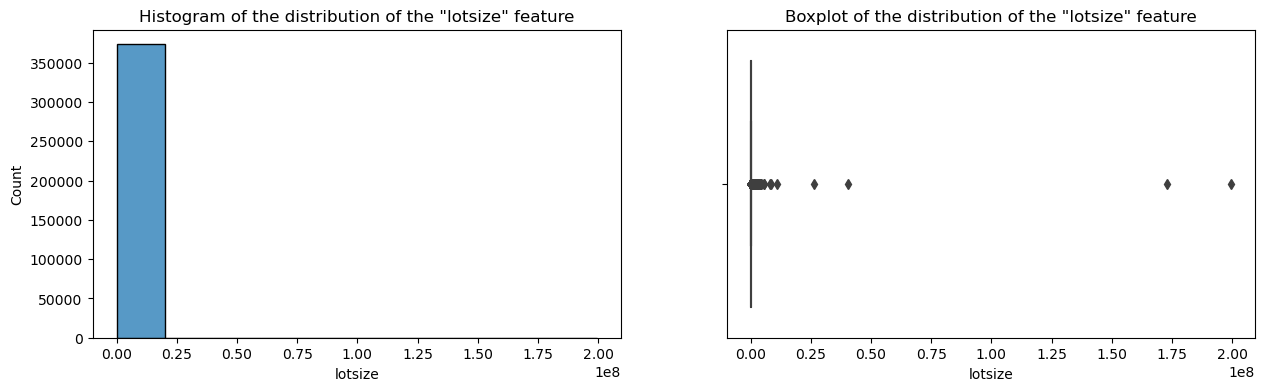

In [117]:
# Посмотрим на гистограмму распределения и коробчатую диаграмму признака "lotsize".
# Let's look at the histogram of the distribution and boxplot of the "lotsize" feature.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_yb, x='lotsize', bins=10, ax=axes[0]);
histplot.set_title('Histogram of the distribution of the "lotsize" feature');
boxplot = sns.boxplot(data=cleaned_yb, x='lotsize', ax=axes[1]);
boxplot.set_title('Boxplot of the distribution of the "lotsize" feature');

Из полученных графиков видим, что данные признака "lotsize" необходимо очистить от выбросов. Отфильтруем выбросы воспользовавшись методом Тьюки (метод межквартильного размаха). Для этого воспользуемся функцией outliers_iqr.

From the resulting graphs we see that the "lotsize" feature data must be cleared of outliers.
Let's filter out outliers using Tukey's method (interquartile range method). To do this, we will use the outliers_iqr function.

In [118]:
outliers_ls, cleaned_ls = outliers_iqr(cleaned_yb, 'lotsize')
print(f"Number of outliers according to Tukey's method: {outliers_ls.shape[0]}") # Число выбросов по методу Тьюки
print(f'Resulting number of records: {cleaned_ls.shape[0]}') # Результирующее число записей
# Number of outliers according to Tukey's method: 68191
# Resulting number of records: 305139

Number of outliers according to Tukey's method: 68191
Resulting number of records: 305139


Посмотрим все ли значения соответствуют здравому смыслу.

Let's see if all the values correspond to common sense.

In [119]:
cleaned_ls['lotsize'].describe()

count    305139.000000
mean        781.619046
std         354.247107
min         213.000000
25%         622.000000
50%         688.000000
75%         874.000000
max        2202.000000
Name: lotsize, dtype: float64

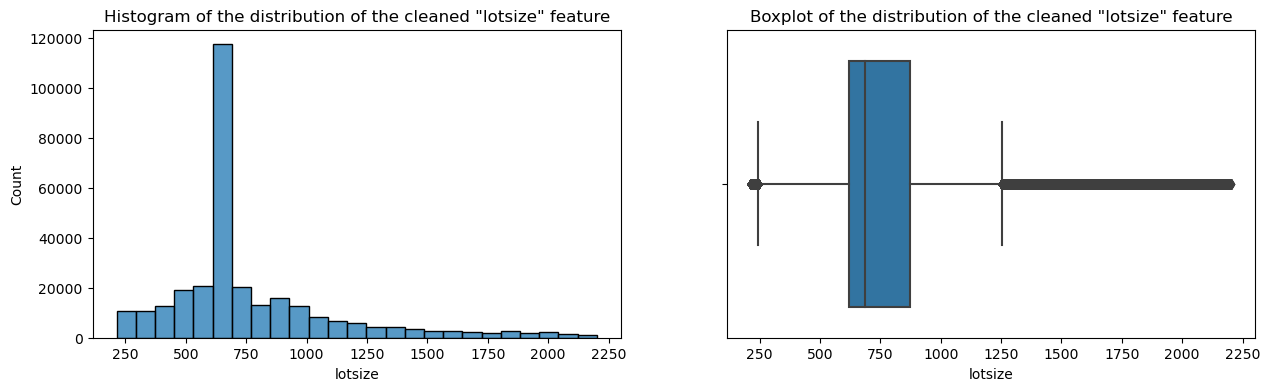

In [120]:
# Посмотрим на гистограмму распределения и коробчатую диаграмму признака "lotsize" построенных на данных, очищенных от выбросов.
# Let's look at the distribution histogram and boxplot of the "lotsize" feature built on data cleared of outliers.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_ls, x='lotsize', bins=25, ax=axes[0]);
histplot.set_title('Histogram of the distribution of the cleaned "lotsize" feature');
boxplot = sns.boxplot(data=cleaned_ls, x='lotsize', ax=axes[1]);
boxplot.set_title('Boxplot of the distribution of the cleaned "lotsize" feature');

In [121]:
num_cols.append('lotsize')

7. Извлечем из словаря "Price/sqft" (цена 1 квадратного фута земли) и создадим новый признак **'price_sqft'** - это последний признак находящийся в столбце homeFacts.

Let's extract "Price/sqft" (the price of 1 square foot of land) from the dictionary and create a new attribute **'price_sqft'** - this is the last feature located in the homeFacts column.

In [122]:
cleaned_ls['price_sqft'] = cleaned_ls['homeFacts'].apply(lambda x: x['atAGlanceFacts'][6]['factValue'])

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\173298472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_ls['price_sqft'] = cleaned_ls['homeFacts'].apply(lambda x: x['atAGlanceFacts'][6]['factValue'])


In [123]:
print('Proportion of gaps in the "price_sqft" feature: {:.2f}%.'.format(cleaned_ls['price_sqft'].isnull().mean()*100)) #Доля пропусков в признаке "price_sqft"
print('Number of gaps in the "price_sqft" feature: {:.0f}.'.format(cleaned_ls['price_sqft'].isnull().sum())) # Количество пропусков в признаке "price_sqft"
print('Number of unique values in the "price_sqft" feature: {:.0f}.'.format(cleaned_ls['price_sqft'].nunique())) #Количество уникальных значений в признаке "price_sqft"

Proportion of gaps in the "price_sqft" feature: 14.12%.
Number of gaps in the "price_sqft" feature: 43094.
Number of unique values in the "price_sqft" feature: 5996.


In [124]:
list(cleaned_ls['price_sqft'][cleaned_ls['price_sqft'].str.contains(r'[0-9]') != True].unique())

[None, 'No Info', '', 'No Data', 'Contact manager']

Заполним пропуски признака "price_sqft" медианой, также считая за пропуски значения: '', 'No Data', 'No Info' и 'Contact manager'. Затем, создав новый признак "price_sqm", переведём все значения из стоимости 1-го квадратного фута в стоимость 1-го квадратного метра, умножив их на 10,764.

Let's fill in the gaps of the "price_sqft" feature with the median, also counting the following values as gaps: '', 'No Data', 'No Info' и 'Contact manager'. Then, having created a new feature "price_sqm", we will convert all values from the price of 1 square foot to the price of 1 square meter, multiplying them by 10.764.

In [125]:
pattern = re.compile(r'(\d+[.]?[,]?\d+)')  # Добавляем скобки для захвата числовых значений (Adding parentheses to capture numeric values)
# Извлекаем числовые значения с помощью регулярного выражения и NumPy
# Extract numeric values using regular expression and NumPy
numeric_values = cleaned_ls['price_sqft'].str.extract(pattern, expand=False)
numeric_values = numeric_values.str.replace(',', '').astype(float)
# Фильтруем NaN значения
# Filter NaN values
numeric_values = numeric_values[~numeric_values.isna()]
# Считаем медиану с использованием np.median()
# Calculate the median using np.median()
median_price_sqft = round(np.median(numeric_values))
print('Median of the "price_sqft" feature: {:.0f} $/sqft.'.format(median_price_sqft)) # Медиана признака "price_sqft"
# Median of the "price_sqft" feature: 173 $/sqft.

Median of the "price_sqft" feature: 173 $/sqft.


Теперь в датафрейме "cleaned_ls" заменим пропуски и значения '', 'No Data', 'No Info' и 'Contact manager' на значение '173'.

Now in the dataframe "cleaned_ls" we will replace the gaps and values '', 'No Data', 'No Info' и 'Contact manager' with the value '173'.

In [126]:
cleaned_ls['price_sqft'] = cleaned_ls['price_sqft'].apply(lambda x: str(median_price_sqft) if (x == '') | (x == 'No Data') | (x == 'No Info') | 
                                                          (x == 'Contact manager') | (pd.isnull(x) == True) else x)
cleaned_ls['price_sqft'].isnull().sum()

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\2896607279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_ls['price_sqft'] = cleaned_ls['price_sqft'].apply(lambda x: str(median_price_sqft) if (x == '') | (x == 'No Data') | (x == 'No Info') |


0

In [127]:
pattern = re.compile('\d+[.]?[,]?\d+')
# Выделяем цифровые значения
# Select digital values
cleaned_ls['price_sqft'] = cleaned_ls['price_sqft'].apply(lambda x: str(median_price_sqft) if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])
# Убираем запятые
# Remove commas
cleaned_ls['price_sqft'] = cleaned_ls['price_sqft'].apply(lambda x: x.replace(',', ''))
# Переводим в числовой формат
# Convert to numeric format
cleaned_ls['price_sqft'] = cleaned_ls['price_sqft'].apply(lambda x: int(x))
# Переводим цены за кв.фут в цены за кв.м.
# Convert prices per sq.ft to prices per sq.m.
cleaned_ls['price_sqm'] = cleaned_ls['price_sqft'].apply(lambda x: round(x*10.764))

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\3886719131.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_ls['price_sqft'] = cleaned_ls['price_sqft'].apply(lambda x: str(median_price_sqft) if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])
C:\Users\USER\AppData\Local\Temp\ipykernel_9932\3886719131.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_ls['price_sqft'] = cleaned_ls['price_sqft'].apply(lambda x: x.replace(',', ''))
C:\Users\USER\AppData\Local\Temp\ipykernel_9932\388

In [128]:
cleaned_ls.drop(['price_sqft'], axis = 1, inplace = True)

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\1065766610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_ls.drop(['price_sqft'], axis = 1, inplace = True)


In [129]:
cleaned_ls['price_sqm'].describe()

count    3.051390e+05
mean     3.364125e+03
std      1.149665e+05
min      1.080000e+02
25%      1.410000e+03
50%      1.862000e+03
75%      2.723000e+03
max      5.382000e+07
Name: price_sqm, dtype: float64

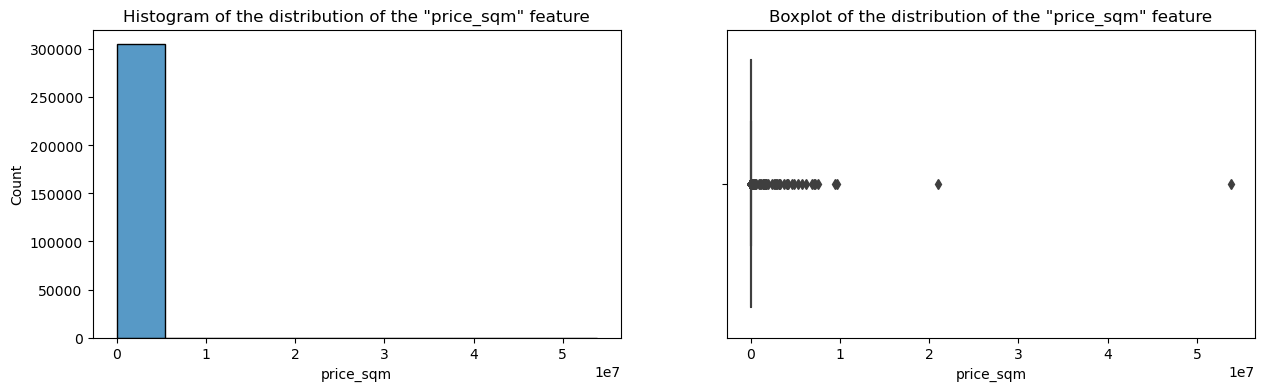

In [130]:
# Посмотрим на гистограмму распределения и коробчатую диаграмму признака "price_sqm".
# Let's look at the histogram of the distribution and boxplot of the "price_sqm" feature.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_ls, x='price_sqm', bins=10, ax=axes[0]);
histplot.set_title('Histogram of the distribution of the "price_sqm" feature');
boxplot = sns.boxplot(data=cleaned_ls, x='price_sqm', ax=axes[1]);
boxplot.set_title('Boxplot of the distribution of the "price_sqm" feature');

Из полученных графиков видим, что данные признака "price_sqm" необходимо очистить от выбросов. Отфильтруем выбросы воспользовавшись методом Тьюки (метод межквартильного размаха). Для этого воспользуемся функцией outliers_iqr.

From the resulting graphs we see that the “price_sqm” feature data must be cleared of outliers.
Let's filter out outliers using Tukey's method (interquartile range method). To do this, we will use the outliers_iqr function.

In [131]:
outliers_psqm, cleaned_psqm = outliers_iqr(cleaned_ls, 'price_sqm')
print(f"Number of outliers according to Tukey's method: {outliers_psqm.shape[0]}") # Число выбросов по методу Тьюки
print(f'Resulting number of records: {cleaned_psqm.shape[0]}') # Результирующее число записей
# Number of outliers according to Tukey's method: 21894
# Resulting number of records: 283245

Number of outliers according to Tukey's method: 21894
Resulting number of records: 283245


Посмотрим все ли значения соответствуют здравому смыслу.

Let's see if all the values correspond to common sense.

In [132]:
cleaned_psqm['price_sqm'].describe()

count    283245.000000
mean       2217.781486
std        1276.535171
min         527.000000
25%        1421.000000
50%        1862.000000
75%        2519.000000
max        7298.000000
Name: price_sqm, dtype: float64

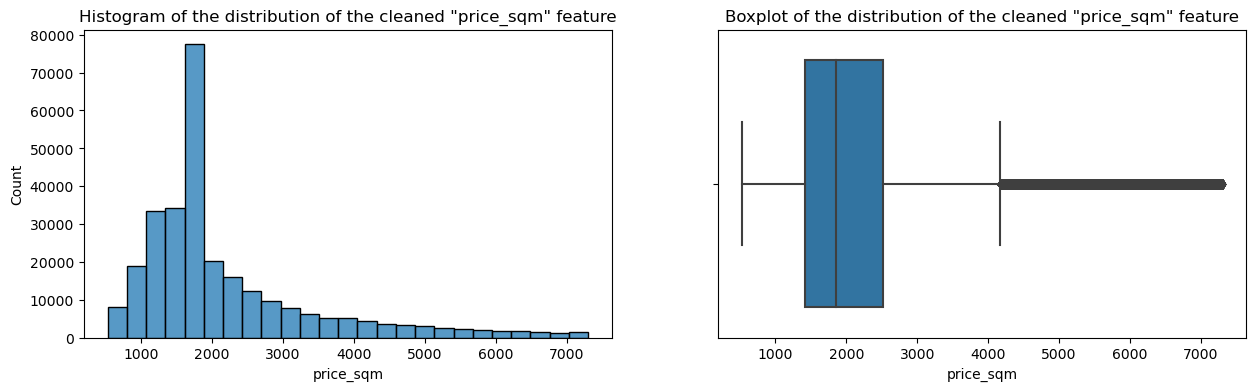

In [133]:
# Посмотрим на гистограмму распределения и коробчатую диаграмму признака "price_sqm" построенных на данных, очищенных от выбросов.
# Let's look at the distribution histogram and boxplot of the "price_sqm" feature built on data cleared of outliers.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_psqm, x='price_sqm', bins=25, ax=axes[0]);
histplot.set_title('Histogram of the distribution of the cleaned "price_sqm" feature');
boxplot = sns.boxplot(data=cleaned_psqm, x='price_sqm', ax=axes[1]);
boxplot.set_title('Boxplot of the distribution of the cleaned "price_sqm" feature');

In [134]:
num_cols.append('price_sqm')

In [135]:
cleaned_psqm.drop('homeFacts', axis = 1, inplace = True)

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\495981315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_psqm.drop('homeFacts', axis = 1, inplace = True)


### 8. "fireplace" feature

In [136]:
print('Proportion of gaps in the "fireplace" feature: {:.2f}%.'.format(cleaned_psqm['fireplace'].isnull().mean()*100)) #Доля пропусков в признаке "fireplace"
print('Number of gaps in the "fireplace" feature: {:.0f}.'.format(cleaned_psqm['fireplace'].isnull().sum())) # Количество пропусков в признаке "fireplace"
print('Number of unique values in the "fireplace" feature: {:.0f}.'.format(cleaned_psqm['fireplace'].nunique())) #Количество уникальных значений в признаке "fireplace"

Proportion of gaps in the "fireplace" feature: 72.95%.
Number of gaps in the "fireplace" feature: 206616.
Number of unique values in the "fireplace" feature: 1127.


In [137]:
cleaned_psqm['fireplace'].unique()

array(['Gas Logs', nan, 'yes', ...,
       'Fireplace-Gas, Fireplace-Wood, Patio, Walk-in Closet',
       'Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets',
       'Gas Logs, In Bedroom, In Den/Family Room, In Living Room'],
      dtype=object)

Предположим, что пропуски в признаке "fireplace" означают отсутствие камина, поэтому заполним их категорией 'no'.

Let's assume that the gaps in the "fireplace" feature mean the absence of a fireplace, so let's fill them with the 'no' category.

In [138]:
cleaned_psqm['fireplace'] = cleaned_psqm['fireplace'].fillna('no')

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\3510670001.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_psqm['fireplace'] = cleaned_psqm['fireplace'].fillna('no')


В признаке "fireplace" некоторые катеории имеют различное написание, но одинаковый смысл, приведём их к единообразию. Для упрощения поиска похожих категорий сначала приведём всё к нижнему регистру.

In the "fireplace" attribute, some categories have different spellings, but the same meaning, let’s bring them to uniformity. To simplify the search for similar categories, we first convert everything to lower case.

In [139]:
cleaned_psqm['fireplace'] = cleaned_psqm['fireplace'].apply(lambda x: str(x).lower())
cleaned_psqm['fireplace'].value_counts(normalize=True, ascending = False)[:50]

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\1969754065.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_psqm['fireplace'] = cleaned_psqm['fireplace'].apply(lambda x: str(x).lower())


no                                                                          0.730389
yes                                                                         0.184392
1                                                                           0.042599
not applicable                                                              0.006772
2                                                                           0.005970
fireplace                                                                   0.002178
living room                                                                 0.001165
3                                                                           0.001123
gas/gas logs                                                                0.000897
1 fireplace                                                                 0.000812
fireplace yn                                                                0.000759
wood burning                                                     

In [140]:
# Заменим категорию '0' на 'no' в признаке "fireplace".
# Replace category '0' with 'no' in the "fireplace" feature.
cleaned_psqm['fireplace'] = cleaned_psqm['fireplace'].apply(lambda x: 'no' if x == '0' else x)

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\4240490352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_psqm['fireplace'] = cleaned_psqm['fireplace'].apply(lambda x: 'no' if x == '0' else x)


Сделаем бинарным признак "fireplace", заменив все значения, которые не равны 'no' на 'yes'.

Let's make the "fireplace" feature binary by replacing all values that are not equal to 'no' with 'yes'.

In [141]:
cleaned_psqm['fireplace'] = cleaned_psqm['fireplace'].apply(lambda x: 'yes' if x != 'no' else x)

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\855295403.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_psqm['fireplace'] = cleaned_psqm['fireplace'].apply(lambda x: 'yes' if x != 'no' else x)


In [142]:
cleaned_psqm = cleaned_psqm.reset_index(drop = True)

In [143]:
print('Shares by object types in the "fireplace" feature % \n{}'.format(round(cleaned_psqm['fireplace'].value_counts(normalize=True, ascending=False)*100, 2)))

Shares by object types in the "fireplace" feature % 
no     73.11
yes    26.89
Name: fireplace, dtype: float64


In [144]:
bin_cols.append('fireplace')

### 9. "city" feature

In [145]:
print('Proportion of gaps in the "city" feature: {:.2f}%.'.format(cleaned_psqm['city'].isnull().mean()*100)) #Доля пропусков в признаке "city"
print('Number of gaps in the "city" feature: {:.0f}.'.format(cleaned_psqm['city'].isnull().sum())) # Количество пропусков в признаке "city"
print('Number of unique values in the "city" feature: {:.0f}.'.format(cleaned_psqm['city'].nunique())) #Количество уникальных значений в признаке "city"

Proportion of gaps in the "city" feature: 0.01%.
Number of gaps in the "city" feature: 18.
Number of unique values in the "city" feature: 1688.


In [146]:
cleaned_psqm['city'].unique()

array(['Southern Pines', 'Spokane Valley', 'Dallas', ..., 'Bedford Hts',
       'HAINES CITY', 'Blue Springs'], dtype=object)

In [147]:
cleaned_psqm['city'].value_counts(normalize=True, ascending=False)[:20]

Houston            0.068871
San Antonio        0.050306
Miami              0.046581
Jacksonville       0.028211
Dallas             0.027155
Fort Worth         0.017647
Charlotte          0.017555
Chicago            0.017534
Las Vegas          0.017435
New York           0.015881
Orlando            0.015638
Austin             0.014963
Fort Lauderdale    0.014956
Tampa              0.014871
Nashville          0.011937
Brooklyn           0.011673
Palm Coast         0.010673
Atlanta            0.009762
Washington         0.009099
Seattle            0.008947
Name: city, dtype: float64

Посмотрим можно ли заполнить пропуски используя данные признака "zipcode"

Let's see if we can fill in the gaps using the "zipcode" feature data.

In [148]:
cityNaN_zip = cleaned_psqm[cleaned_psqm['city'].isnull() == True][['city', 'zipcode']]
cityNaN_zip

,city,zipcode
91796,NaN,34481
92662,NaN,33955
98004,NaN,20003
98541,NaN,33954
127865,NaN,34741
140103,NaN,34481
149834,NaN,34473
161375,NaN,34488
197047,NaN,38732
209211,NaN,34747


In [149]:
cityNaN_zip['zipcode'].unique()

array(['34481', '33955', '20003', '33954', '34741', '34473', '34488',
       '38732', '34747', '32179', '33126'], dtype=object)

In [150]:
# установим связи между почтовыми индексами и соответствующим им названиям городов в обнаруженных пропусках признака "city"
# establish connections between postal codes and their corresponding city names in the detected gaps of the "city" feature
city_zip = {'33955': 'Punta Gorda', '20003': 'Washington', '33954': 'Port Charlotte', '34741':'Kissimmee', '34481': 'Ocala', '34473': 'Ocala', 
            '38732':'Cleveland', '34747': 'Kissimmee', '32179': 'Ocklawaha', '33126': 'Doral'}
city_zip

{'33955': 'Punta Gorda',
 '20003': 'Washington',
 '33954': 'Port Charlotte',
 '34741': 'Kissimmee',
 '34481': 'Ocala',
 '34473': 'Ocala',
 '38732': 'Cleveland',
 '34747': 'Kissimmee',
 '32179': 'Ocklawaha',
 '33126': 'Doral'}

In [151]:
cleaned_psqm['city'] = cleaned_psqm['city'].fillna(cleaned_psqm['zipcode'])
cleaned_psqm['city'] = cleaned_psqm['city'].replace(city_zip)

In [152]:
cleaned_psqm['city'].value_counts(normalize=True, ascending=False).cumsum()[:300]

Houston         0.068866
San Antonio     0.119169
Miami           0.165747
Jacksonville    0.193956
Dallas          0.221109
                  ...   
Mocksville      0.903158
Redford         0.903543
Bal Harbour     0.903921
Fontana         0.904298
Dunnellon       0.904673
Name: city, Length: 300, dtype: float64

Выделим 300 городов, которые описывают около 90% примеров, остальные назовём "other".

Let's select 300 cities that describe about 90% of the examples, the rest we'll call "other".

In [153]:
cities_list = set(cleaned_psqm.city.value_counts().index)
cities_main = set(cleaned_psqm.city.value_counts().index[:300])
cities_drop = list(cities_list - cities_main)
cleaned_psqm.loc[cleaned_psqm['city'].isin(cities_drop), 'city'] = 'other'

In [154]:
cleaned_psqm['city'].value_counts(normalize=True, ascending=False).cumsum()[:15]

other              0.095327
Houston            0.164194
San Antonio        0.214496
Miami              0.261074
Jacksonville       0.289283
Dallas             0.316436
Fort Worth         0.334082
Charlotte          0.351636
Chicago            0.369168
Las Vegas          0.386602
New York           0.402482
Orlando            0.418119
Austin             0.433081
Fort Lauderdale    0.448036
Tampa              0.462907
Name: city, dtype: float64

In [155]:
cat_cols.append('city')

### 10. "schools" feature

In [156]:
print('Proportion of gaps in the "schools" feature: {:.2f}%.'.format(cleaned_psqm['schools'].isnull().mean()*100)) #Доля пропусков в признаке "schools"
print('Number of gaps in the "schools" feature: {:.0f}.'.format(cleaned_psqm['schools'].isnull().sum())) # Количество пропусков в признаке "schools"
print('Number of unique values in the "schools" feature: {:.0f}.'.format(cleaned_psqm['schools'].nunique())) #Количество уникальных значений в признаке "schools"

Proportion of gaps in the "schools" feature: 0.00%.
Number of gaps in the "schools" feature: 0.
Number of unique values in the "schools" feature: 224496.


В признаке "schools" типом данных является строка, в которой закодирован список. Применим функцию eval для раскодировки списка.

In the "schools" attribute, the data type is a string in which the list is encoded. Let's use the eval function to decode the list.

In [157]:
# ast.literal_eval используется для безопасного преобразования строки в питоновский объект, чтобы избежать потенциальных проблем безопасности, 
# связанных с выполнением кода, предоставленного в строке.
# Преобразовываем строку в список словарей с помощью ast.literal_eval
# ast.literal_eval is used to safely convert a string to a Python object to avoid potential security issues,
# related to executing the code provided in the string.
# Convert the string to a list of dictionaries using ast.literal_eval
def extract_data_from_json(json_str):
    json_list = ast.literal_eval(json_str)
    for item in json_list:
        extracted_item = {
            'rating': (item['rating']),
            'Distance': (item['data']['Distance']),
            'Grades': (item['data']['Grades']),
            'name': (item['name'])
        }
    return extracted_item

cleaned_psqm['schools'] = cleaned_psqm['schools'].apply(extract_data_from_json)
# Можно реализовать преобразование одной строкой кода / Can implement conversion with one line of code:
# cleaned_psqm['schools_1'] = cleaned_psqm['schools'].apply(eval)
# cleaned_psqm.loc[:, ['schools_2']] = cleaned_psqm['schools'].apply(lambda x: ast.literal_eval(x)[0])
# cleaned_psqm.loc[:, ['schools_3']] = cleaned_psqm['schools'].apply(ast.literal_eval)

В признаке "schools" содержатся данные о школах, расположенных рядом с домом, такие как: "rating" - рейтинги школ, "Distance" - расстояния до школ, "Grades" - возрастной уровень школ и "name" - названия школ. Обработав признак "schools" получим следующие признаки: средний рейтинг школ - "average_rating_school", количество рядом расположенных школ - "number_of_schools" и среднее расстояние до школ - "average_distance_to_school". Последовательно извлечём данные для создания этих признаков.

The "schools" feature contains data about schools located near the house, such as: "rating" - ratings of schools, "Distance" - distances to schools, "Grades" - age level of schools and "name" - names of schools. Having processed the “schools” feature, we obtain the following features: the average rating of schools is “average_rating_school”, the number of nearby schools is “number_of_schools” and the average distance to schools is “average_distance_to_school”. We will sequentially extract data to create these features.

1. Извлечем данные рейтингов школ и создадим новый признак **'average_rating_school'**.

Let's extract school rating data and create a new feature **'average_rating_school'**.

In [158]:
cleaned_psqm['average_rating_school'] = cleaned_psqm['schools'].apply(lambda x: x['rating'])

In [159]:
print('Proportion of gaps in the "average_rating_school" feature: {:.2f}%.'.format(cleaned_psqm['average_rating_school'].isnull().mean()*100)) #Доля пропусков в признаке "average_rating_school"
print('Number of gaps in the "average_rating_school" feature: {:.0f}.'.format(cleaned_psqm['average_rating_school'].isnull().sum())) # Количество пропусков в признаке "average_rating_school"

Proportion of gaps in the "average_rating_school" feature: 0.00%.
Number of gaps in the "average_rating_school" feature: 0.


In [160]:
# Посмотрим на структуру данных.
# Let's look at the data structure.
cleaned_psqm['average_rating_school'].head(3)
# [4, 4, 7, NR, 4, 7, NR, NR]

0    [4, 4, 7, NR, 4, 7, NR, NR]
1          [4/10, None/10, 4/10]
2      [9/10, 9/10, 10/10, 9/10]
Name: average_rating_school, dtype: object

In [161]:
# Извлечём числовые показатели и посчитаем средний рейтинг рядом расположенных школ.
# Let's extract the numerical indicators and calculate the average rating of nearby schools.
pattern = re.compile('\d+')
# Создаем функцию, которая извлекает числа из строки и возвращает среднее значение
# Create a function that extracts numbers from a string and returns the average value
def process_row(row):
    sum_ratings = 0
    count = 0
    for item in row:
        if (len(pattern.findall(item)) != 0) and ('None' not in item):
            sum_ratings += int(pattern.findall(item)[0])
            count += 1
    if count == 0:
        return 0
    else:
        return round(sum_ratings / count, 1)
# Примените эту функцию ко всем значениям столбца 'average_rating_school'
# Apply this function to all values in the 'average_rating_school' column
cleaned_psqm['average_rating_school'] = cleaned_psqm['average_rating_school'].apply(process_row)

In [162]:
cleaned_psqm[['average_rating_school']].head()

,average_rating_school
0,5.2
1,4.0
2,9.2
3,4.7
4,2.3


In [163]:
print('Proportion of gaps in the "average_rating_school" feature: {:.2f}%.'.format(cleaned_psqm['average_rating_school'].isnull().mean()*100)) #Доля пропусков в признаке "average_rating_school"
print('Number of gaps in the "average_rating_school" feature: {:.0f}.'.format(cleaned_psqm['average_rating_school'].isnull().sum())) # Количество пропусков в признаке "average_rating_school"
print('Number of unique values in the "average_rating_school" feature: {:.0f}.'.format(cleaned_psqm['average_rating_school'].nunique())) #Количество уникальных значений в признаке "average_rating_school"

Proportion of gaps in the "average_rating_school" feature: 0.00%.
Number of gaps in the "average_rating_school" feature: 0.
Number of unique values in the "average_rating_school" feature: 88.


In [164]:
cleaned_psqm['average_rating_school'].value_counts(normalize=True, ascending=False).iloc[:15]

6.0    0.063066
4.0    0.053170
5.0    0.051768
3.0    0.048372
6.3    0.041381
3.7    0.041349
3.3    0.040753
5.3    0.034956
4.7    0.034924
7.0    0.034885
5.7    0.034550
4.3    0.033702
8.0    0.029727
2.7    0.029536
2.0    0.025501
Name: average_rating_school, dtype: float64

In [165]:
cleaned_psqm['average_rating_school'].describe()

count    283245.000000
mean          5.109816
std           1.968134
min           0.000000
25%           3.700000
50%           5.000000
75%           6.500000
max          10.000000
Name: average_rating_school, dtype: float64

In [166]:
numb_null = cleaned_psqm['average_rating_school'][cleaned_psqm['average_rating_school'] == 0].count()
print('В признаке "average_rating_school" найдено {} нулевых значений.'.format(numb_null))


В признаке "average_rating_school" найдено 2997 нулевых значений.


Заменим нулевые значения в признаке "average_rating_school" медианой, округлённой до целого числа.

Let's replace the zero values in the "average_rating_school" feature with the median.

In [167]:
# Отфильтруем нули в признаке "average_rating_school" и посчитаем медиану
# Filter out the zeros in the "average_rating_school" feature and calculate the median
round(cleaned_psqm['average_rating_school'][cleaned_psqm['average_rating_school'] != 0].median())

5

In [168]:
# Заменим нулевые значения медианой.
# Replace zero values with median.
cleaned_psqm['average_rating_school'] = cleaned_psqm['average_rating_school'].apply(lambda x: 5 if x == 0 else x)

Text(0.5, 1.0, 'Histogram of the distribution of the "average_rating_school" feature')

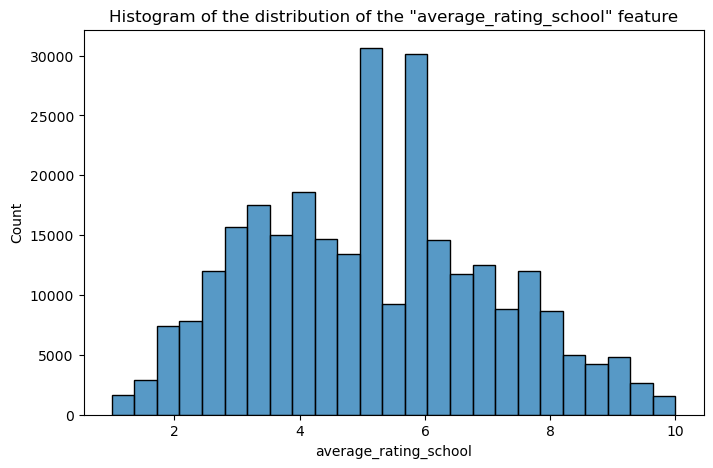

In [169]:
# Посмотрим на гистограмму распределения признака "average_rating_school".
# Let's look at the histogram of the distribution of the "average_rating_school" feature.
fig = plt.figure(figsize=(8, 5))
axes = sns.histplot(x='average_rating_school', data = cleaned_psqm, bins=25); # bins=10
axes.set_title('Histogram of the distribution of the "average_rating_school" feature', fontsize=12)

In [170]:
num_cols.append('average_rating_school')

2. Извлечем данные количества рядом расположенных школ и создадим новый признак **'number_of_schools'**.

Let's extract the data on the numbers of nearby schools and create a new feature **'number_of_schools'**.

In [171]:
cleaned_psqm['number_of_schools'] = cleaned_psqm['schools'].apply(lambda x: len(x['rating']))

Заменим нулевые значения в признаке "number_of_schools" медианой.

Let's replace the zero values in the "number_of_schools" feature with the median.

In [172]:
# Отфильтруем нули в признаке "number_of_schools" и посчитаем медиану
# Filter out the zeros in the "number_of_schools" feature and calculate the median
round(cleaned_psqm['number_of_schools'][cleaned_psqm['number_of_schools'] != 0].median())

3

In [173]:
# Заменим нулевые значения медианой.
# Replace zero values with median.
cleaned_psqm['number_of_schools'] = cleaned_psqm['number_of_schools'].apply(lambda x: 3 if x == 0 else x)

In [174]:
cleaned_psqm['number_of_schools'].describe()

count    283245.000000
mean          4.332542
std           4.383818
min           1.000000
25%           3.000000
50%           3.000000
75%           5.000000
max          65.000000
Name: number_of_schools, dtype: float64

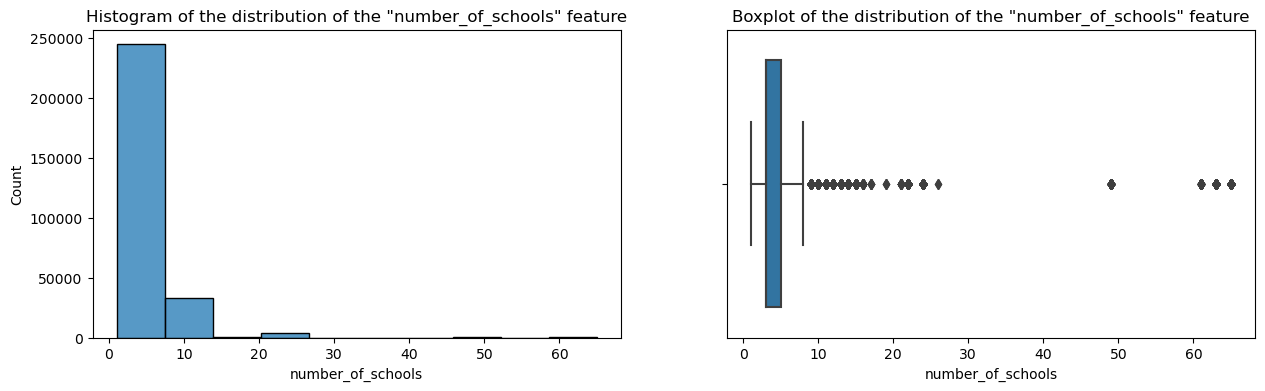

In [175]:
# Посмотрим на гистограмму распределения и коробчатую диаграмму признака "number_of_schools".
# Let's look at the histogram of the distribution and boxplot of the "number_of_schools" feature.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_psqm, x='number_of_schools', bins=10, ax=axes[0]);
histplot.set_title('Histogram of the distribution of the "number_of_schools" feature');
boxplot = sns.boxplot(data=cleaned_psqm, x='number_of_schools', ax=axes[1]);
boxplot.set_title('Boxplot of the distribution of the "number_of_schools" feature');

Из полученных графиков видим, что данные признака "number_of_schools" необходимо очистить от выбросов. Теперь отфильтруем выбросы воспользовавшись методом z-отклонений (метод, основанный на правиле трёх сигм - метод сигм), предварительно прологарифмировав данные признака "number_of_schools" (логарифмирование может привести исходное распределение к подобию нормального). Для этого воспользуемся функцией **outliers_z_score**.

Оба метода (метод межквартильного размаха - метод Тьюки и метод z-отклонений - sigma method) разработаны для данных, распределённых приблизительно нормально.

From the resulting graphs we see that the data for the “number_of_schools” feature must be cleared of outliers. Now let’s filter out the outliers using the z-deviation method (a method based on the three-sigma rule - the sigma method), after taking the logarithm of the "number_of_schools" feature data (logarithm can bring the original distribution to resemble a normal one). To do this, we will use the **outliers_z_score** function.

Both methods (interquartile range method - Tukey's method and z-deviation method - sigma method) are developed for data that are approximately normally distributed.

In [176]:
outliers_ns, cleaned_ns = outliers_z_score(cleaned_psqm, 'number_of_schools', log_scale=True)
print(f"Number of outliers according to z-deviation method: {outliers_ns.shape[0]}") # Число выбросов по методу z-отклонений
print(f'Resulting number of records: {cleaned_ns.shape[0]}') # Результирующее число записей
# Number of outliers according to z-deviation method: 4614
# Resulting number of records: 278631

Number of outliers according to z-deviation method: 4614
Resulting number of records: 278631


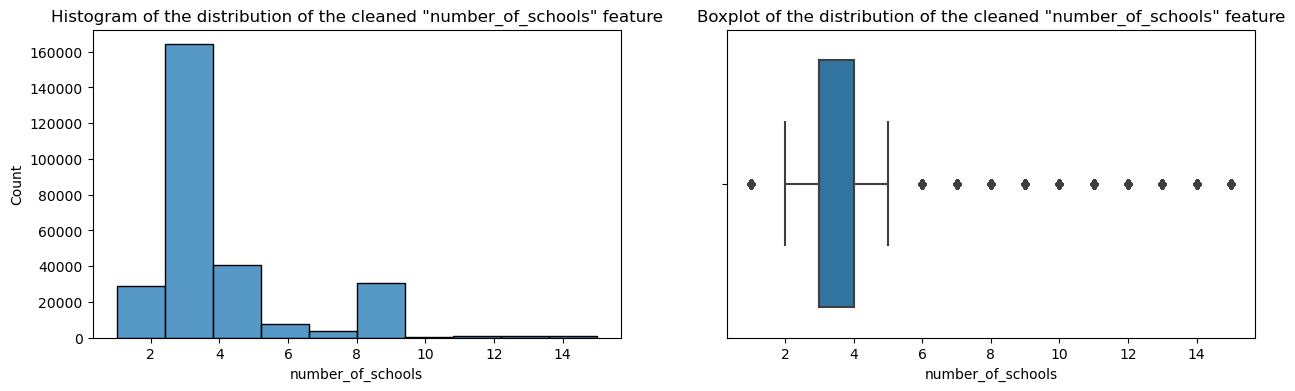

In [177]:
# Посмотрим на гистограмму распределения и коробчатую диаграмму признака "number_of_schools" построенных на данных, очищенных от выбросов.
# Let's look at the distribution histogram and boxplot of the "number_of_schools" feature built on data cleared of outliers.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_ns, x='number_of_schools', bins=10, ax=axes[0]);
histplot.set_title('Histogram of the distribution of the cleaned "number_of_schools" feature');
boxplot = sns.boxplot(data=cleaned_ns, x='number_of_schools', ax=axes[1]);
boxplot.set_title('Boxplot of the distribution of the cleaned "number_of_schools" feature');

In [178]:
cleaned_ns['number_of_schools'].describe()

count    278631.000000
mean          3.897409
std           1.980645
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max          15.000000
Name: number_of_schools, dtype: float64

In [179]:
num_cols.append('number_of_schools')

3. Извлечем данные cреднего расстояния до школ в милях и создадим новый признак **'average_distance_to_school'**.

Let's extract the data on the average distance to schools in miles and create a new attribute **'average_distance_to_school'**.

In [180]:
cleaned_ns['average_distance_to_school'] = cleaned_ns['schools'].apply(lambda x: x['Distance'])

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\1181710767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_ns['average_distance_to_school'] = cleaned_ns['schools'].apply(lambda x: x['Distance'])


In [181]:
cleaned_ns['average_distance_to_school'].head(3)

0    [2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...
1                             [1.65mi, 1.32mi, 1.01mi]
2                      [1.05mi, 0.1mi, 1.05mi, 0.81mi]
Name: average_distance_to_school, dtype: object

In [182]:
# Извлечём числовые показатели и посчитаем среднее расстояние до рядом расположенных школ.
# Let's extract numerical indicators and calculate the average distance to nearby schools.
pattern = re.compile('\d+[.]\d+')
# Создаем функцию, которая извлекает числа из строки и возвращает среднее значение
# Create a function that extracts numbers from a string and returns the average value
def process_row(row):
    sum_distances = 0
    count = 0
    for item in row:
        if (len(pattern.findall(item)) != 0) and ('None' not in item):
            sum_distances += float(pattern.findall(item)[0])
            count += 1
    if count == 0:
        return 0
    else:
        return round(sum_distances / count, 1)
# Применим эту функцию ко всем значениям признака 'average_distance_to_school'
# Apply this function to all values in the 'average_distance_to_school' feature
cleaned_ns['average_distance_to_school'] = cleaned_ns['average_distance_to_school'].apply(process_row)

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\1643501995.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_ns['average_distance_to_school'] = cleaned_ns['average_distance_to_school'].apply(process_row)


In [183]:
print('Proportion of gaps in the "average_distance_to_school" feature: {:.2f}%.'.format(cleaned_ns['average_distance_to_school'].isnull().mean()*100)) #Доля пропусков в признаке "average_distance_to_school"
print('Number of gaps in the "average_distance_to_school" feature: {:.0f}.'.format(cleaned_ns['average_distance_to_school'].isnull().sum())) # Количество пропусков в признаке "average_distance_to_school"
print('Number of unique values in the "average_distance_to_school" feature: {:.0f}.'.format(cleaned_ns['average_distance_to_school'].nunique())) #Количество уникальных значений в признаке "average_distance_to_school"

Proportion of gaps in the "average_distance_to_school" feature: 0.00%.
Number of gaps in the "average_distance_to_school" feature: 0.
Number of unique values in the "average_distance_to_school" feature: 315.


In [184]:
cleaned_ns['average_distance_to_school'].describe()

count    278631.000000
mean          2.742800
std           3.847275
min           0.000000
25%           1.000000
50%           1.700000
75%           3.100000
max        1187.500000
Name: average_distance_to_school, dtype: float64

In [185]:
numb_null = cleaned_ns['average_distance_to_school'][cleaned_ns['average_distance_to_school'] == 0].count()
print('В признаке "average_distance_to_school" найдено {} нулевых значений.'.format(numb_null))

В признаке "average_distance_to_school" найдено 2664 нулевых значений.


Заменим нулевые значения в признаке "average_distance_to_school" медианой, округлённой до целого числа.

Let's replace the zero values in the "average_distance_to_school" feature with the median.

In [186]:
# Отфильтруем нули в признаке "average_distance_to_school" и посчитаем медиану
# Filter out the zeros in the "average_distance_to_school" feature and calculate the median
round(cleaned_ns['average_distance_to_school'][cleaned_ns['average_distance_to_school'] != 0].median())

2

In [187]:
# Заменим нулевые значения медианой.
# Replace zero values with median.
cleaned_ns['average_distance_to_school'] = cleaned_ns['average_distance_to_school'].apply(lambda x: 2 if x == 0 else x)

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\2665616290.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_ns['average_distance_to_school'] = cleaned_ns['average_distance_to_school'].apply(lambda x: 2 if x == 0 else x)


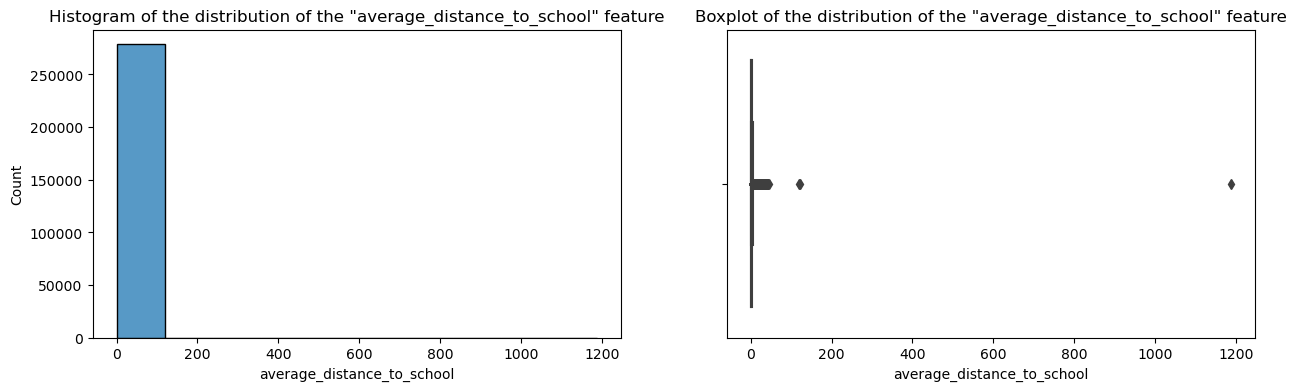

In [188]:
# Посмотрим на гистограмму распределения и коробчатую диаграмму признака "average_distance_to_school".
# Let's look at the histogram of the distribution and boxplot of the "average_distance_to_school" feature.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_ns, x='average_distance_to_school', bins=10, ax=axes[0]);
histplot.set_title('Histogram of the distribution of the "average_distance_to_school" feature');
boxplot = sns.boxplot(data=cleaned_ns, x='average_distance_to_school', ax=axes[1]);
boxplot.set_title('Boxplot of the distribution of the "average_distance_to_school" feature');

Из полученных графиков видим, что данные признака "average_distance_to_school" необходимо очистить от выбросов. Отфильтруем выбросы воспользовавшись методом Тьюки (метод межквартильного размаха). Для этого воспользуемся функцией **outliers_iqr**.

Оба метода (метод межквартильного размаха - метод Тьюки и метод z-отклонений - sigma method) разработаны для данных, распределённых приблизительно нормально.

From the resulting graphs we see that the "average_distance_to_school" feature data must be cleared of outliers.
Let's filter out outliers using Tukey's method (interquartile range method). To do this, we will use the **outliers_iqr** function.

Both methods (interquartile range method - Tukey's method and z-deviation method - sigma method) are developed for data that are approximately normally distributed.

In [189]:
outliers_adst, cleaned_adst = outliers_iqr(cleaned_ns, 'average_distance_to_school')
print(f"Number of outliers according to Tukey's method: {outliers_adst.shape[0]}") # Число выбросов по методу Тьюки
print(f'Resulting number of records: {cleaned_adst.shape[0]}') # Результирующее число записей
# Number of outliers according to Tukey's method: 11312
# Resulting number of records: 267319

Number of outliers according to Tukey's method: 11312
Resulting number of records: 267319


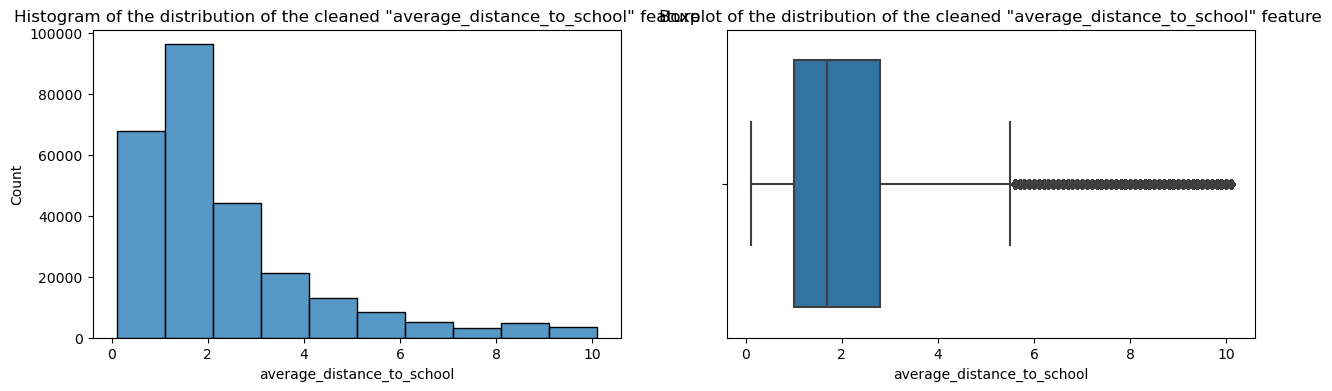

In [190]:
# Посмотрим на гистограмму распределения и коробчатую диаграмму признака "average_distance_to_school" построенных на данных, очищенных от выбросов.
# Let's look at the distribution histogram and boxplot of the "average_distance_to_school" feature built on data cleared of outliers.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_adst, x='average_distance_to_school', bins=10, ax=axes[0]);
histplot.set_title('Histogram of the distribution of the cleaned "average_distance_to_school" feature');
boxplot = sns.boxplot(data=cleaned_adst, x='average_distance_to_school', ax=axes[1]);
boxplot.set_title('Boxplot of the distribution of the cleaned "average_distance_to_school" feature');

In [191]:
cleaned_adst['average_distance_to_school'].describe()

count    267319.000000
mean          2.291806
std           1.914243
min           0.100000
25%           1.000000
50%           1.700000
75%           2.800000
max          10.100000
Name: average_distance_to_school, dtype: float64

In [192]:
num_cols.append('average_distance_to_school')
cleaned_adst.drop('schools', axis = 1, inplace = True)

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\1671416521.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_adst.drop('schools', axis = 1, inplace = True)


### 11. "sqft" feature (living area in square feet)

In [193]:
print('Proportion of gaps in the "sqft" feature: {:.2f}%.'.format(cleaned_adst['sqft'].isnull().mean()*100)) #Доля пропусков в признаке "sqft"
print('Number of gaps in the "sqft" feature: {:.0f}.'.format(cleaned_adst['sqft'].isnull().sum())) # Количество пропусков в признаке "sqft"
print('Number of unique values in the "sqft" feature: {:.0f}.'.format(cleaned_adst['sqft'].nunique())) #Количество уникальных значений в признаке "sqft"

Proportion of gaps in the "sqft" feature: 10.52%.
Number of gaps in the "sqft" feature: 28120.
Number of unique values in the "sqft" feature: 20010.


In [194]:
cleaned_adst['sqft'][(cleaned_adst['sqft'].str.contains(r'[0-9]') == False) | (cleaned_adst['sqft'] == '0')].unique()

array(['0', '-- sqft', '--'], dtype=object)

Преобразуем признак "sqft" в числовой формат и заполним пропуски медианой. Пропусками также будем считать значения '0', '--' и '-- sqft'. Сначала отфильтруем пропуски и все значения, которые считаем пропусками, затем преобразуем признак "sqft" в числовой формат и посчитаем медиану.

Let's convert the "sqft" feature into a number format and fill in the gaps with the median. We will also consider the values '0', '--' and '-- sqft' to be blanks. First, we filter out the gaps and all the values that we consider gaps, then we convert the “sqft” feature into a numeric format and calculate the median.

In [195]:
pattern = re.compile(r'(\d+[,]?\d+)')  # Добавляем скобки для захвата числовых значений
# Фильтруем все значения, которые считаем пропусками
filtered_df = cleaned_adst[(cleaned_adst.sqft != '0') & (cleaned_adst.sqft != '--') & (cleaned_adst.sqft != '-- sqft') & \
                 (pd.notna(cleaned_adst.sqft))]

numeric_values = filtered_df['sqft'].str.extract(pattern, expand=False)
# Убираем запятые
numeric_values = numeric_values.str.replace(',', '').astype(float)  # Преобразуем во float
# Фильтруем NaN значения
numeric_values = numeric_values[~numeric_values.isna()]
median_sqft = round(np.median(numeric_values))
print(median_sqft)

1863


Заменим пропуски и значения '0', '--' и '-- sqft' на значение '1863'.

Replace the gaps and values '0', '--' and '-- sqft' with the value '1863'.

In [196]:
cleaned_adst['sqft'] = cleaned_adst['sqft'].apply(lambda x: str(median_sqft) if (x == '0') | (x == '--') | (x == '-- sqft') | (pd.isna(x) == True) else x)
cleaned_adst['sqft'].isnull().sum()

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\3292295540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_adst['sqft'] = cleaned_adst['sqft'].apply(lambda x: str(median_sqft) if (x == '0') | (x == '--') | (x == '-- sqft') | (pd.isna(x) == True) else x)


0

In [197]:
cleaned_adst['sqft'][(cleaned_adst['sqft'].str.contains(r'[0-9]') == False) | (cleaned_adst['sqft'] == '0')].unique()

array([], dtype=object)

In [198]:
pattern = re.compile('\d+[,]?\d+')
# Выделяем числовые значения
cleaned_adst['sqft'] = cleaned_adst['sqft'].apply(lambda x: str(median_sqft) if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])
# Убираем запятые
cleaned_adst['sqft'] = cleaned_adst['sqft'].apply(lambda x: x.replace(',', ''))
# Переводим в числовой формат
cleaned_adst['sqft'] = cleaned_adst['sqft'].apply(lambda x: int(x))
# Приводим всё к размерности [кв.м.]
cleaned_adst['sqm'] = cleaned_adst['sqft'].apply(lambda x: round(x/10.764))

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\1383615450.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_adst['sqft'] = cleaned_adst['sqft'].apply(lambda x: str(median_sqft) if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])
C:\Users\USER\AppData\Local\Temp\ipykernel_9932\1383615450.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_adst['sqft'] = cleaned_adst['sqft'].apply(lambda x: x.replace(',', ''))
C:\Users\USER\AppData\Local\Temp\ipykernel_9932\1383615450.py:7: SettingW

In [199]:
# Удалим столбец sqft, так как он больше не нужен.
# Let's delete the sqft column since it is no longer needed.
cleaned_adst.drop('sqft', axis = 1, inplace = True)

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\3325857628.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_adst.drop('sqft', axis = 1, inplace = True)


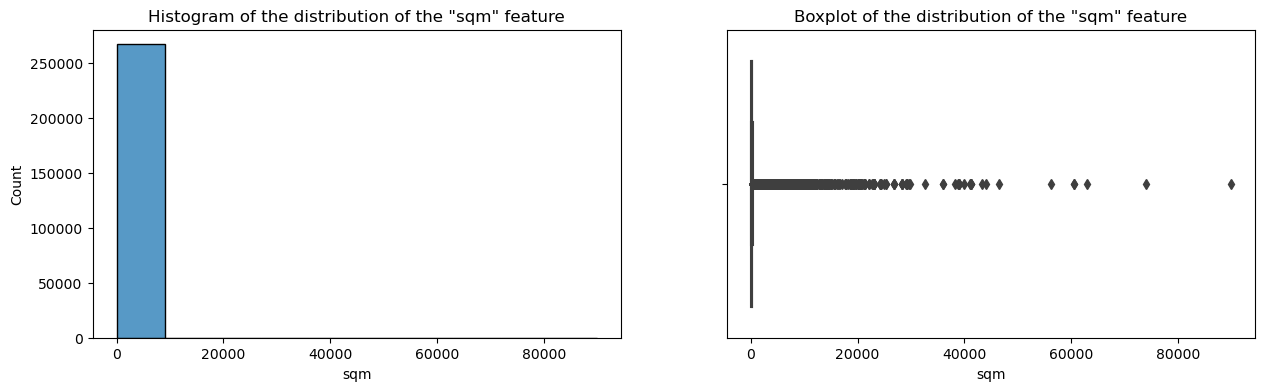

In [200]:
# Посмотрим на гистограмму распределения и коробчатую диаграмму признака "sqm".
# Let's look at the histogram of the distribution and boxplot of the "sqm" feature.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_adst, x='sqm', bins=10, ax=axes[0]);
histplot.set_title('Histogram of the distribution of the "sqm" feature');
boxplot = sns.boxplot(data=cleaned_adst, x='sqm', ax=axes[1]);
boxplot.set_title('Boxplot of the distribution of the "sqm" feature');

In [201]:
cleaned_adst['sqm'].describe()

count    267319.000000
mean        213.772474
std         658.285693
min           5.000000
25%         132.000000
50%         173.000000
75%         227.000000
max       89864.000000
Name: sqm, dtype: float64

Из полученных графиков видим, что данные признака "sqm" необходимо очистить от выбросов. Отфильтруем выбросы воспользовавшись методом Тьюки (метод межквартильного размаха). Для этого воспользуемся функцией **outliers_iqr**.

Оба метода (метод межквартильного размаха - метод Тьюки и метод z-отклонений - sigma method) разработаны для данных, распределённых приблизительно нормально.

From the resulting graphs we see that the "sqm" feature data must be cleared of outliers.
Let's filter out outliers using Tukey's method (interquartile range method). To do this, we will use the **outliers_iqr** function.

Both methods (interquartile range method - Tukey's method and z-deviation method - sigma method) are developed for data that are approximately normally distributed.

In [202]:
outliers_sqmt, cleaned_sqmt = outliers_iqr(cleaned_adst, 'sqm')
print(f"Number of outliers according to Tukey's method: {outliers_sqmt.shape[0]}") # Число выбросов по методу Тьюки
print(f'Resulting number of records: {cleaned_sqmt.shape[0]}') # Результирующее число записей
# Number of outliers according to Tukey's method: 6988
# Resulting number of records: 260331

Number of outliers according to Tukey's method: 6988
Resulting number of records: 260331


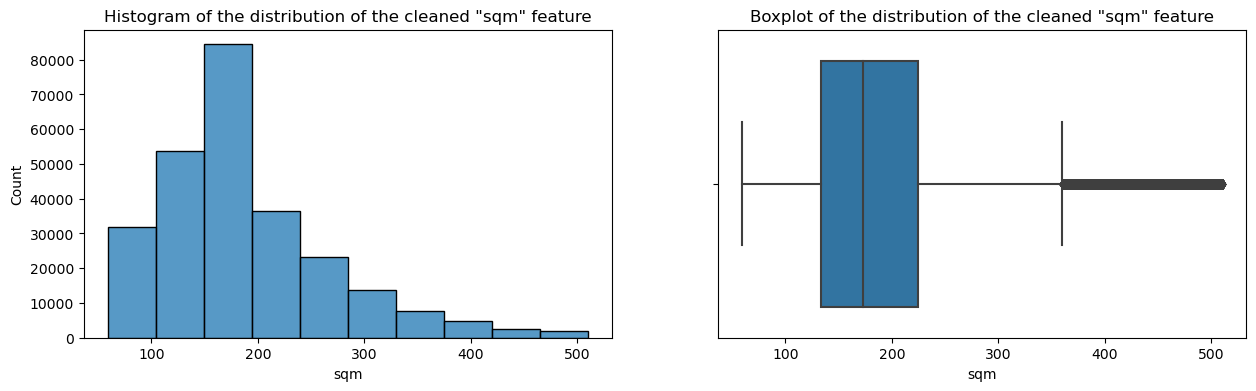

In [203]:
# Посмотрим на гистограмму распределения и коробчатую диаграмму признака "sqm" построенных на данных, очищенных от выбросов.
# Let's look at the distribution histogram and boxplot of the "sqm" feature built on data cleared of outliers.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_sqmt, x='sqm', bins=10, ax=axes[0]);
histplot.set_title('Histogram of the distribution of the cleaned "sqm" feature');
boxplot = sns.boxplot(data=cleaned_sqmt, x='sqm', ax=axes[1]);
boxplot.set_title('Boxplot of the distribution of the cleaned "sqm" feature');

In [204]:
num_cols.append('sqm')

### 12. "zipcode" feature (living area in square feet)

In [205]:
print('Proportion of gaps in the "zipcode" feature: {:.2f}%.'.format(cleaned_sqmt['zipcode'].isnull().mean()*100)) #Доля пропусков в признаке "zipcode"
print('Number of gaps in the "zipcode" feature: {:.0f}.'.format(cleaned_sqmt['zipcode'].isnull().sum())) # Количество пропусков в признаке "zipcode"
print('Number of unique values in the "zipcode" feature: {:.0f}.'.format(cleaned_sqmt['zipcode'].nunique())) #Количество уникальных значений в признаке "zipcode"

Proportion of gaps in the "zipcode" feature: 0.00%.
Number of gaps in the "zipcode" feature: 0.
Number of unique values in the "zipcode" feature: 4122.


In [206]:
# Осуществим проверку на неинформативность признака "zipcode"
# список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in cleaned_sqmt[['zipcode']].columns:
    #наибольшая относительная частота в признаке
    top_freq = cleaned_sqmt[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = cleaned_sqmt[col].nunique() / cleaned_sqmt[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений - признак неинформативный')
    else:
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений - признак информативный')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений - признак неинформативный')
    else:
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений - признак информативный')

zipcode: 0.74% одинаковых значений - признак информативный
zipcode: 1.58% уникальных значений - признак информативный


In [207]:
cleaned_sqmt['zipcode'].value_counts(normalize=True, ascending=False).cumsum()[:300]

32137    0.007360
78245    0.012626
34759    0.017605
78253    0.022287
78254    0.026908
           ...   
33619    0.423453
11235    0.424287
33625    0.425116
60142    0.425946
37205    0.426776
Name: zipcode, Length: 300, dtype: float64

In [208]:
cat_cols.append('zipcode')

### 13. "beds" feature (number of bedrooms)

In [209]:
print('Proportion of gaps in the "beds" feature: {:.2f}%.'.format(cleaned_sqmt['beds'].isnull().mean()*100)) #Доля пропусков в признаке "beds"
print('Number of gaps in the "beds" feature: {:.0f}.'.format(cleaned_sqmt['beds'].isnull().sum())) # Количество пропусков в признаке "beds"
print('Number of unique values in the "beds" feature: {:.0f}.'.format(cleaned_sqmt['beds'].nunique())) #Количество уникальных значений в признаке "beds"

Proportion of gaps in the "beds" feature: 22.13%.
Number of gaps in the "beds" feature: 57611.
Number of unique values in the "beds" feature: 1074.


In [210]:
cleaned_sqmt['beds'].unique()

array(['4', '3 Beds', nan, ..., '2.72 acres', '9,565 sqft', '8,479 sqft'],
      dtype=object)

In [211]:
cleaned_sqmt['beds'][(cleaned_sqmt['beds'].str.contains(r'Bed') == True)].unique()

array(['3 Beds', '4 Beds', '2 Beds', '5 Beds', '12 Beds', '6 Beds',
       '8 Beds', '7 Beds', '9 Beds', '10 Beds', '64 Beds', '11 Beds',
       '16 Beds',
       '1 Bath, 2 Bedrooms, Living Room, Range/Oven, Refrigerator',
       '18 Beds', '15 Beds', '23 Beds', '44 Beds', '13 Beds', '14 Beds',
       '40 Beds', '34 Beds',
       '1 Bath, 2 Bedrooms, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator',
       '3 or More Bedrooms, Dining Room, Living Room, Range/Oven, Refrigerator',
       '24 Beds',
       '1 Bath, 3 or More Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator',
       '42 Beds',
       '1 Bath, 2 Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room',
       '20 Beds'], dtype=object)

In [212]:
cleaned_sqmt['beds'] = cleaned_sqmt['beds'].replace({'1 Bath, 2 Bedrooms, Living Room, Range/Oven, Refrigerator': '2', '1 Bath, 2 Bedrooms': '2',
                                                     '1 Bath, 2 Bedrooms, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator': '2',
                                                     '3 or More Bedrooms, Dining Room, Living Room, Range/Oven, Refrigerator': '3',
                                                     '1 Bath, 3 or More Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator': '3',
                                                     '1 Bath, 2 Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room': '2',
                                                     '1-2 Beds': '1'})

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\1772669656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_sqmt['beds'] = cleaned_sqmt['beds'].replace({'1 Bath, 2 Bedrooms, Living Room, Range/Oven, Refrigerator': '2', '1 Bath, 2 Bedrooms': '2',


In [213]:
cleaned_sqmt = cleaned_sqmt.fillna(value={'beds': '0'})
cleaned_sqmt['beds'] = cleaned_sqmt['beds'].apply(lambda x: '0' if ('acr' in x) or ('sqft' in x) or (x == '-- bd') else x)

In [214]:
cleaned_sqmt['beds'].unique()

array(['4', '3 Beds', '0', '4 Beds', '3 bd', 'Baths', '4 bd', '2 Beds',
       '3', '2', '2.0', '3.0', '5 Beds', 'Bath', '1', '12 Beds', '5 bd',
       '6 Beds', '2 bd', '6', '14', '6 bd', '5', '4.0', '5.0', ' ',
       '1 bd', '8 Beds', '7 Beds', '8', '1.0', '9 Beds', '9', '10 Beds',
       '10 bd', '6.0', '7', '64 Beds', '0.0', '7 bd', '8 bd', '10', '12',
       '9 bd', '11 Beds', '16 Beds', '8.0', '16', '7.0', '10.0',
       '18 Beds', '11', '14 bd', '12 bd', '20', '15 Beds', '23 Beds',
       '44 Beds', '16 bd', '13.0', '13 Beds', '14 Beds', '18', '13',
       "Based on Redfin's St Johns data, we estimate the home's value is $360,731, which is 2.2% less than its current list price.",
       '40 Beds', '9.0', '12.0', '34 Beds', '15', '17', '11 bd', '18 bd',
       '24 Beds', '34', '42 Beds', '23', '46 bd', '32', '20 Beds'],
      dtype=object)

In [215]:
# Переводим в числовой формат
pattern = re.compile('\d+')
cleaned_sqmt['beds'] = cleaned_sqmt['beds'].apply(lambda x: int(pattern.findall(x)[0]) if len(pattern.findall(x)) > 0 else 0)
cleaned_sqmt['beds'].unique()

array([  4,   3,   0,   2,   5,   1,  12,   6,  14,   8,   7,   9,  10,
        64,  11,  16,  18,  20,  15,  23,  44,  13, 360,  40,  34,  17,
        24,  42,  46,  32], dtype=int64)

Заполним пропуски (за пропуски принимаем все нулевые значения) признака "beds" медианой.

Let's fill in the gaps (we take all zero values as gaps) of the "beds" feature with the median.

In [216]:
# Найдем медиану признака "beds"
beds_med = int(cleaned_sqmt['beds'][cleaned_sqmt['beds'] != 0].median())
print('Median of the "beds" feature: {:.0f}.'.format(beds_med)) # Медиана признака "beds"

Median of the "beds" feature: 3.


In [217]:
cleaned_sqmt['beds'] = cleaned_sqmt['beds'].apply(lambda x: beds_med if x == 0 else x)
cleaned_sqmt['beds'].unique()

array([  4,   3,   2,   5,   1,  12,   6,  14,   8,   7,   9,  10,  64,
        11,  16,  18,  20,  15,  23,  44,  13, 360,  40,  34,  17,  24,
        42,  46,  32], dtype=int64)

In [218]:
cleaned_sqmt['beds'].value_counts(normalize=True, ascending=False).cumsum()[:10]

3     0.589281
4     0.796340
2     0.914520
5     0.969278
6     0.981585
1     0.992471
7     0.995260
8     0.997680
9     0.998540
10    0.999078
Name: beds, dtype: float64

Выделим 5 категорий количества спальных комнат, которые описывают более 98% примеров, остальные назовём "more_than_5".

We will highlight 5 categories of the number of bedrooms, which describe more than 98% of the examples, the rest we will call “more_than_5”.

In [219]:
beds_list = set(cleaned_sqmt['beds'].value_counts().index)
beds_main = set(cleaned_sqmt['beds'].value_counts().index[:5])
beds_to_change = list(beds_list - beds_main)
cleaned_sqmt.loc[cleaned_sqmt['beds'].isin(beds_to_change), 'beds'] = 'more_than_5'

In [220]:
cleaned_sqmt['beds'].value_counts(normalize=True, ascending=False)

3              0.589281
4              0.207059
2              0.118180
5              0.054757
more_than_5    0.018415
6              0.012307
Name: beds, dtype: float64

In [221]:
cat_cols.append('beds')

### 14. "state" feature

In [222]:
print('Proportion of gaps in the "state" feature: {:.2f}%.'.format(cleaned_sqmt['state'].isnull().mean()*100)) #Доля пропусков в признаке "state"
print('Number of gaps in the "state" feature: {:.0f}.'.format(cleaned_sqmt['state'].isnull().sum())) # Количество пропусков в признаке "state"
print('Number of unique values in the "state" feature: {:.0f}.'.format(cleaned_sqmt['state'].nunique())) #Количество уникальных значений в признаке "state"

Proportion of gaps in the "state" feature: 0.00%.
Number of gaps in the "state" feature: 0.
Number of unique values in the "state" feature: 37.


In [223]:
cleaned_sqmt['state'].value_counts(normalize=True, ascending=False).cumsum()[:18]

FL    0.307397
TX    0.568223
CA    0.626936
NC    0.683507
NY    0.731169
TN    0.777526
WA    0.814671
OH    0.843465
NV    0.868805
IL    0.893363
CO    0.911636
GA    0.926866
MI    0.939320
AZ    0.950398
DC    0.959390
OR    0.967995
IN    0.976361
PA    0.982073
Name: state, dtype: float64

Выделим 18 категорий штатов, которые описывают более 98% примеров, остальные назовём "other".

We will highlight 18 categories of states that describe more than 98% of the examples, the rest we will call “other”.

In [224]:
states_list = set(cleaned_sqmt['state'].value_counts().index)
states_main = set(cleaned_sqmt['state'].value_counts().index[:18])
states_to_change = list(states_list - states_main)
cleaned_sqmt.loc[cleaned_sqmt['state'].isin(states_to_change), 'state'] = 'other'

In [225]:
cleaned_sqmt['state'].value_counts(normalize=True, ascending=False).cumsum()

FL       0.307397
TX       0.568223
CA       0.626936
NC       0.683507
NY       0.731169
TN       0.777526
WA       0.814671
OH       0.843465
NV       0.868805
IL       0.893363
CO       0.911636
other    0.929563
GA       0.944793
MI       0.957247
AZ       0.968325
DC       0.977317
OR       0.985922
IN       0.994288
PA       1.000000
Name: state, dtype: float64

In [226]:
cat_cols.append('state')

### 15. "stories" feature (number of floors)

In [227]:
print('Proportion of gaps in the "stories" feature: {:.2f}%.'.format(cleaned_sqmt['stories'].isnull().mean()*100)) #Доля пропусков в признаке "stories"
print('Number of gaps in the "stories" feature: {:.0f}.'.format(cleaned_sqmt['stories'].isnull().sum())) # Количество пропусков в признаке "stories"
print('Number of unique values in the "stories" feature: {:.0f}.'.format(cleaned_sqmt['stories'].nunique())) #Количество уникальных значений в признаке "stories"

Proportion of gaps in the "stories" feature: 37.96%.
Number of gaps in the "stories" feature: 98827.
Number of unique values in the "stories" feature: 269.


In [228]:
cleaned_sqmt['stories'].unique()

array([nan, '2.0', 'One', '2', '1.0', 'Multi/Split', '0.0', '0',
       'One Level', '1', '3', '9.0', '1 Level, Site Built', '3.00', '3.0',
       'One Story', 'Two', '1 Story', '5.0', '2 Story', 'Ranch/1 Story',
       'Condominium', 'Stories/Levels', '2 Level, Site Built', '2 Level',
       '3 Level, Site Built', '4', '22.0', '1.00', '2.00', '6.0', 'Lot',
       '3 Story', 'Three Or More', '1 Level', 'Two Story or More', '23',
       '4.0', '8.0', '16.0', '7.0', '9', '8', '1.50',
       'Split Level w/ Sub', '7', 'Townhouse', '1.5 Story/Basement', '3+',
       '28.0', 'Traditional', '2.5 Story', 'Split Foyer', '2 Stories',
       '2.0000', '1.0000', '1.5 Stories', '2.50', '1.30',
       '2 Story/Basement', 'Split Level', '1.5 Level',
       '2 Or More Stories', '15.0', '4.00', '5', '1.5 Story',
       'Multi-Level', '1.5', 'Other Multi-unit', 'Tri-Level',
       '1 Story/Ranch', '18.0', '19', '6', 'High-Rise', 'Mid-Rise',
       '1 Level, Condo, Site Built', '3 Stories', '4 Story',
 

In [229]:
# Переводим в числовой формат
cleaned_sqmt['stories'] = cleaned_sqmt['stories'].fillna('0')
pattern = re.compile('\d+')
cleaned_sqmt['stories'] = cleaned_sqmt['stories'].apply(lambda x: int(pattern.findall(x)[0]) if len(pattern.findall(x)) > 0 else 0)
cleaned_sqmt['stories'].unique()

array([   0,    2,    1,    3,    9,    5,    4,   22,    6,   23,    8,
         16,    7,   28,   15,   18,   19,   25,   10,   17,   11,   26,
         20,   21,   12,   45,   14,   33,   29,   27,   40,   24,   64,
         57,   55,   13,   52,   50,   48,   43,   36,   34,   30,   56,
         31,   35,   47,   37,   42,   60,   49,   39,   32,   46, 1002,
         63], dtype=int64)

Заполним пропуски (за пропуски принимаем все нулевые значения) признака "stories" медианой.

Let's fill in the gaps (we take all zero values as gaps) of the "stories" feature with the median.

In [230]:
# Найдем медиану признака "stories"
stories_med = int(cleaned_sqmt['stories'][cleaned_sqmt['stories'] != 0].median())
print('Median of the "stories" feature: {:.0f}.'.format(stories_med)) # Медиана признака "stories"

Median of the "stories" feature: 1.


In [231]:
cleaned_sqmt['stories'] = cleaned_sqmt['stories'].apply(lambda x: stories_med if x == 0 else x)
cleaned_sqmt['stories'].unique()

array([   1,    2,    3,    9,    5,    4,   22,    6,   23,    8,   16,
          7,   28,   15,   18,   19,   25,   10,   17,   11,   26,   20,
         21,   12,   45,   14,   33,   29,   27,   40,   24,   64,   57,
         55,   13,   52,   50,   48,   43,   36,   34,   30,   56,   31,
         35,   47,   37,   42,   60,   49,   39,   32,   46, 1002,   63],
      dtype=int64)

In [232]:
cleaned_sqmt['stories'].value_counts(normalize=True, ascending=False).cumsum()[:9]

1    0.728112
2    0.944425
3    0.980114
9    0.987869
4    0.993919
5    0.995679
6    0.997326
8    0.998133
7    0.998817
Name: stories, dtype: float64

Выделим 9 категорий этажей, которые описывают более 99% примеров, остальные назовём "more_than_9".

Let's highlight 9 categories of floors that describe more than 99% of the examples, the rest we'll call "more_than_9".

In [233]:
stories_list = set(cleaned_sqmt['stories'].value_counts().index)
stories_main = set(cleaned_sqmt['stories'].value_counts().index[:9])
stories_to_change = list(stories_list - stories_main)
cleaned_sqmt.loc[cleaned_sqmt['stories'].isin(stories_to_change), 'stories'] = 'more_than_9'

In [234]:
cleaned_sqmt['stories'].value_counts(normalize=True, ascending=False)

1              0.728112
2              0.216313
3              0.035689
9              0.007756
4              0.006050
5              0.001759
6              0.001648
more_than_9    0.001183
8              0.000807
7              0.000684
Name: stories, dtype: float64

In [235]:
cat_cols.append('stories')

### 16. "target" feature - price of the real estate property (target feature that needs to be predicted)

Цена объекта недвижимости (целевой признак, который необходимо спрогнозировать)

In [236]:
print('Proportion of gaps in the "target" feature: {:.2f}%.'.format(cleaned_sqmt['target'].isnull().mean()*100)) #Доля пропусков в признаке "target"
print('Number of gaps in the "target" feature: {:.0f}.'.format(cleaned_sqmt['target'].isnull().sum())) # Количество пропусков в признаке "target"
print('Number of unique values in the "target" feature: {:.0f}.'.format(cleaned_sqmt['target'].nunique())) #Количество уникальных значений в признаке "target"

Proportion of gaps in the "target" feature: 0.74%.
Number of gaps in the "target" feature: 1923.
Number of unique values in the "target" feature: 35690.


Преобразуем признак "target" в числовой формат и заполним пропуски медианой. Сначала отфильтруем пропуски, затем преобразуем признак "target" в числовой формат и посчитаем медиану.

Let's convert the "target" feature into a number format and fill in the gaps with the median. First, we filter out the gaps, then we convert the "target" feature into a numeric format and calculate the median.

In [237]:
pattern = re.compile(r'(\d{1,3}(?:,\d{3})*)')  # Добавляем скобки для захвата числовых значений
# Фильтруем пропуски
filtered_df = cleaned_sqmt[pd.isna(cleaned_sqmt.target) != True]
numeric_values = filtered_df['target'].str.extract(pattern, expand=False)
# Убираем запятые
numeric_values = numeric_values.str.replace(',', '').astype(float)  # Преобразуем во float
# Фильтруем NaN значения
numeric_values = numeric_values[~numeric_values.isna()]
median_target = round(np.median(numeric_values))
print(median_target)
# 300000

300000


Заменим пропуски на значение '0' и далее отфильтруем, как выбросы.

Let's replace the gaps with the value '0' and then filter them as outliers.

In [238]:
cleaned_sqmt['target'] = cleaned_sqmt['target'].fillna('0')

In [239]:
pattern = re.compile(r'(\d{1,3}(?:,\d{3})*)') 
# Выделяем цифровые показатели
cleaned_sqmt['target'] = cleaned_sqmt['target'].apply(lambda x: '0' if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])
# Убираем запятые
cleaned_sqmt['target'] = cleaned_sqmt['target'].apply(lambda x: x.replace(',', ''))
# Переводим в числовой формат
cleaned_sqmt['target'] = cleaned_sqmt['target'].apply(lambda x: int(x))

In [240]:
cleaned_sqmt[cleaned_sqmt['target'] > 0].groupby('propertyType')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
propertyType,,,,,,,,
CoNdo/TownHouse,5563.0,3.838240e+05,2.793129e+05,1800.0,208900.0,315000.0,475000.0,5000000.0
Condo,22875.0,4.385444e+05,6.587764e+05,1.0,185000.0,325000.0,545000.0,42500000.0
Cooperative,1239.0,1.364983e+06,5.722650e+06,49000.0,249994.5,349000.0,499000.0,65000000.0
Multi Family Home,7109.0,6.922642e+05,6.129996e+05,750.0,259900.0,549999.0,948000.0,10000000.0
Single-Family home,147036.0,4.111067e+05,3.671221e+05,1.0,216500.0,314169.0,479900.0,30000000.0
contemporary,2865.0,5.025235e+05,3.993897e+05,22500.0,269900.0,390000.0,579900.0,6500000.0
lot/land,15094.0,1.598903e+05,4.937165e+05,600.0,18000.0,43500.0,140000.0,25000000.0
manufactured home,2076.0,1.394955e+05,9.173146e+04,5900.0,79950.0,119900.0,169900.0,925000.0
other,40640.0,7.012148e+05,2.013814e+06,1.0,165000.0,309000.0,599000.0,87000000.0


Присвоим нулевые значения данным, которые сильно отличаются от рыночных цен.

Let's assign zero values to data that is very different from market prices.

In [241]:
cleaned_sqmt['target'] = np.where((cleaned_sqmt['target'] < 5000) & (cleaned_sqmt['propertyType'] == 'lot/land'), 0, cleaned_sqmt['target'])
cleaned_sqmt['target'] = np.where((cleaned_sqmt['target'] < 15000) & (cleaned_sqmt['propertyType'] != 'lot/land'), 0, cleaned_sqmt['target'])

In [242]:
cleaned_sqmt[cleaned_sqmt['target'] > 0].groupby('propertyType')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
propertyType,,,,,,,,
CoNdo/TownHouse,5561.0,3.839612e+05,2.792695e+05,16900.0,208900.0,315000.0,475000.0,5000000.0
Condo,22859.0,4.388499e+05,6.589056e+05,19403.0,185000.0,325000.0,545000.0,42500000.0
Cooperative,1239.0,1.364983e+06,5.722650e+06,49000.0,249994.5,349000.0,499000.0,65000000.0
Multi Family Home,6940.0,7.090170e+05,6.108294e+05,15000.0,277650.0,560000.0,950000.0,10000000.0
Single-Family home,145721.0,4.147949e+05,3.667067e+05,15000.0,219900.0,315000.0,483500.0,30000000.0
contemporary,2865.0,5.025235e+05,3.993897e+05,22500.0,269900.0,390000.0,579900.0,6500000.0
lot/land,14684.0,1.642526e+05,4.998618e+05,5000.0,19900.0,45000.0,149000.0,25000000.0
manufactured home,2050.0,1.411349e+05,9.114080e+04,15500.0,80000.0,119900.0,169900.0,925000.0
other,39363.0,7.236942e+05,2.042286e+06,15000.0,179000.0,319990.0,610000.0,87000000.0


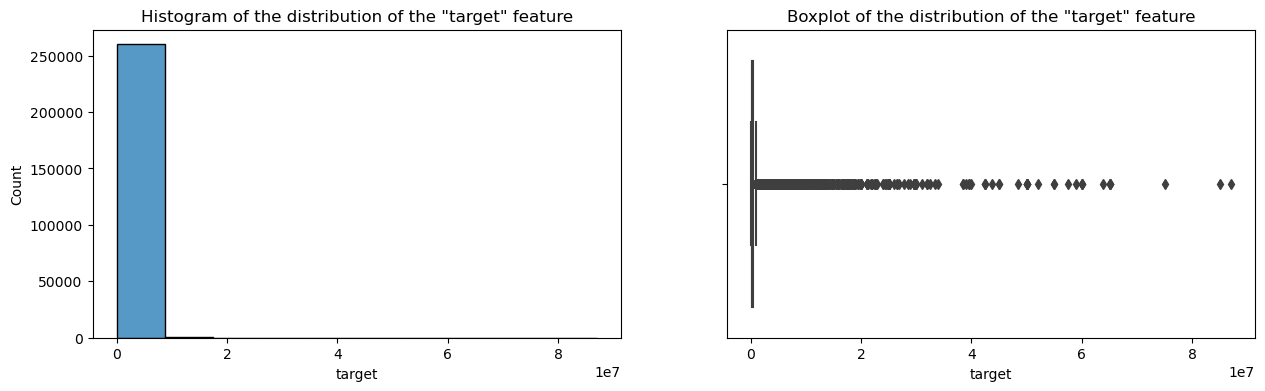

In [243]:
# Посмотрим на гистограмму распределения и коробчатую диаграмму признака "target".
# Let's look at the histogram of the distribution and boxplot of the "target" feature.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_sqmt, x='target', bins=10, ax=axes[0]);
histplot.set_title('Histogram of the distribution of the "target" feature');
boxplot = sns.boxplot(data=cleaned_sqmt, x='target', ax=axes[1]);
boxplot.set_title('Boxplot of the distribution of the "target" feature');

In [244]:
cleaned_sqmt['target'].describe()

count    2.603310e+05
mean     4.520909e+05
std      9.834130e+05
min      0.000000e+00
25%      1.890000e+05
50%      2.999000e+05
75%      4.950000e+05
max      8.700000e+07
Name: target, dtype: float64

In [245]:
cleaned_sqmt['target'][cleaned_sqmt['target'] == 0].count()
# 5189

5189

Из полученных графиков видим, что данные признака "target" необходимо очистить от выбросов. Отфильтруем выбросы воспользовавшись методом Тьюки (метод межквартильного размаха). Для этого воспользуемся функцией **outliers_iqr**.

Оба метода (метод межквартильного размаха - метод Тьюки и метод z-отклонений - sigma method) разработаны для данных, распределённых приблизительно нормально.

From the resulting graphs we see that the "target" feature data must be cleared of outliers.
Let's filter out outliers using Tukey's method (interquartile range method). To do this, we will use the **outliers_iqr** function.

Both methods (interquartile range method - Tukey's method and z-deviation method - sigma method) are developed for data that are approximately normally distributed.

In [246]:
outliers_targt, cleaned_targt = outliers_iqr(cleaned_sqmt, 'target')
print(f"Number of outliers according to Tukey's method: {outliers_targt.shape[0]}") # Число выбросов по методу Тьюки
print(f'Resulting number of records: {cleaned_targt.shape[0]}') # Результирующее число записей
# Number of outliers according to Tukey's method: 18870
# Resulting number of records: 241461

Number of outliers according to Tukey's method: 18870
Resulting number of records: 241461


In [247]:
cleaned_targt['target'][cleaned_targt['target'] == 0].count()
# 0

0

In [248]:
cleaned_targt['target'].describe()

count    2.414610e+05
mean     4.085201e+05
std      3.213097e+05
min      4.461100e+04
25%      2.069900e+05
50%      3.145000e+05
75%      4.990000e+05
max      2.098000e+06
Name: target, dtype: float64

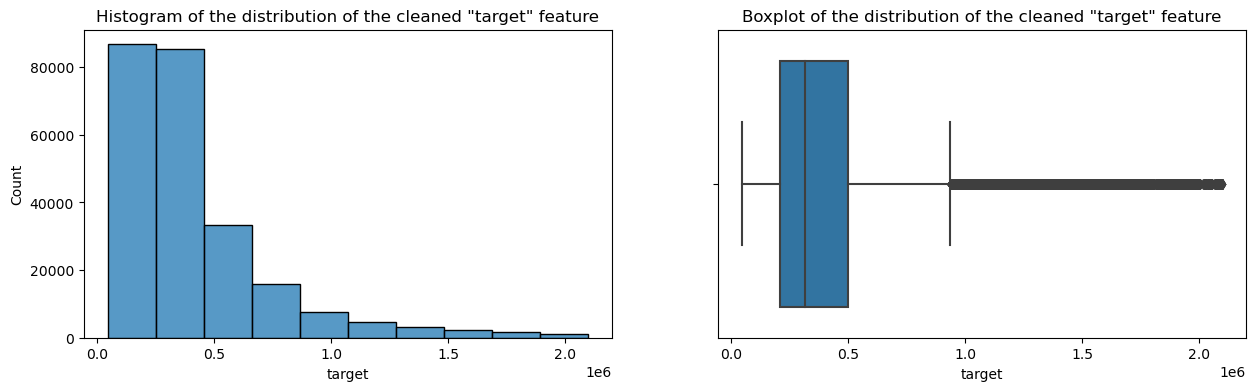

In [249]:
# Посмотрим на гистограмму распределения и коробчатую диаграмму признака "target" построенных на данных, очищенных от выбросов.
# Let's look at the distribution histogram and boxplot of the "target" feature built on data cleared of outliers.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_targt, x='target', bins=10, ax=axes[0]);
histplot.set_title('Histogram of the distribution of the cleaned "target" feature');
boxplot = sns.boxplot(data=cleaned_targt, x='target', ax=axes[1]);
boxplot.set_title('Boxplot of the distribution of the cleaned "target" feature');

In [250]:
num_cols.append('target')

In [251]:
# Осуществим проверку на неинформативность признаков.
# список неинформативных признаков
low_information_cols = [] 
#цикл по всем столбцам
for col in cleaned_targt.columns:
    #наибольшая относительная частота в признаке
    top_freq = cleaned_targt[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = cleaned_targt[col].nunique() / cleaned_targt[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений - признак неинформативный')
    else:
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений - признак информативный')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений - признак неинформативный')
    else:
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений - признак информативный')

propertyType: 59.8% одинаковых значений - признак информативный
propertyType: 0.0% уникальных значений - признак информативный
fireplace: 70.5% одинаковых значений - признак информативный
fireplace: 0.0% уникальных значений - признак информативный
city: 10.04% одинаковых значений - признак информативный
city: 0.12% уникальных значений - признак информативный
zipcode: 0.66% одинаковых значений - признак информативный
zipcode: 1.68% уникальных значений - признак информативный
beds: 56.98% одинаковых значений - признак информативный
beds: 0.0% уникальных значений - признак информативный
state: 29.6% одинаковых значений - признак информативный
state: 0.01% уникальных значений - признак информативный
stories: 71.37% одинаковых значений - признак информативный
stories: 0.0% уникальных значений - признак информативный
PrivatePool: 89.29% одинаковых значений - признак информативный
PrivatePool: 0.0% уникальных значений - признак информативный
target: 0.56% одинаковых значений - признак информа

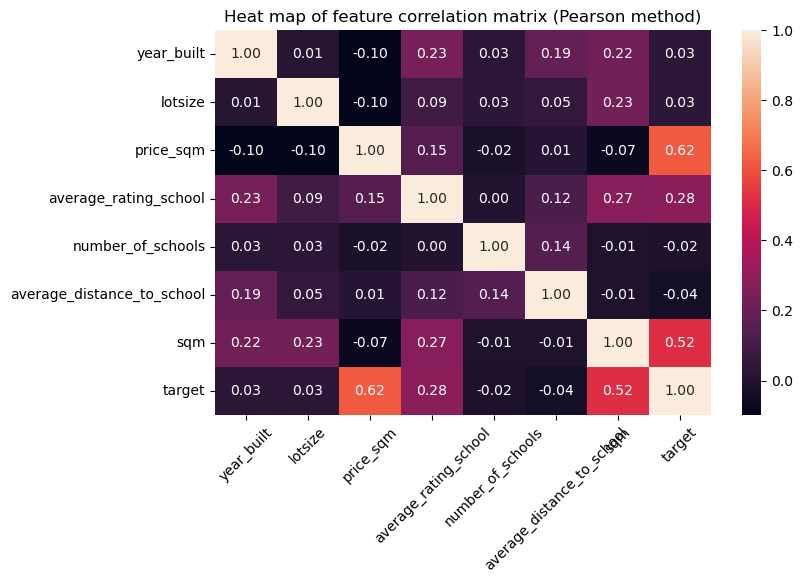

In [252]:
# построим матрицу корреляций методами Пирсона (используют для числовых переменных)
# далее оценим данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(8,5))
corr_mat_p = sns.heatmap(cleaned_targt[num_cols].corr(method='pearson', numeric_only=True), fmt='.2f', annot=True) # center=0)
corr_mat_p.set_title('Heat map of feature correlation matrix (Pearson method)'); # Тепловая карта матрицы корреляций признаков (метод Пирсона)
corr_mat_p.xaxis.set_tick_params(rotation=45)
plt.show() # просмотр графика

Прологарифмируем числовые признаки для того, чтобы сгладить распределение.

In [253]:
for col in num_cols:
    cleaned_targt[col] = np.log(cleaned_targt[col] + 1)
#cleaned_targt['target'] = np.log(cleaned_targt['target'] + 1)

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\1956840980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_targt[col] = np.log(cleaned_targt[col] + 1)


In [254]:
cleaned_targt[num_cols].head(3)

,year_built,lotsize,price_sqm,average_rating_school,number_of_schools,average_distance_to_school,sqm,target
0,7.610853,6.535241,7.346655,1.824549,2.197225,1.871802,5.598422,12.943239
1,7.610853,6.295266,7.445418,1.609438,1.386294,0.832909,5.204007,12.644331
4,7.604396,6.142037,7.164720,1.193922,1.609438,1.568616,4.948760,12.109016


Для каждого числового признака построим гистограмму распределения признака и диаграмму рассеяния, иллюстрирующую зависимость целевого признака от каждого из факторов. Дополнительно поверх диаграммы рассеяния построим уравнение линейной регрессии.

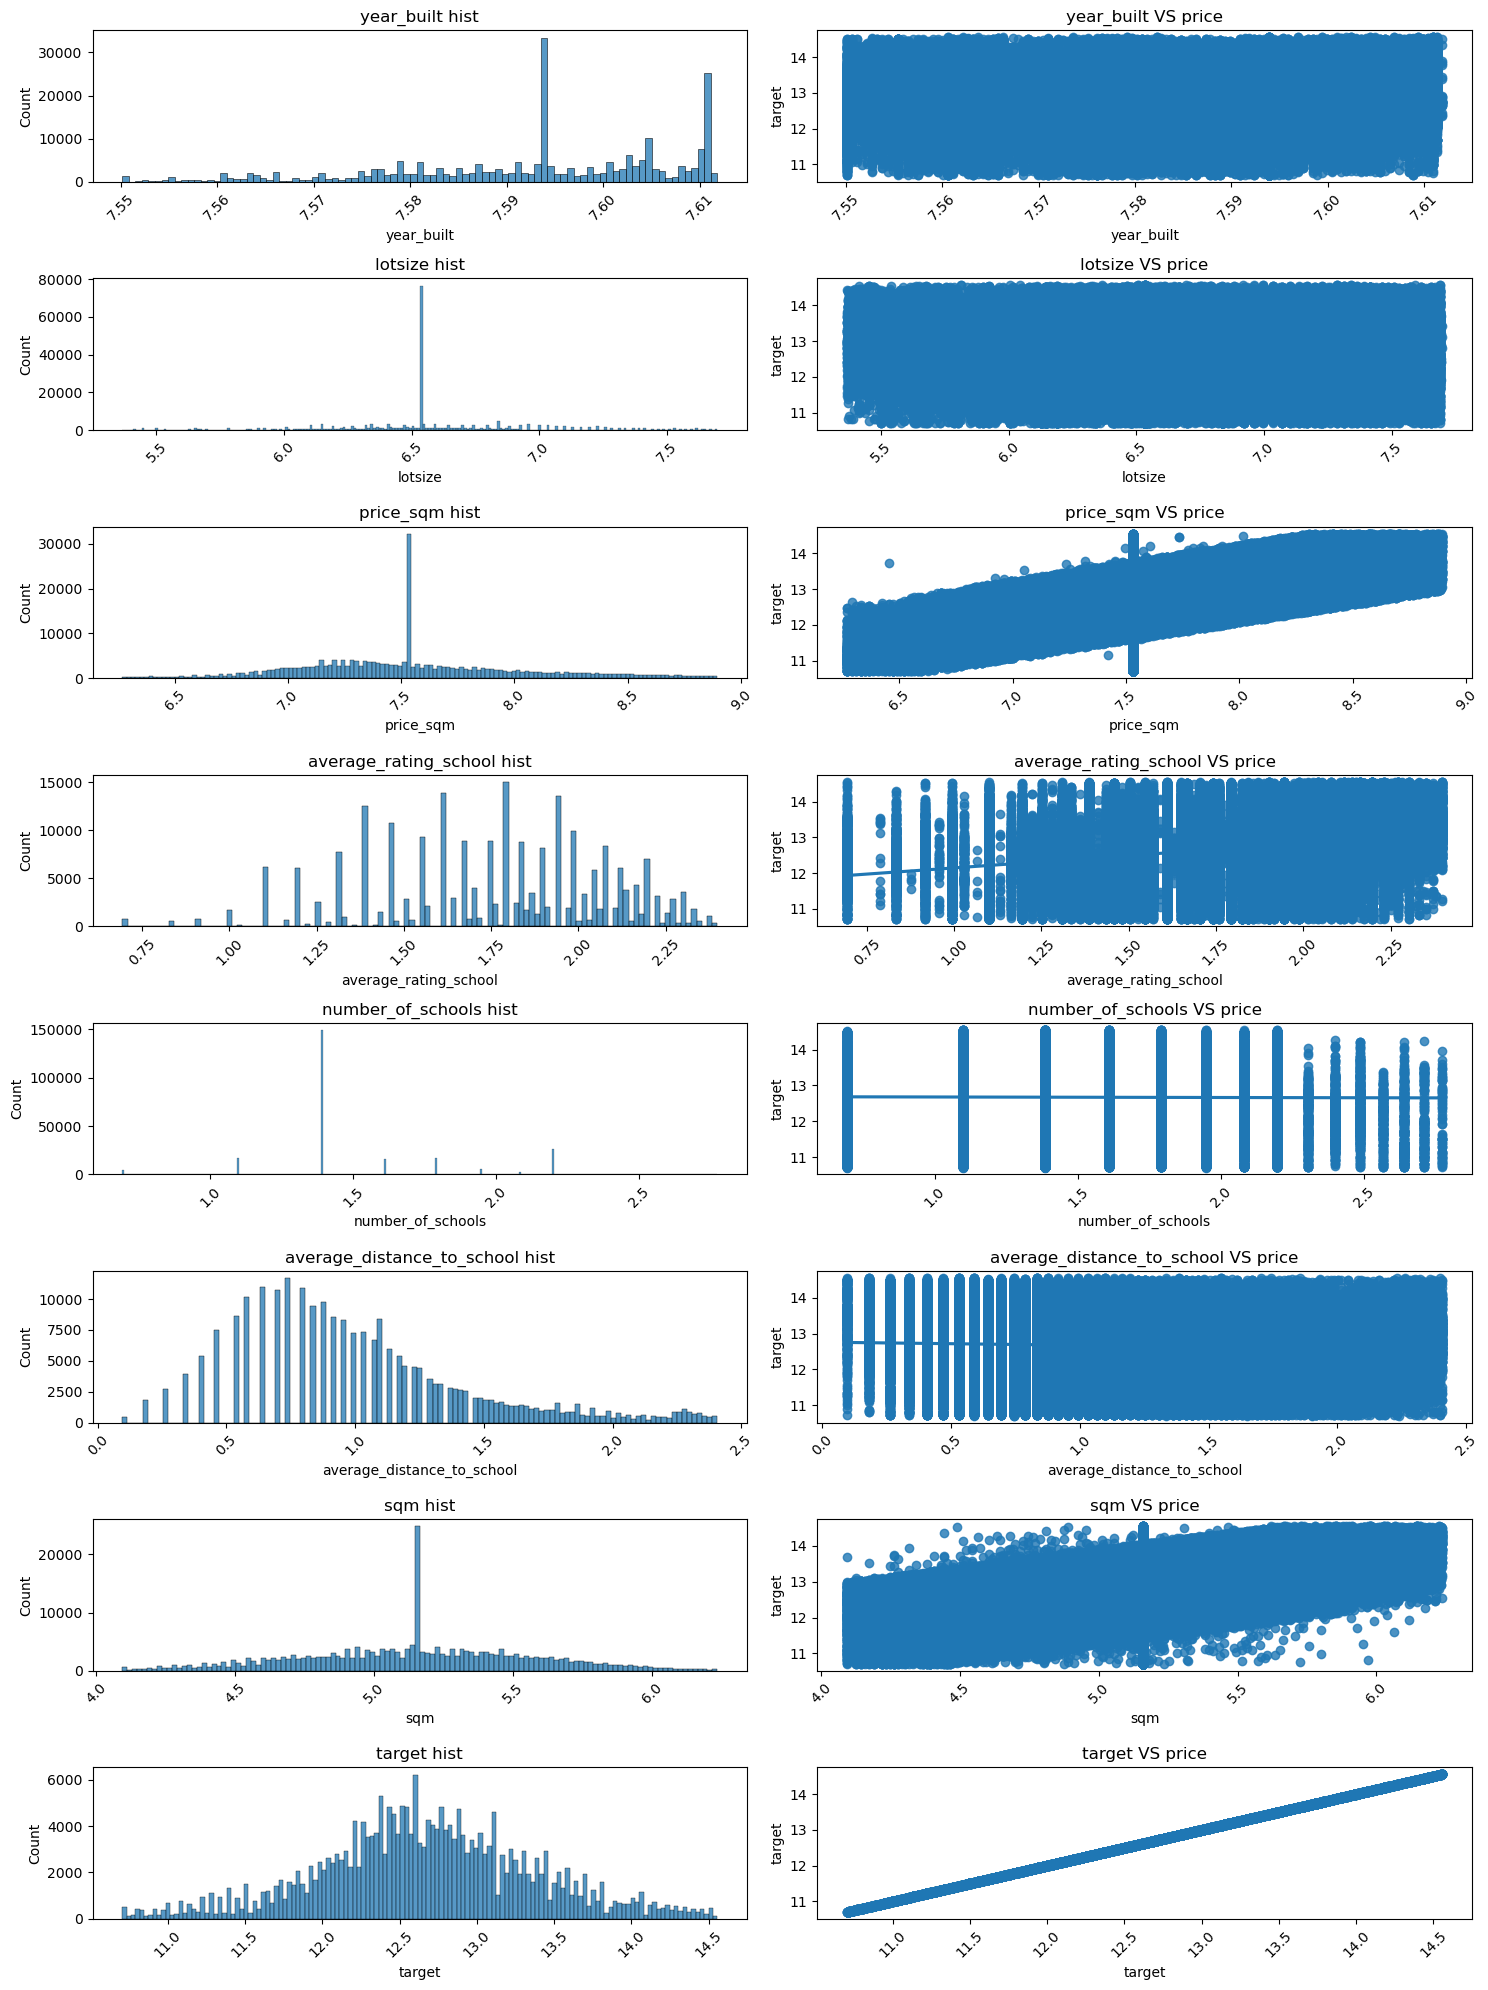

In [255]:
n = len(num_cols) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_cols): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=cleaned_targt, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=cleaned_targt, x=feature, y='target', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS price'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

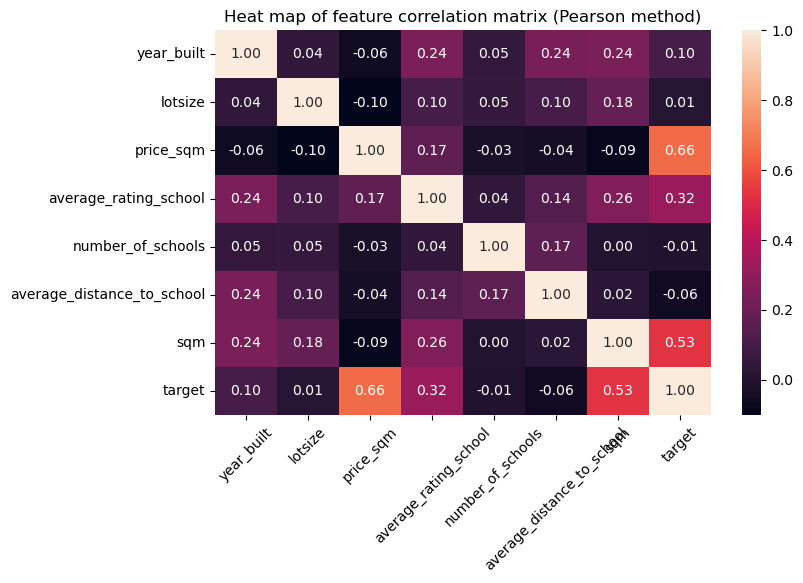

In [256]:
# построим матрицу корреляций методами Пирсона (используют для числовых переменных) после логарифмирования
# далее оценим данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(8,5))
corr_mat_p = sns.heatmap(cleaned_targt[num_cols].corr(method='pearson', numeric_only=True), fmt='.2f', annot=True) # center=0)
corr_mat_p.set_title('Heat map of feature correlation matrix (Pearson method)'); # Тепловая карта матрицы корреляций признаков (метод Пирсона)
corr_mat_p.xaxis.set_tick_params(rotation=45)
plt.show() # просмотр графика

После логарифмирования корреляция признаков практически не изменилась.

#### Обработка категориальных и бинарных переменных (бинарные переменные являются подгруппой категориальных)
Выполним кодирование категориальных и бинарных признаков

In [257]:
print('bin_cols: ', bin_cols)
print('cat_cols: ', cat_cols)
bincat_cols = bin_cols + cat_cols
print('bin_cat_cols: ', bincat_cols)

bin_cols:  ['PrivatePool', 'remodeling', 'cooling', 'fireplace']
cat_cols:  ['propertyType', 'baths_cleared', 'heating', 'parking', 'city', 'zipcode', 'beds', 'state', 'stories']
bin_cat_cols:  ['PrivatePool', 'remodeling', 'cooling', 'fireplace', 'propertyType', 'baths_cleared', 'heating', 'parking', 'city', 'zipcode', 'beds', 'state', 'stories']


In [258]:
cleaned_targt[bin_cols].head(3)

,PrivatePool,remodeling,cooling,fireplace
0,0.0,no,0,yes
1,0.0,no,0,no
4,0.0,yes,1,no


In [259]:
label_encoder = LabelEncoder()

for col in bin_cols:
    cleaned_targt[col] = label_encoder.fit_transform(cleaned_targt[col])
cleaned_targt[bin_cols].head(3)

C:\Users\USER\AppData\Local\Temp\ipykernel_9932\3085749796.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_targt[col] = label_encoder.fit_transform(cleaned_targt[col])
C:\Users\USER\AppData\Local\Temp\ipykernel_9932\3085749796.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_targt[col] = label_encoder.fit_transform(cleaned_targt[col])
C:\Users\USER\AppData\Local\Temp\ipykernel_9932\3085749796.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,PrivatePool,remodeling,cooling,fireplace
0,0,0,0,1
1,0,0,0,0
4,0,1,1,0


In [260]:
cleaned_targt[bin_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241461 entries, 0 to 283244
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   PrivatePool  241461 non-null  int64
 1   remodeling   241461 non-null  int32
 2   cooling      241461 non-null  int32
 3   fireplace    241461 non-null  int32
dtypes: int32(3), int64(1)
memory usage: 14.5 MB


In [261]:
cat_cols_more15 = []
cat_cols_less15 = []

for col in cat_cols:
    if cleaned_targt[col].nunique() > 15:
        cat_cols_more15.append(col)
    else:
        cat_cols_less15.append(col)

print("Категориальные признаки с более чем 15 уникальными значениями:", cat_cols_more15)
print("Категориальные признаки с менее чем 15 уникальными значениями:", cat_cols_less15)

Категориальные признаки с более чем 15 уникальными значениями: ['city', 'zipcode', 'state']
Категориальные признаки с менее чем 15 уникальными значениями: ['propertyType', 'baths_cleared', 'heating', 'parking', 'beds', 'stories']


Осуществим метод однократного кодирования (OneHot Encoding) при помощи dummy-кодирования, реализованного в pandas в функции pd.get_dummies(), категориальных переменных, которые содержат менее или равно 15 уникальных значенийи и двоичное кодирование (Binary Encoding) с помощью класса BinaryEncoder библиотеки category_encoders для категориальных переменных, которые содержат более 15 уникальных значений.

In [262]:
# Осуществим метод однократного кодирования (OneHot Encoding) при помощи dummy-кодирования
cleaned_targt_oh = pd.get_dummies(cleaned_targt, columns=cat_cols_less15)
cleaned_targt_oh.head(3)

,fireplace,city,zipcode,state,PrivatePool,target,remodeling,year_built,cooling,lotsize,...,stories_1,stories_2,stories_3,stories_4,stories_5,stories_6,stories_7,stories_8,stories_9,stories_more_than_9
0,1,other,28387,NC,0,12.943239,0,7.610853,0,6.535241,...,1,0,0,0,0,0,0,0,0,0
1,0,other,99216,WA,0,12.644331,0,7.610853,0,6.295266,...,0,1,0,0,0,0,0,0,0,0
4,0,POINCIANA,34759,FL,0,12.109016,1,7.604396,1,6.142037,...,1,0,0,0,0,0,0,0,0,0


In [263]:
# Осуществим метод двоичного кодирования (Binary Encoding) с помощью класса BinaryEncoder библиотеки category_encoders
import category_encoders as ce # импорт для работы с кодировщиком
bin_encoder = ce.BinaryEncoder(cols=cat_cols_more15) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(cleaned_targt_oh[cat_cols_more15])
cleaned_targt_ohlb = pd.concat([cleaned_targt_oh, type_bin], axis=1)
cleaned_targt_ohlb = cleaned_targt_ohlb.drop(columns=cat_cols_more15)
cleaned_targt_ohlb.head(3)

,fireplace,PrivatePool,target,remodeling,year_built,cooling,lotsize,price_sqm,average_rating_school,number_of_schools,...,zipcode_7,zipcode_8,zipcode_9,zipcode_10,zipcode_11,state_0,state_1,state_2,state_3,state_4
0,1,0,12.943239,0,7.610853,0,6.535241,7.346655,1.824549,2.197225,...,0,0,0,0,1,0,0,0,0,1
1,0,0,12.644331,0,7.610853,0,6.295266,7.445418,1.609438,1.386294,...,0,0,0,1,0,0,0,0,1,0
4,0,0,12.109016,1,7.604396,1,6.142037,7.164720,1.193922,1.609438,...,0,0,0,1,1,0,0,0,1,1


In [264]:
cleaned_targt_ohlb.shape
# (241461, 80)

(241461, 80)

In [265]:
cols_new = cleaned_targt_ohlb.columns
cat_cols_new = []
for col in cols_new:
    if col not in num_cols:
        cat_cols_new.append(col)
len(cat_cols_new) + len(num_cols)

80

Теперь оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

Для этого построим матрицу корреляций. Дополним её тепловой картой, отражающей результат.

В качестве дополнения отразим связь факторов с целевым признаком построив столбчатую диаграмму для ранжированных коэффициентов корреляции.

Now let's evaluate multicollinearity and the relationship of features with the target variable.

To do this, we will construct a correlation matrix. Let's supplement it with a heat map reflecting the result.

As an addition, we will reflect the relationship of features with the target attribute by constructing a bar chart for ranked correlation coefficients.

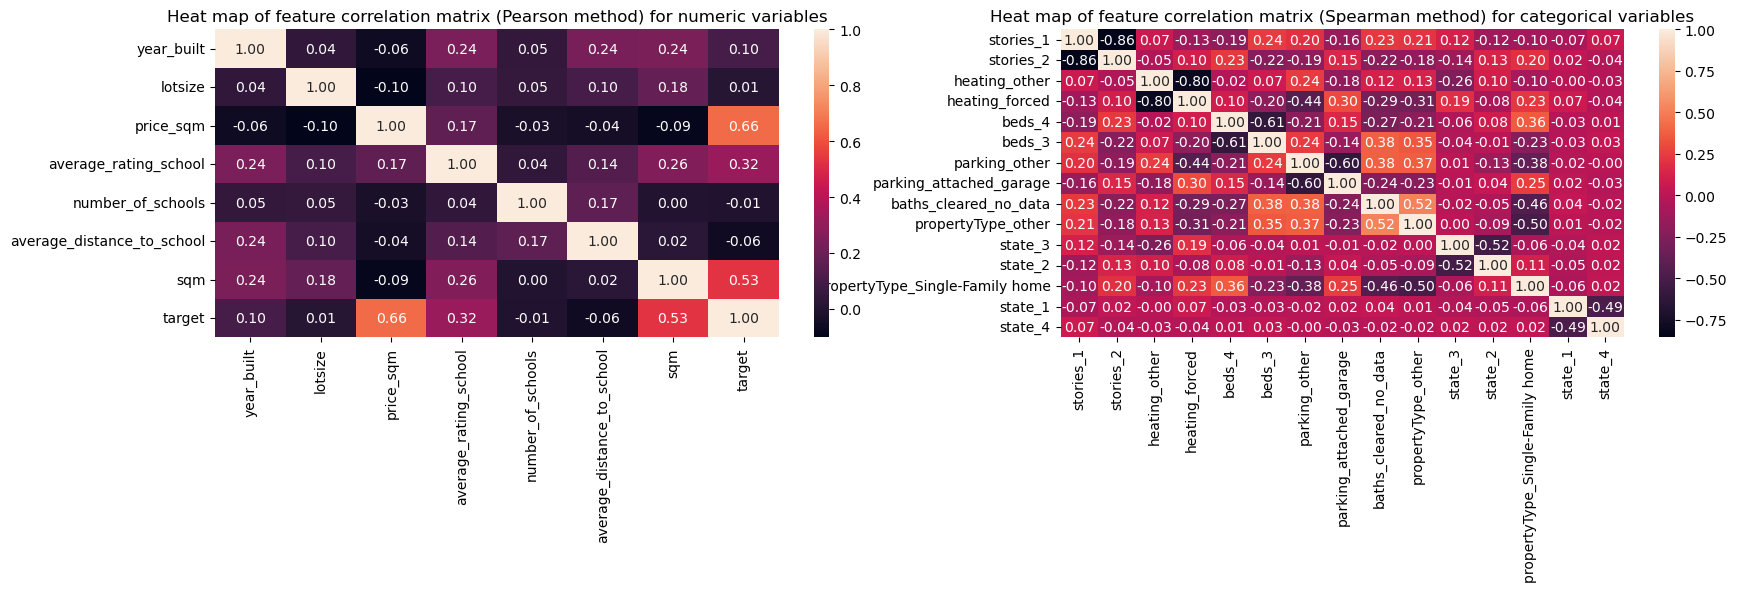

<Figure size 800x500 with 0 Axes>

In [266]:
# построим матрицу корреляций методами Пирсона (используют для числовых переменных) и Спирмена (ипользуют для категориальных переменных) поскольку в 
# нашем датасете имеются числовые, категориальные и бинарные переменные (бинарные переменные являются подгруппой категориальных) и в спорных случаях мы 
# рассматриваем несколько вариантов корреляций
# для матрицы корреляции категориальных признаков возьмем первые 15 признаков по убыванию коэффициента корреляции
# далее оценим данные на предмет наличия мультиколлинеарности
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
plt.figure(figsize=(8,5))
corr_mat_p = sns.heatmap(cleaned_targt_ohlb[num_cols].corr(method='pearson', numeric_only=True), fmt='.2f', annot=True, ax=axes[0]) # center=0)
corr_mat_p.set_title('Heat map of feature correlation matrix (Pearson method) for numeric variables'); # Тепловая карта матрицы корреляций признаков (метод Пирсона)
# corr_mat_p.xaxis.set_tick_params(rotation=45)

corr_mat_cat = cleaned_targt_ohlb[cat_cols_new].corr(method='spearman', numeric_only=True).abs()
cat_feat_15 = corr_mat_cat[corr_mat_cat < 1].max().sort_values(ascending = False).index[:15]
corr_mat_s = sns.heatmap(cleaned_targt_ohlb[cat_feat_15].corr(method='spearman', numeric_only=True), fmt='.2f', annot=True, ax=axes[1])
# cleaned_targt_ohlb.corr(method='spearman', numeric_only=True)['target'].abs().sort_values(ascending=False)[:15]
corr_mat_s.set_title('Heat map of feature correlation matrix (Spearman method) for categorical variables'); # Тепловая карта матрицы корреляций признаков (метод Спирмена)
# corr_mat_s.xaxis.set_tick_params(rotation=45)
# plt.tight_layout() # чтобы графики не наезжали другу на друга, используем tight_layout
plt.show() # просмотр графика

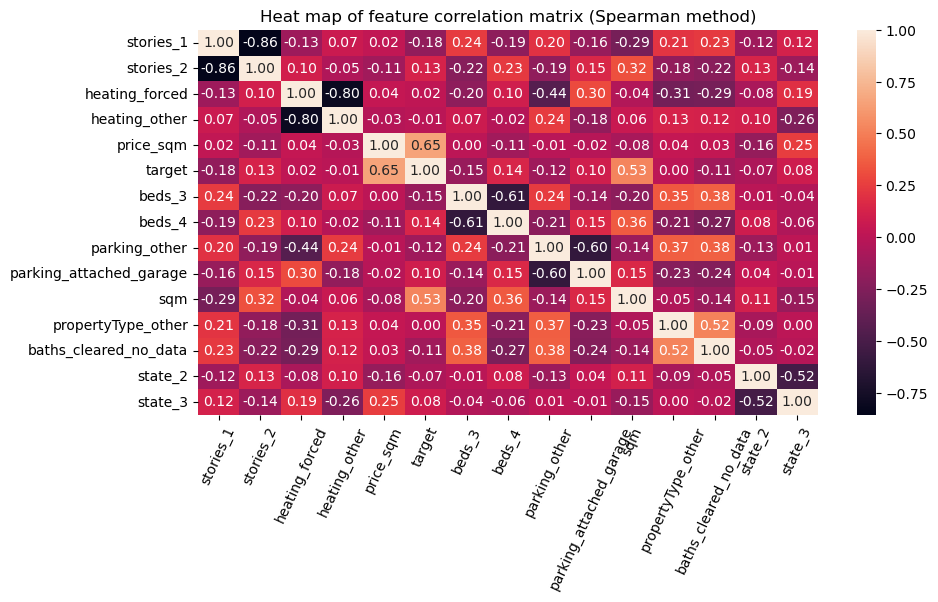

In [267]:
# для полноты построим матрицу корреляций объединив категориальные и числовые переменные. Поскольку признаков много возьмем первые 15 признаков 
# по убыванию коэффициента корреляции
# далее оценим данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(10,5))
corr_mat_catnum = cleaned_targt_ohlb.corr(method='spearman', numeric_only=True).abs()
catnum_feat_15 = corr_mat_catnum[corr_mat_catnum < 1].max().sort_values(ascending = False).index[:15]
corr_mat_catnum = sns.heatmap(cleaned_targt_ohlb[catnum_feat_15].corr(method='spearman', numeric_only=True), fmt='.2f', annot=True)

corr_mat_catnum.set_title('Heat map of feature correlation matrix (Spearman method)');
corr_mat_catnum.xaxis.set_tick_params(rotation=65)
plt.show() # просмотр графика

Проведя корелляционный анализ на построенных матрицах корелляций можно сделать вывод, что в нашем датасете есть мультиколлинеарность (принято считать, что при коэффициенте корреляции +/-0,7 связь между признаками сильная и приводит к мультиколлинеарности) среди следующих признаков: "stories_1" - "stories_2" (коэффициент корреляции - 0.86), "heating_forced" - "heating_other" (коэффициент корреляции - 0.83). Удалим признаки "stories_2" и "heating_other".

Having carried out a correlation analysis on the constructed correlation matrices, we can conclude that in our dataset there is multicollinearity (it is generally accepted that with a correlation coefficient of +/-0.7, the relationship between features is strong and leads to multicollinearity) among the following features: "stories_1" - "stories_2 " (correlation coefficient - 0.86), "heating_forced" - "heating_other" (correlation coefficient - 0.83). Let's remove the features "stories_2" and "heating_other".

In [268]:
cleaned_targt_ohlb = cleaned_targt_ohlb.drop(['stories_2', 'heating_other'], axis=1)

В качестве дополнения отразим связь факторов с целевым признаком построив столбчатую диаграмму для ранжированных коэффициентов корреляции.

As an addition, we will reflect the relationship of features with the target attribute by constructing a bar chart for ranked correlation coefficients.

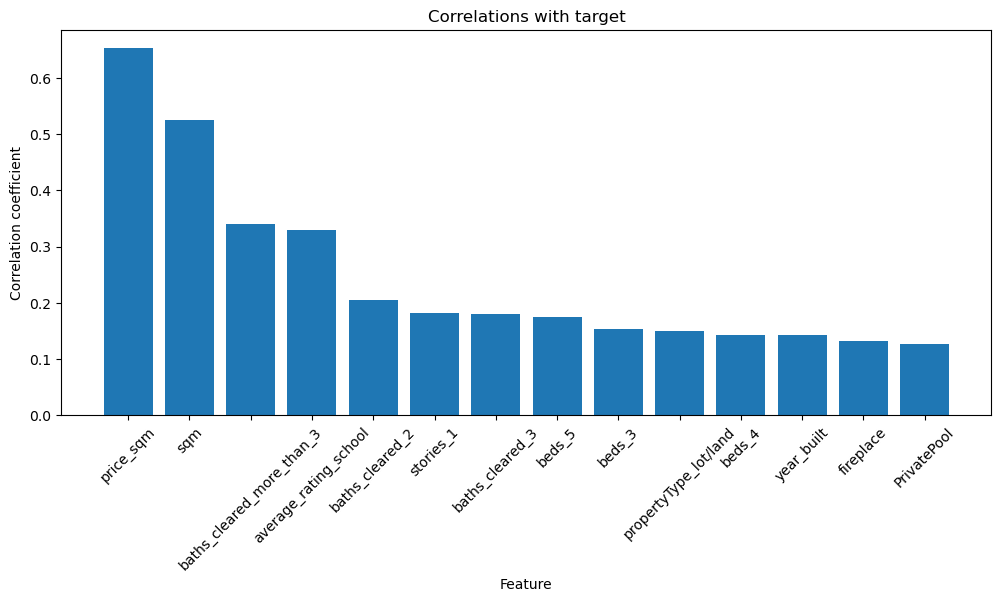

In [269]:
#Вычисляем модуль корреляции
corr_with_target = cleaned_targt_ohlb.corr(method='spearman', numeric_only=True)['target'].abs().sort_values(ascending=False)[:15]
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('target')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(12, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс

In [270]:
# Выгрузим данные в csv для дальнейшего обучения.
cleaned_targt_ohlb.to_csv('data_EDA_lognum.csv', index = False)

In [2]:
cleaned_targt_notnul = pd.read_csv('data_EDA_lognum.csv', sep=',')

In [8]:
cleaned_targt_notnul['target'].describe()

count    241461.000000
mean         12.671390
std           0.706133
min          10.705758
25%          12.240431
50%          12.658743
75%          13.120363
max          14.556496
Name: target, dtype: float64

In [3]:
X = cleaned_targt_notnul.drop('target', axis = 1)
y_log = cleaned_targt_notnul['target']

Разделим данные на обучающую, валидационную и тестовую выборки.

In [4]:
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size = 0.2, shuffle = True, random_state = 42)

Проведем стандартизацию данных с помощью StandardScaler

In [5]:
# проведем стандартизацию данных с помощью StandardScaler с параметрами по умолчанию;
scaler_st = StandardScaler()
X_train_st = scaler_st.fit_transform(X_train)
X_test_st = scaler_st.transform(X_test)
# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
X_train_st = pd.DataFrame(X_train_st, columns=X_train.columns)
X_test_st = pd.DataFrame(X_test_st, columns=X_test.columns)
y_train_log = y_train_log.reset_index(drop=True)
y_test_log = y_test_log.reset_index(drop=True)
X_train_st.head(3)

,fireplace,PrivatePool,remodeling,year_built,cooling,lotsize,price_sqm,average_rating_school,number_of_schools,average_distance_to_school,...,zipcode_7,zipcode_8,zipcode_9,zipcode_10,zipcode_11,state_0,state_1,state_2,state_3,state_4
0,-0.646953,-0.34527,1.175484,0.498051,0.650505,-0.496299,-0.755127,-0.228224,0.823738,1.765496,...,-0.992265,-0.955129,1.002633,0.991176,0.996713,-0.227353,-0.452034,-0.91462,0.975139,0.573166
1,-0.646953,-0.34527,1.175484,-0.856745,0.650505,-0.047055,-0.704873,0.559748,-0.403737,0.363943,...,-0.992265,1.046980,-0.997374,0.991176,0.996713,-0.227353,-0.452034,-0.91462,0.975139,0.573166
2,-0.646953,-0.34527,-0.850714,0.704130,0.650505,-0.078537,2.054486,-0.172509,0.271792,-0.372036,...,1.007796,-0.955129,-0.997374,-1.008902,0.996713,4.398446,-0.452034,-0.91462,0.975139,-1.744696


In [6]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_st[['price_sqm', 'sqm', 'average_rating_school', 'baths_cleared_more_than_3', 'year_built']])
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly_features = poly.transform(X_train_st[['price_sqm', 'sqm', 'average_rating_school', 'baths_cleared_more_than_3', 'year_built']])
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly_features = poly.transform(X_test_st[['price_sqm', 'sqm', 'average_rating_school', 'baths_cleared_more_than_3', 'year_built']])

X_train_poly_features = pd.DataFrame(X_train_poly_features, columns=poly.get_feature_names_out())
X_test_poly_features = pd.DataFrame(X_test_poly_features, columns=poly.get_feature_names_out())
X_train_poly_features = X_train_poly_features.drop(['price_sqm', 'sqm', 'average_rating_school', 'baths_cleared_more_than_3', 'year_built'], 
                                                   axis=1)
X_test_poly_features = X_test_poly_features.drop(['price_sqm', 'sqm', 'average_rating_school', 'baths_cleared_more_than_3', 'year_built'], 
                                                   axis=1)
X_train_poly = pd.concat([X_train_st, X_train_poly_features], axis = 1)
X_test_poly = pd.concat([X_test_st, X_test_poly_features], axis = 1)
#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)
# (193168, 92)
# (48293, 92)

(193168, 92)
(48293, 92)


## <center>2. Моделирование + Оценка модели

Заранее создадим функцию, которая будет расчитывать метрики:

1. MAE - средняя абсолютная ошибка (целевая метрика)
2. MAPE - средняя абсолютная ошибка в процентах 
3. $R^2$ - коэффициент детерминации 

In [7]:
def print_metrics(y_train, y_train_pred, y_test, y_test_pred):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_pred)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_pred)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_pred)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_pred)))
    print('Test MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)*100))

Построим на предобработанных данных модель линейной регрессии аналитическим способом с помощью библиотеки sklearn в модуле которой (linear_model) находится класс LinearRegression.

In [9]:
%%time
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель предсказывать логарифм целевого признака
lr.fit(X_train_poly, y_train_log)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred = (np.exp(lr.predict(X_train_poly)) - 1)
y_test_pred = (np.exp(lr.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.800
Train MAE: 51153.414
Train MAPE: 15.827


Test R^2: 0.808
Test MAE: 50438.313
Test MAPE: 16.058
CPU times: total: 4.2 s
Wall time: 2.32 s


Для удобства составим DataFrame из коэффициентов w_1, w_2, ..., w_i обученной модели, добавив к нему строку со свободным членом w_0:

In [283]:
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': X_train_poly.columns, 'Coefficients': lr.coef_})
#Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lr.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df.head(3))
display(coef_df.tail(3))
coef_df['Coefficients'].describe()

,Features,Coefficients
0,fireplace,0.001897
1,PrivatePool,0.006187
2,remodeling,0.012437


,Features,Coefficients
90,baths_cleared_more_than_3 year_built,-1.302807e-03
91,year_built^2,1.483555e-02
92,INTERCEPT,-1.210004e+09


count    9.300000e+01
mean     1.677139e+10
std      9.972619e+10
min     -2.507480e+11
25%     -9.178632e-03
50%      1.896873e-03
75%      1.483555e-02
max      5.396709e+11
Name: Coefficients, dtype: float64

Из проведенного анализа видим, что некоторые коэффициенты линейной регрессии становятся слишком большими и модель становится неустойчивой. Вероятно причина этой проблемы — мультиколлинеарность факторов, которую мы не обнаружили ранее, используя методы Пирсона и Спирмена при визуализации матрицы корреляции.

В LinearRegression Внешних параметров нет, но данная проблема решается с помощью регуляризации (например, подбором параметра регуляризации α для алгоритма линейной регрессии Ridge). Далее опробуем данный подход, но сначала реализуем численный способ SGDRegressor.

Построим на предобработанных данных модель линейной регрессии численным способом. Будем использовать реализацию стохастического градиентного спуска для линейной регрессии из библиотеки sklearn - SGDRegressor.

In [319]:
#Создаём объект класса линейной регрессии с SGD
lr_sgd = linear_model.SGDRegressor(max_iter=10000, eta0=0.01, random_state=42)
#Обучаем модель — ищем параметры по методу SGD
%time lr_sgd.fit(X_train_poly, y_train_log)
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': X_train_poly.columns, 'Coefficients': lr_sgd.coef_})
#Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lr_sgd.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df.head(3))
display(coef_df.tail(3))
coef_df['Coefficients'].describe()

CPU times: total: 1.09 s
Wall time: 1.21 s


,Features,Coefficients
0,fireplace,-0.000705
1,PrivatePool,0.009621
2,remodeling,0.011946


,Features,Coefficients
90,baths_cleared_more_than_3 year_built,-0.000155
91,year_built^2,0.019552
92,INTERCEPT,11.070336


count    93.000000
mean      0.135773
std       1.223152
min      -3.488823
25%      -0.004662
50%       0.002000
75%       0.007665
max      11.070336
Name: Coefficients, dtype: float64

In [320]:
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)
#Делаем предсказание для каждой из выборок
y_train_pred_sgd = (np.exp(lr_sgd.predict(X_train_poly)) - 1)
y_test_pred_sgd = (np.exp(lr_sgd.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred_sgd, y_test, y_test_pred_sgd)

Train R^2: 0.795
Train MAE: 52388.872
Train MAPE: 15.951


Test R^2: 0.803
Test MAE: 51703.494
Test MAPE: 16.178


Регуляризация присутствует и в модели SGDRegressor, причём она используется по умолчанию. В инициализаторе данного класса есть параметр penalty, который позволяет управлять методом регуляризации. Параметр может принимать значения 'l1', 'l2' и 'elasticnet'. По умолчанию используется L2-регуляризация (penalty='l2'). Коэффициент регуляризации (alpha) по умолчанию равен 0.0001 (относительно слабая регуляризация). Управляя двумя этими параметрами, мы можем настраивать тип регуляризации в SGD-методе и её «силу». Реализуем это на нашем датасете.

In [345]:
#Создаём объект класса линейной регрессии с SGD
lr_sgd = linear_model.SGDRegressor(max_iter=10000, eta0=0.01, penalty='l1', alpha=0.01, random_state=42) # penalty='l2', alpha=0.0001
#Обучаем модель — ищем параметры по методу SGD
%time lr_sgd.fit(X_train_poly, y_train_log)
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': X_train_poly.columns, 'Coefficients': lr_sgd.coef_})
#Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lr_sgd.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df.head(3))
display(coef_df.tail(3))
coef_df['Coefficients'].describe()

CPU times: total: 1.84 s
Wall time: 2.84 s


,Features,Coefficients
0,fireplace,0.0
1,PrivatePool,0.0
2,remodeling,0.0


,Features,Coefficients
90,baths_cleared_more_than_3 year_built,0.000000
91,year_built^2,0.008072
92,INTERCEPT,12.659360


count    93.000000
mean      0.144330
std       1.313440
min      -0.101925
25%       0.000000
50%       0.000000
75%       0.000000
max      12.659360
Name: Coefficients, dtype: float64

In [346]:
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)
#Делаем предсказание для каждой из выборок
y_train_pred_sgd = (np.exp(lr_sgd.predict(X_train_poly)) - 1)
y_test_pred_sgd = (np.exp(lr_sgd.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred_sgd, y_test, y_test_pred_sgd)

Train R^2: 0.800
Train MAE: 44668.493
Train MAPE: 14.580


Test R^2: 0.807
Test MAE: 44210.784
Test MAPE: 14.863


В sklearn методы регуляризации реализованы также в классах Lasso (L1-регуляризация) и Ridge (L2-регуляризация). Оба метода осуществляют поиск параметров с добавлением регуляризации.

Построим модели линейной регрессии с L1 и L2-регуляризацией на сгенерированных нами ранее полиномиальных признаках.

Отличительной особенностью L1-регуляризации является то, что коэффициенты, которые соответствуют «ненужным», по мнению модели, факторам, обнуляются, то есть факторы просто не будут участвовать в предсказании. Это очень важно для сложных моделей, в обучении которых используются множество факторов. Тем самым мы уменьшим сложность модели, сократим её разброс и, как следствие, уменьшим переобучение.

In [288]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr = linear_model.Lasso(alpha=0.01)
#Обучаем модель
%time lasso_lr.fit(X_train_poly, y_train_log)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred_l1 = (np.exp(lasso_lr.predict(X_train_poly)) - 1)
y_test_pred_l1 = (np.exp(lasso_lr.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred_l1, y_test, y_test_pred_l1)

CPU times: total: 969 ms
Wall time: 1 s
Train R^2: 0.800
Train MAE: 45331.281
Train MAPE: 14.743


Test R^2: 0.807
Test MAE: 44850.977
Test MAPE: 15.018


In [289]:
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': X_train_poly.columns, 'Coefficients': lasso_lr.coef_})
#Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lasso_lr.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df.head(3))
display(coef_df.tail(3))
coef_df['Coefficients'].describe()

,Features,Coefficients
0,fireplace,0.0
1,PrivatePool,0.0
2,remodeling,0.0


,Features,Coefficients
90,baths_cleared_more_than_3 year_built,-0.000000
91,year_built^2,0.003255
92,INTERCEPT,12.664197


count    93.000000
mean      0.144443
std       1.313929
min      -0.102846
25%       0.000000
50%       0.000000
75%       0.000000
max      12.664197
Name: Coefficients, dtype: float64

In [381]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr = linear_model.Ridge(alpha=1)
#Обучаем модель
%time ridge_lr.fit(X_train_poly, y_train_log)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred_poly = (np.exp(ridge_lr.predict(X_train_poly)) - 1)
y_test_pred_poly = (np.exp(ridge_lr.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred_poly, y_test, y_test_pred_poly)

CPU times: total: 641 ms
Wall time: 772 ms
Train R^2: 0.800
Train MAE: 51068.599
Train MAPE: 15.812


Test R^2: 0.809
Test MAE: 50350.921
Test MAPE: 16.044


In [382]:
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': X_train_poly.columns, 'Coefficients': ridge_lr.coef_})
#Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': ridge_lr.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df.head())
display(coef_df.tail(3))
coef_df['Coefficients'].describe()

,Features,Coefficients
0,fireplace,0.001881
1,PrivatePool,0.006390
2,remodeling,0.012659
3,year_built,0.010895
4,cooling,-0.010687


,Features,Coefficients
90,baths_cleared_more_than_3 year_built,-0.001174
91,year_built^2,0.014821
92,INTERCEPT,12.639043


count    93.000000
mean      0.144648
std       1.311292
min      -0.097912
25%      -0.003603
50%       0.001520
75%       0.005955
max      12.639043
Name: Coefficients, dtype: float64

Сравнивая метрики видим, что качество результата предсказаний практически не изменился.
Так как модель линейной регрессии является довольно простой и исследованной, то значения параметров, которые обладают наибольшей эффективностью, уже установлены по умолчанию (аргументы по умолчанию), но бывают ситуации, когда поэкспериментировать с параметрами может быть полезно, чтобы попытаться повысить качество.

Решая задачу аналитическим и численным способами используя LinearRegression и SGDRegressor соответственно, мы видим явное **смещение модели**. Таким образом, налицо недообучение модели. R^2 = 0.809 — не слишком высокий показатель (максимум — 1). Поэтому попробуем обучить более сложную модель.

In [374]:
#Создаём список из 20 возможных значений от 0.001 до 1
alpha_list = np.linspace(0.001, 0.1, 20)
#Создаём пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаём объект класса линейной регрессии с L1-регуляризацией
    lasso_lr_poly = linear_model.Lasso(alpha=alpha)
    #Обучаем модель
    lasso_lr_poly.fit(X_train_poly, y_train_log)
    #Делаем предсказание для каждой из выборок
    # #Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
    y_train = (np.exp(y_train_log) - 1)
    y_test = (np.exp(y_test_log) - 1)
    
    y_train_pred_poly = (np.exp(lasso_lr_poly.predict(X_train_poly)) - 1)
    y_test_pred_poly = (np.exp(lasso_lr_poly.predict(X_test_poly)) - 1)
    #Выводим результирующие метрики
    # print_metrics(y_train, y_train_pred_poly, y_test, y_test_pred_poly)
    #Рассчитываем коэффициенты детерминации для двух выборок и добавляем их в списки
    train_scores.append(metrics.r2_score(y_train, y_train_pred_poly))
    test_scores.append(metrics.r2_score(y_test, y_test_pred_poly))
print('alpha_list: ', np.round(alpha_list, 3))
print('train_scores: ', np.round(train_scores, 3))
print('test_scores: ', np.round(test_scores, 3))

alpha_list:  [0.001 0.006 0.011 0.017 0.022 0.027 0.032 0.037 0.043 0.048 0.053 0.058
 0.064 0.069 0.074 0.079 0.084 0.09  0.095 0.1  ]
train_scores:  [0.801 0.801 0.799 0.796 0.792 0.788 0.783 0.779 0.773 0.767 0.761 0.754
 0.747 0.739 0.731 0.722 0.713 0.704 0.694 0.684]
test_scores:  [0.809 0.809 0.807 0.804 0.8   0.795 0.791 0.786 0.78  0.775 0.768 0.761
 0.754 0.746 0.738 0.729 0.72  0.71  0.701 0.691]


In [383]:
#Создаём список из 20 возможных значений от 0.001 до 1
alpha_list = np.linspace(1, 10, 10)
#Создаём пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаём объект класса линейной регрессии с L1-регуляризацией
    Ridge_lr_poly = linear_model.Ridge(alpha=alpha)
    #Обучаем модель
    Ridge_lr_poly.fit(X_train_poly, y_train_log)
    #Делаем предсказание для каждой из выборок
    # #Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
    y_train = (np.exp(y_train_log) - 1)
    y_test = (np.exp(y_test_log) - 1)
    
    y_train_pred_poly = (np.exp(Ridge_lr_poly.predict(X_train_poly)) - 1)
    y_test_pred_poly = (np.exp(Ridge_lr_poly.predict(X_test_poly)) - 1)
    #Выводим результирующие метрики
    # print_metrics(y_train, y_train_pred_poly, y_test, y_test_pred_poly)
    #Рассчитываем коэффициенты детерминации для двух выборок и добавляем их в списки
    train_scores.append(metrics.r2_score(y_train, y_train_pred_poly))
    test_scores.append(metrics.r2_score(y_test, y_test_pred_poly))
print('alpha_list: ', np.round(alpha_list, 3))
print('train_scores: ', np.round(train_scores, 3))
print('test_scores: ', np.round(test_scores, 3))

alpha_list:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
train_scores:  [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
test_scores:  [0.809 0.809 0.809 0.809 0.809 0.809 0.809 0.809 0.809 0.809]


Сравнивая метрики видим, что качество результата предсказаний практически не изменился.
Так как модель линейной регрессии является довольно простой и исследованной, то значения параметров, которые обладают наибольшей эффективностью, уже установлены по умолчанию (аргументы по умолчанию), но бывают ситуации, когда поэкспериментировать с параметрами может быть полезно, чтобы попытаться повысить качество.

Решая задачу аналитическим и численным способами используя LinearRegression и SGDRegressor соответственно, мы видим явное **смещение модели**. Таким образом, налицо недообучение модели. R^2 = 0.809 — не слишком высокий показатель (максимум — 1). Поэтому попробуем обучить более сложную модель.

## DecisionTreeRegressor

In [389]:
# Инициализируем модель дерева решений с подбором гиперпареметров
from sklearn import tree #модели деревьев решения
param_grid = {
    'criterion': ['squared_error'], # ['squared_error', 'friedman_mse', 'poisson']
    'max_depth': [25, 50, 75, 100], # list(np.linspace(3, 100, 97, dtype=int)) 
    'min_samples_leaf': list(np.linspace(3, 30, 27, dtype=int))
}
random_search_dt = RandomizedSearchCV(
    estimator=tree.DecisionTreeRegressor(random_state=42),
    param_distributions=param_grid, 
    cv=5,
    n_iter = 15,
    n_jobs = -1
)

%time random_search_dt.fit(X_train_poly, y_train_log)

y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred = (np.exp(random_search_dt.predict(X_train_poly)) - 1)
y_test_pred = (np.exp(random_search_dt.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)
print("Наилучшие значения гиперпараметров: {}".format(random_search_dt.best_params_))
print("Наилучшая модель:\n{}".format(random_search_dt.best_estimator_))

CPU times: total: 10.6 s
Wall time: 5min 45s
Train R^2: 0.906
Train MAE: 23675.268
Train MAPE: 7.016


Test R^2: 0.888
Test MAE: 26940.172
Test MAPE: 8.747
Наилучшие значения гиперпараметров: {'min_samples_leaf': 17, 'max_depth': 25, 'criterion': 'squared_error'}
Наилучшая модель:
DecisionTreeRegressor(max_depth=25, min_samples_leaf=17, random_state=42)


In [390]:

# Инициализируем модель дерева решений с подбором гиперпареметров
from sklearn import tree #модели деревьев решения
param_grid = {
    'criterion': ['squared_error'], # ['squared_error', 'friedman_mse', 'poisson']
    'max_depth': [25, 50, 75, 100], # list(np.linspace(3, 100, 97, dtype=int)) 
    'min_samples_leaf': list(np.linspace(3, 30, 27, dtype=int))
}
grid_search_dt = GridSearchCV(
    estimator=tree.DecisionTreeRegressor(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)

%time grid_search_dt.fit(X_train_poly, y_train_log)

y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred = (np.exp(grid_search_dt.predict(X_train_poly)) - 1)
y_test_pred = (np.exp(grid_search_dt.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)
print("Наилучшие значения гиперпараметров: {}".format(grid_search_dt.best_params_))
print("Наилучшая модель:\n{}".format(grid_search_dt.best_estimator_))

CPU times: total: 14.9 s
Wall time: 37min 23s
Train R^2: 0.908
Train MAE: 23399.470
Train MAPE: 6.904


Test R^2: 0.889
Test MAE: 26842.421
Test MAPE: 8.713
Наилучшие значения гиперпараметров: {'criterion': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 16}
Наилучшая модель:
DecisionTreeRegressor(max_depth=25, min_samples_leaf=16, random_state=42)


Определим важность признаков с помощью дерева решений, обратившись к атрибуту feature_importances.

Часто, когда в наборе данных большое количество признаков из-за чего обучение модели может стать очень длительным, «древесные» модели используются в качестве методов для отбора наиболее важных признаков.

Еще значимость признаков можно использовать в рамках анализа бизнес-процессов. Это позволяет понять, на какие признаки стоит обратить наибольшее внимание, чтобы повысить, например, точность их измерения.

In [391]:
# Наилучшие значения гиперпараметров: {'criterion': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 16}
dt=tree.DecisionTreeRegressor(criterion = 'squared_error', max_depth = 25, min_samples_leaf = 16, random_state=42)
%time dt.fit(X_train_poly, y_train_log)

y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred = (np.exp(dt.predict(X_train_poly)) - 1)
y_test_pred = (np.exp(dt.predict(X_test_poly)) - 1)
# Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)
# print(dt.feature_importances_)

CPU times: total: 10.2 s
Wall time: 10.9 s
Train R^2: 0.908
Train MAE: 23399.470
Train MAPE: 6.904


Test R^2: 0.889
Test MAE: 26842.421
Test MAPE: 8.713


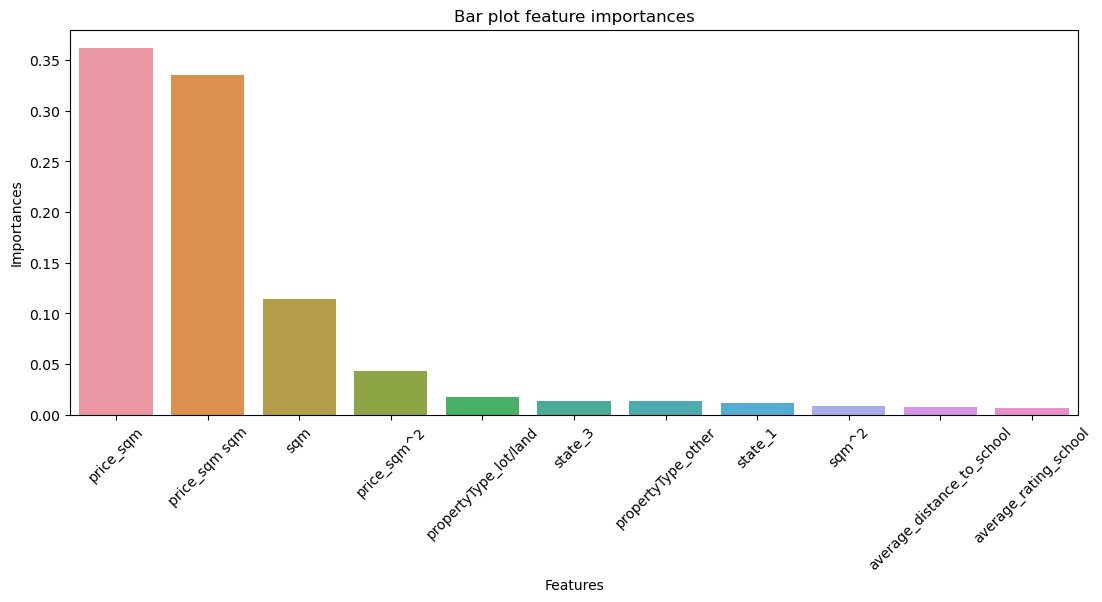

In [393]:
features_importance = pd.DataFrame(dt.feature_importances_, index=X_train_poly.columns).sort_values(by=0, ascending=False)[:11]
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_train_poly.columns #признаки
feature_importances = dt.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=features_importance.index, y=features_importance[0], ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')
ax.xaxis.set_tick_params(rotation=45);

## RandomForestRegressor

In [394]:
# Инициализируем алгоритм случайного леса (Randomforest) с подбором гиперпареметров
from sklearn import ensemble
param_grid = {
    'criterion': ['squared_error'], #['squared_error', 'friedman_mse', 'poisson'],
    'n_estimators': [50, 100], # [100, 200, 300, 400, 500],
    'max_depth': [10, 50, 100], # [10, 25, 50, 75, 100], # list(np.linspace(3, 100, 97, dtype=int)),
    'max_features': ['sqrt'], #['sqrt', 'log2'], # максимальное количество признаков, учитываемых алгоритмом при поиске лучшего разделения
    'min_samples_leaf': list(np.linspace(3, 30, 27, dtype=int))
}
random_forest = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),  # ensemble.RandomForestRegressor
    param_distributions=param_grid, 
    cv=5,
    n_iter = 10,
    n_jobs = -1
)

%time random_forest.fit(X_train_poly, y_train_log)

y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred = (np.exp(random_forest.predict(X_train_poly)) - 1)
y_test_pred = (np.exp(random_forest.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)
print("Наилучшие значения гиперпараметров: {}".format(random_forest.best_params_))
print("Наилучшая модель:\n{}".format(random_forest.best_estimator_))

CPU times: total: 1min
Wall time: 19min 35s
Train R^2: 0.919
Train MAE: 22721.540
Train MAPE: 5.871


Test R^2: 0.896
Test MAE: 29087.815
Test MAPE: 8.228
Наилучшие значения гиперпараметров: {'n_estimators': 50, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'squared_error'}
Наилучшая модель:
RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=3,
                      n_estimators=50, random_state=42)


In [395]:
# Наилучшие значения гиперпараметров: {'n_estimators': 50, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'squared_error'}
rf = RandomForestRegressor(criterion = 'squared_error', n_estimators = 50, max_depth = 50, max_features = 'sqrt', min_samples_leaf = 3, random_state=42)
%time rf.fit(X_train_poly, y_train_log)

y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred = (np.exp(rf.predict(X_train_poly)) - 1)
y_test_pred = (np.exp(rf.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: total: 1min 3s
Wall time: 1min 6s
Train R^2: 0.919
Train MAE: 22721.540
Train MAPE: 5.871


Test R^2: 0.896
Test MAE: 29087.815
Test MAPE: 8.228


Определим важность признаков с помощью случайного леса, обратившись к атрибуту feature_importances.

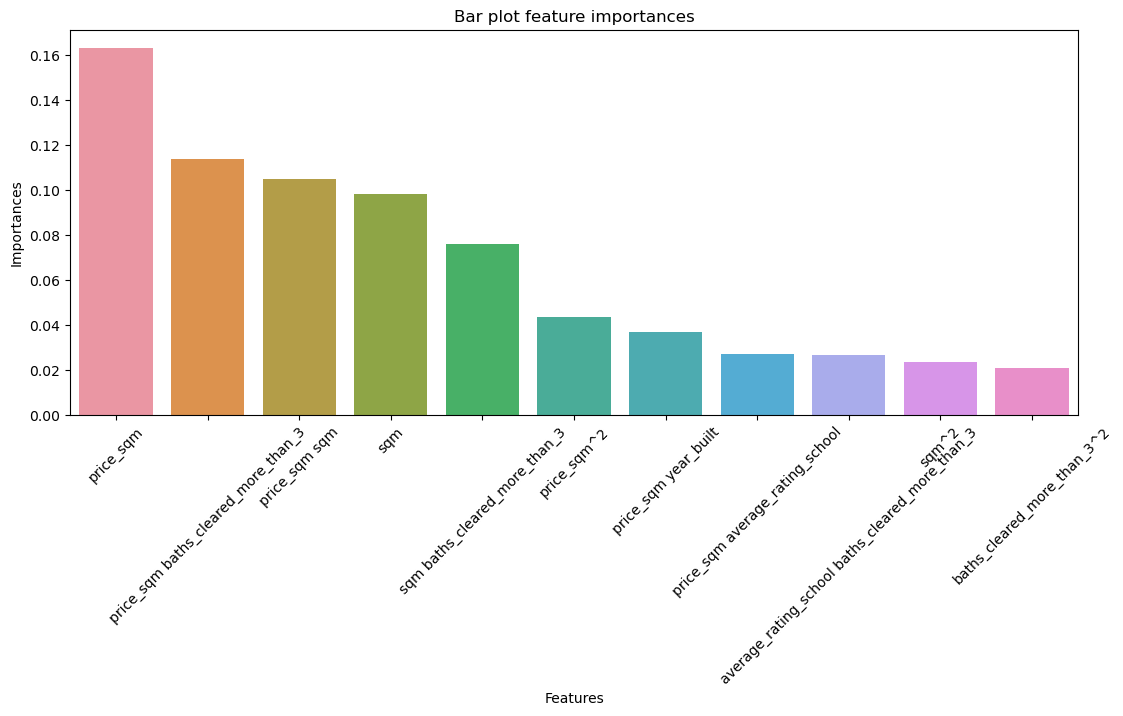

In [398]:
features_importance = pd.DataFrame(rf.feature_importances_, index=X_train_poly.columns).sort_values(by=0, ascending=False)[:11]
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_train_poly.columns #признаки
#Строим столбчатую диаграмму
sns.barplot(x=features_importance.index, y=features_importance[0], ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')
ax.xaxis.set_tick_params(rotation=45);

Проведем подбор гиперпараметров с помощью библиотеки Hyperopt

In [8]:
# зададим пространство поиска гиперпараметров
space={'criterion': hp.choice('criterion', ['squared_error']), # ['squared_error', 'friedman_mse', 'poisson']
       'n_estimators': hp.quniform('n_estimators', 400, 500, 100),
       'max_depth' : hp.quniform('max_depth', 29, 33, 1),
       'max_features': hp.choice('max_features', ['sqrt']), # ['sqrt', 'log2']
       'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1)
      }

In [9]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_poly, y=y_train_log, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'criterion': params['criterion'],
              'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']),
              'max_features': params['max_features'],
              'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestRegressor(**params, random_state=random_state)

    # обучаем модель
    # model.fit(X, y)
    # score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [10]:
%%time
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=2, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 2/2 [42:42<00:00, 1281.05s/trial, best loss: -0.8998735274497622]
Наилучшие значения гиперпараметров {'criterion': 0, 'max_depth': 33.0, 'max_features': 0, 'min_samples_leaf': 4.0, 'n_estimators': 400.0}
CPU times: total: 594 ms
Wall time: 42min 42s


In [11]:
# продолжим подбор гиперпараметров
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=3, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 3/3 [19:06<00:00, 1146.70s/trial, best loss: -0.8998735274497622]
Наилучшие значения гиперпараметров {'criterion': 0, 'max_depth': 33.0, 'max_features': 0, 'min_samples_leaf': 4.0, 'n_estimators': 400.0}


100%|██████████| 3/3 [55:07<00:00, 1102.37s/trial, best loss: -0.8998735274497622]
Наилучшие значения гиперпараметров {'criterion': 0, 'max_depth': 33.0, 'max_features': 0, 'min_samples_leaf': 4.0, 'n_estimators': 400.0}
CPU times: total: 1 s
Wall time: 55min 7s

In [12]:
# зададим пространство поиска гиперпараметров
space={'criterion': hp.choice('criterion', ['squared_error']), # ['squared_error', 'friedman_mse', 'poisson']
       'n_estimators': hp.quniform('n_estimators', 500, 550, 50),
       'max_depth' : hp.quniform('max_depth', 29, 33, 1),
       'max_features': hp.choice('max_features', ['sqrt']), # ['sqrt', 'log2']
       'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1)
      }

In [13]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_poly, y=y_train_log, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'criterion': params['criterion'],
              'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']),
              'max_features': params['max_features'],
              'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestRegressor(**params, random_state=random_state)

    # обучаем модель
    # model.fit(X, y)
    # score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [14]:
%%time
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=2, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 2/2 [39:56<00:00, 1198.09s/trial, best loss: -0.8998778699716257]
Наилучшие значения гиперпараметров {'criterion': 0, 'max_depth': 33.0, 'max_features': 0, 'min_samples_leaf': 4.0, 'n_estimators': 500.0}
CPU times: total: 562 ms
Wall time: 39min 56s


In [15]:
# продолжим подбор гиперпараметров
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=3, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 3/3 [21:16<00:00, 1276.92s/trial, best loss: -0.8998778699716257]
Наилучшие значения гиперпараметров {'criterion': 0, 'max_depth': 33.0, 'max_features': 0, 'min_samples_leaf': 4.0, 'n_estimators': 500.0}


In [16]:
best

{'criterion': 0,
 'max_depth': 33.0,
 'max_features': 0,
 'min_samples_leaf': 4.0,
 'n_estimators': 500.0}

In [19]:
# Наилучшие значения гиперпараметров: {'criterion': 0, 'max_depth': 33.0, 'max_features': 0, 'min_samples_leaf': 4.0, 'n_estimators': 500.0}
rf_b = RandomForestRegressor(criterion = 'squared_error', n_estimators = 500, max_depth = 33, max_features = 'sqrt', min_samples_leaf = 4, random_state=42)
%time rf_b.fit(X_train_poly, y_train_log)

y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred = (np.exp(rf_b.predict(X_train_poly)) - 1)
y_test_pred = (np.exp(rf_b.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: total: 10min 3s
Wall time: 11min 4s
Train R^2: 0.911
Train MAE: 23408.909
Train MAPE: 6.132


Test R^2: 0.893
Test MAE: 28527.724
Test MAPE: 8.107


In [20]:
rf = RandomForestRegressor(criterion = 'squared_error', n_estimators = 500, max_depth = 31, max_features = 'sqrt', min_samples_leaf = 1, random_state=42)
%time rf.fit(X_train_poly, y_train_log)

y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred = (np.exp(rf.predict(X_train_poly)) - 1)
y_test_pred = (np.exp(rf.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: total: 14min 20s
Wall time: 15min 47s
Train R^2: 0.959
Train MAE: 13574.807
Train MAPE: 3.076


Test R^2: 0.901
Test MAE: 25999.909
Test MAPE: 7.330


## GradientBoostingRegressor

Проведем подбор гиперпараметров с помощью библиотеки Optuna

In [21]:
# import optuna
print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 2.10.0


In [22]:
random_state = 42
def optuna_gb(trial, cv = 5, X = X_train_poly, y = y_train_log, random_state = random_state):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 900, 1000, 100)
  learning_rate = trial.suggest_float('learning_rate', 0.07, 0.1, step=0.01, log=False)
  max_depth = trial.suggest_int('max_depth', 7, 10, 1)
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5, 1)
  subsample = trial.suggest_float('subsample', 0.7, 1, step=0.1, log=False)

  # создаем модель
  model = GradientBoostingRegressor(n_estimators=n_estimators,
                                    learning_rate=learning_rate,
                                    max_depth=max_depth,
                                    max_features=max_features,
                                    min_samples_leaf=min_samples_leaf,
                                    subsample=subsample,
                                    random_state=random_state)
  # обучаем модель
  # model.fit(X, y)
  # score = metrics.r2_score(y_train, model.predict(X))
  score = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1).mean()

  return score

In [23]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_gb = optuna.create_study(study_name='GradientBoostingRegressor', direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_gb.optimize(optuna_gb, n_trials=3)

CPU times: total: 39.6 s
Wall time: 1h 7min 55s


In [25]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study_gb.optimize(optuna_gb, n_trials=1)

CPU times: total: 266 ms
Wall time: 20min 50s


In [27]:
study_gb.best_params

{'n_estimators': 900,
 'learning_rate': 0.07,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'subsample': 0.8999999999999999}

In [28]:
# рассчитаем точность для тестовой выборки
model_gb = GradientBoostingRegressor(**study_gb.best_params, random_state=random_state)
model_gb.fit(X_train_poly, y_train_log)

y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred_gb = (np.exp(model_gb.predict(X_train_poly)) - 1)
y_test_pred_gb = (np.exp(model_gb.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred_gb, y_test, y_test_pred_gb)
'''{'n_estimators': 900,
 'learning_rate': 0.07,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'subsample': 0.8999999999999999}'''

Train R^2: 0.959
Train MAE: 14949.423
Train MAPE: 3.721


Test R^2: 0.914
Test MAE: 27208.046
Test MAPE: 7.597


"{'n_estimators': 900,\n 'learning_rate': 0.07,\n 'max_depth': 10,\n 'max_features': 'sqrt',\n 'min_samples_leaf': 5,\n 'subsample': 0.8999999999999999}"

In [29]:
# рассчитаем точность для тестовой выборки
model_gb_ = GradientBoostingRegressor(n_estimators = 1000, 
                                     learning_rate = 0.1, 
                                     max_depth = 10, 
                                     max_features = 'sqrt', 
                                     min_samples_leaf = 4,
                                     subsample = 0.9, random_state=random_state)
model_gb_.fit(X_train_poly, y_train_log)

y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred_gb_ = (np.exp(model_gb_.predict(X_train_poly)) - 1)
y_test_pred_gb_ = (np.exp(model_gb_.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred_gb_, y_test, y_test_pred_gb_)

Train R^2: 0.968
Train MAE: 12189.854
Train MAPE: 2.939


Test R^2: 0.912
Test MAE: 28404.127
Test MAPE: 7.916


In [30]:
optuna.visualization.is_available()

True

График истории оптимизации

In [31]:
optuna.visualization.plot_optimization_history(study_gb, target_name="r2_score")

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [ ]:
optuna.visualization.plot_param_importances(study_gb, target_name="r2_score")

График контура отношений гиперпараметров

Он показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

Точки с белым фоном это и есть лучшии комбинации n_estimator, max_depth.

In [36]:
optuna.visualization.plot_contour(study_gb, params=["max_depth", "n_estimators"], target_name="r2_score")

## Extreme Gradient Boosting (XgBoost)

In [ ]:
#!pip install xgboost

     ---------------------------------------- 99.8/99.8 MB 3.0 MB/s eta 0:00:00


In [38]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_poly, label=y_train_log, feature_names = list(X_train_poly.columns)) # feature_names=best_features)
dvalid = xgb.DMatrix(X_test_poly, label=y_test_log, feature_names = list(X_test_poly.columns)) # feature_names=best_features)

In [39]:
%%time
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')] #[(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model_xgb = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=1000, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=100 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.65204	valid-rmse:0.65221
[100]	train-rmse:0.22339	valid-rmse:0.22716
[200]	train-rmse:0.20398	valid-rmse:0.21452
[300]	train-rmse:0.19330	valid-rmse:0.20941
[400]	train-rmse:0.18610	valid-rmse:0.20682
[500]	train-rmse:0.17963	valid-rmse:0.20485
[600]	train-rmse:0.17347	valid-rmse:0.20271
[700]	train-rmse:0.16857	valid-rmse:0.20145
[800]	train-rmse:0.16413	valid-rmse:0.20013
[900]	train-rmse:0.16024	valid-rmse:0.19925
[999]	train-rmse:0.15647	valid-rmse:0.19853
CPU times: total: 2min 56s
Wall time: 3min 5s


In [40]:
y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred_xgb = (np.exp(model_xgb.predict(dtrain)) - 1)
y_test_pred_xgb = (np.exp(model_xgb.predict(dvalid)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred_xgb, y_test, y_test_pred_xgb)

Train R^2: 0.934
Train MAE: 20583.465
Train MAPE: 5.561


Test R^2: 0.912
Test MAE: 24619.651
Test MAPE: 7.223


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

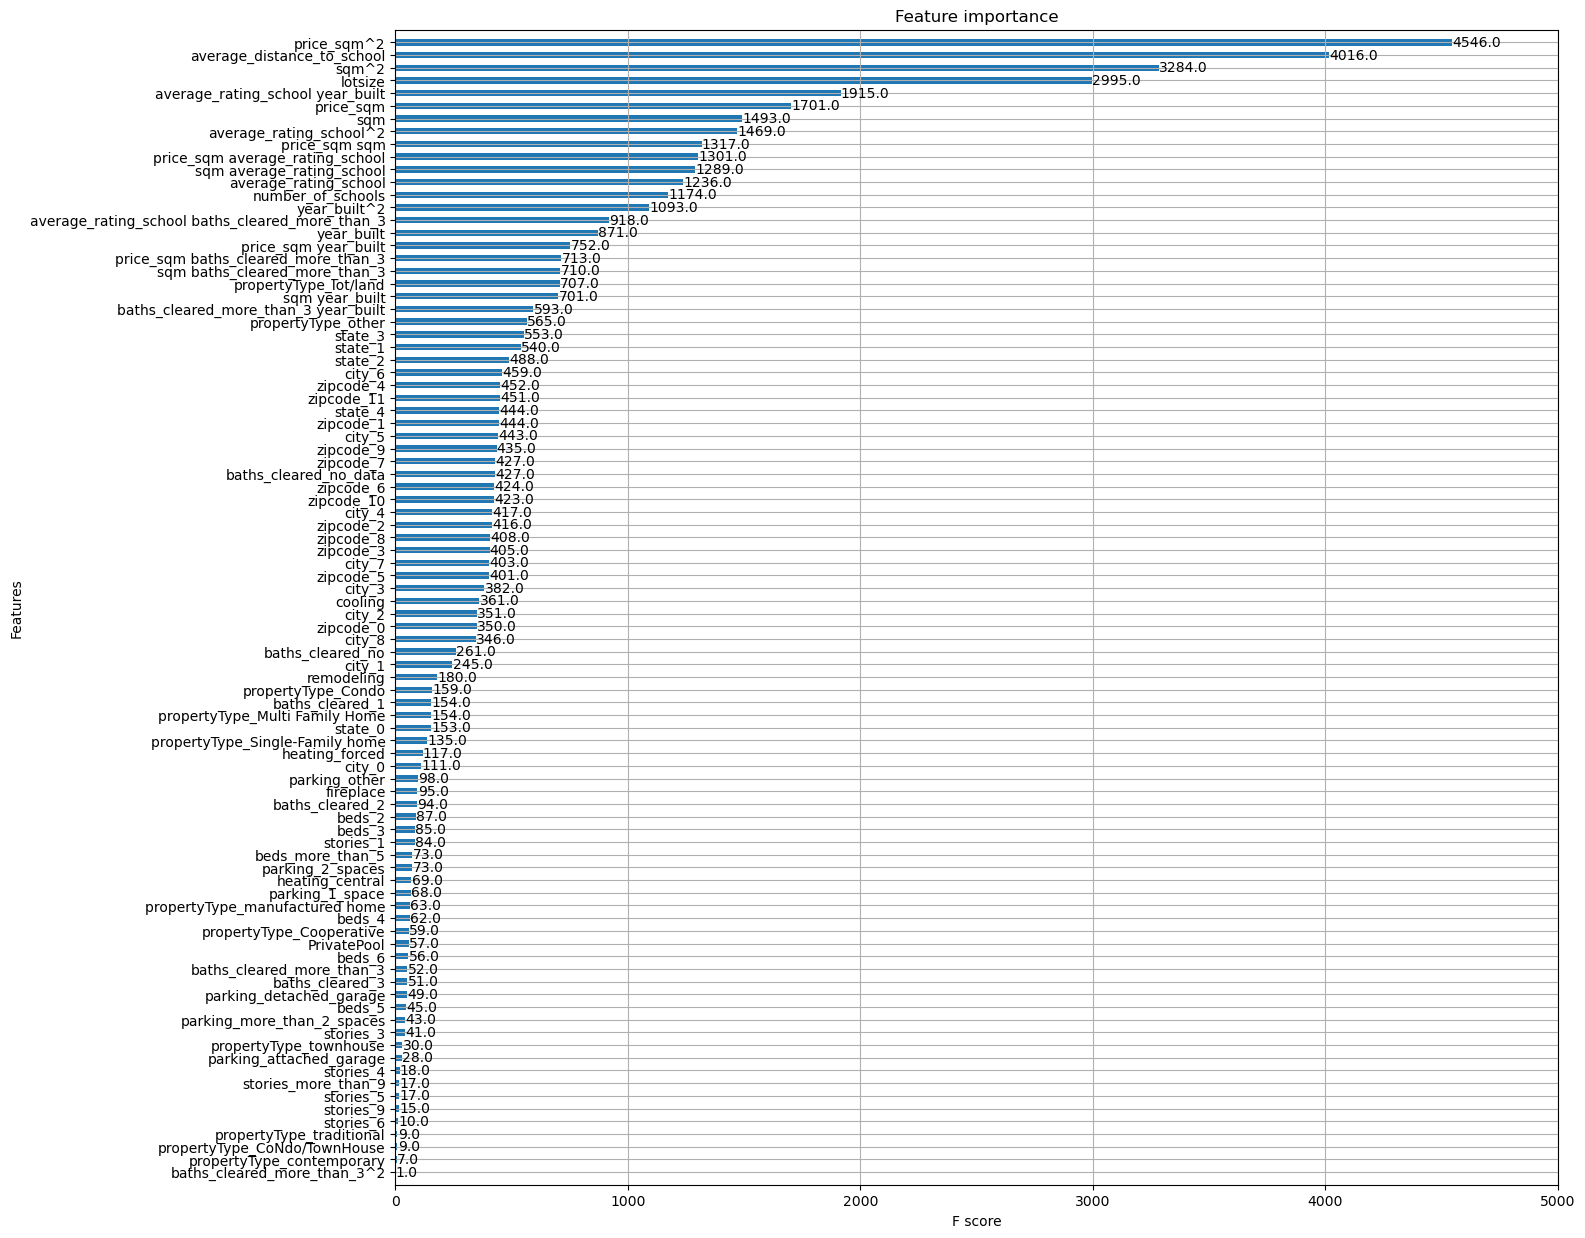

In [41]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model_xgb, ax = ax, height=0.5)

In [42]:
%%time
from xgboost import XGBRegressor
model_xgbs = XGBRegressor(
    min_child_weight = 20,
    learning_rate = 0.1, # eta
    colsample_bytree = 0.9,
    max_depth = 6,
    subsample = 0.9,
    reg_lambda = 1, # L2 regularization term on weights (xgb’s lambda), reg_alpha (Optional[float]) – L1 regularization term on weights (xgb’s alpha)
    n_jobs = -1, # 'nthread': -1,
    booster = 'gbtree',
    objective ='reg:squarederror',
    n_estimators = 1000,
    eval_metric ='rmse', # eval_metric=mean_absolute_error
    random_state = 42,
    early_stopping_rounds = 20
    )

model_xgbs.fit(X_train_poly, y_train_log, eval_set = [(X_train_poly, y_train_log)], verbose = 100)

[0]	validation_0-rmse:0.65204
[100]	validation_0-rmse:0.22311
[200]	validation_0-rmse:0.20402
[300]	validation_0-rmse:0.19347
[400]	validation_0-rmse:0.18591
[500]	validation_0-rmse:0.17920
[600]	validation_0-rmse:0.17339
[700]	validation_0-rmse:0.16825
[800]	validation_0-rmse:0.16339
[900]	validation_0-rmse:0.15922
[999]	validation_0-rmse:0.15583
CPU times: total: 2min 34s
Wall time: 3min 14s


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=20, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [43]:
y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred_xgbs_poly = (np.exp(model_xgbs.predict(X_train_poly)) - 1)
y_test_pred_xgbs_poly = (np.exp(model_xgbs.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred_xgbs_poly, y_test, y_test_pred_xgbs_poly)

Train R^2: 0.934
Train MAE: 20571.199
Train MAPE: 5.553


Test R^2: 0.913
Test MAE: 24590.533
Test MAPE: 7.213


## CatBoost

In [44]:
# Создание и обучение модели
model_catb = CatBoostRegressor(n_estimators=1000, learning_rate=0.1, max_depth=10, random_state = 42)
model_catb.fit(X_train_poly, y_train_log, verbose = 100)

# рассчитаем точность для тестовой выборки
y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred_catb_poly = (np.exp(model_catb.predict(X_train_poly)) - 1)
y_test_pred_catb_poly = (np.exp(model_catb.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred_catb_poly, y_test, y_test_pred_catb_poly)

0:	learn: 0.6522827	total: 774ms	remaining: 12m 52s
100:	learn: 0.2195222	total: 55.8s	remaining: 8m 16s
200:	learn: 0.1958058	total: 1m 55s	remaining: 7m 38s
300:	learn: 0.1825401	total: 2m 46s	remaining: 6m 26s
400:	learn: 0.1725972	total: 3m 42s	remaining: 5m 32s
500:	learn: 0.1648166	total: 4m 38s	remaining: 4m 37s
600:	learn: 0.1586929	total: 5m 31s	remaining: 3m 40s
700:	learn: 0.1541272	total: 6m 23s	remaining: 2m 43s
800:	learn: 0.1495470	total: 7m 17s	remaining: 1m 48s
900:	learn: 0.1447650	total: 8m 7s	remaining: 53.6s
999:	learn: 0.1410690	total: 8m 57s	remaining: 0us
Train R^2: 0.942
Train MAE: 18222.753
Train MAPE: 4.802


Test R^2: 0.916
Test MAE: 23191.093
Test MAPE: 6.700


## LightGBM

In [ ]:
# !pip install lightgbm

     ---------------------------------------- 1.3/1.3 MB 4.0 MB/s eta 0:00:00


In [45]:
%%time
# Создание и обучение модели
model_lgb = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.1, max_depth=10, random_state=42)
model_lgb.fit(X_train_poly, y_train_log)

# рассчитаем точность для тестовой выборки
y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred_lgb_poly = (np.exp(model_lgb.predict(X_train_poly)) - 1)
y_test_pred_lgb_poly = (np.exp(model_lgb.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred_lgb_poly, y_test, y_test_pred_lgb_poly)

Train R^2: 0.929
Train MAE: 21142.951
Train MAPE: 5.549


Test R^2: 0.909
Test MAE: 24765.941
Test MAPE: 7.103
CPU times: total: 1min 49s
Wall time: 2min 16s


## LightAutoML (LAMA) 

In [20]:
tr_data = pd.concat([X_train_poly, y_train_log], axis = 1)
te_data = pd.concat([X_test_poly, y_test_log], axis = 1)

# tr_data = pd.concat([X_train_poly, y_train_log.reset_index(drop = True)], axis = 1)
# te_pred = pd.concat([X_test_poly, y_test_log.reset_index(drop = True)], axis = 1)

In [21]:
tr_data.head(3)

,fireplace,PrivatePool,remodeling,year_built,cooling,lotsize,price_sqm,average_rating_school,number_of_schools,average_distance_to_school,...,sqm average_rating_school,sqm baths_cleared_more_than_3,sqm year_built,average_rating_school^2,average_rating_school baths_cleared_more_than_3,average_rating_school year_built,baths_cleared_more_than_3^2,baths_cleared_more_than_3 year_built,year_built^2,target
0,-0.646953,-0.34527,1.175484,0.498051,0.650505,-0.496299,-0.755127,-0.228224,0.823738,1.765496,...,-0.057026,-0.086002,0.124447,0.052086,0.078552,-0.113667,0.118466,-0.171423,0.248054,12.429220
1,-0.646953,-0.34527,1.175484,-0.856745,0.650505,-0.047055,-0.704873,0.559748,-0.403737,0.363943,...,-0.439143,0.270029,0.672148,0.313318,-0.192659,-0.479562,0.118466,0.294882,0.734012,12.013101
2,-0.646953,-0.34527,-0.850714,0.704130,0.650505,-0.078537,2.054486,-0.172509,0.271792,-0.372036,...,0.295691,0.589958,-1.206917,0.029760,0.059376,-0.121469,0.118466,-0.242354,0.495800,13.005832


In [22]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 600 # equal to 10 minutes
TARGET_NAME = 'target'

In [23]:
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [24]:
task = Task('reg', loss = 'mse', metric = 'mae')

In [25]:
roles = {
    'target': TARGET_NAME
}

In [26]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [27]:
tr_data.isnull().mean().sum()

0.0

In [28]:
%%time 
automl.fit_predict(tr_data, roles = roles, verbose = 1)

[00:02:16] Stdout logging level is INFO.
[00:02:16] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[00:02:16] Task: reg

[00:02:16] Start automl preset with listed constraints:
[00:02:16] - time: 600.00 seconds
[00:02:16] - CPU: 4 cores
[00:02:16] - memory: 16 GB

[00:02:16] Train data shape: (193168, 93)

[00:02:46] Layer 1 train process start. Time left 569.85 secs
[00:03:14] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[00:03:32] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.1402927539221467
[00:03:32] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[00:03:32] Time left 524.60 secs

[00:04:35] Selector_LightGBM fitting and predicting completed
[00:05:03] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[00:06:35] Time limit exceeded after calculating fold 0

[00:06:35] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.06868712996900474
[00:06:35] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting comple

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

In [29]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.89921 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.10079 * (1 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 


In [30]:
%%time
tr_pred = automl.predict(tr_data)
te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{tr_pred}\nShape = {tr_pred.shape}')
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[12.445195 ],
       [12.013279 ],
       [12.982768 ],
       ...,
       [12.941301 ],
       [12.603321 ],
       [12.2005415]], dtype=float32)
Shape = (193168, 1)
Prediction for te_data:
array([[12.560707],
       [12.568241],
       [11.815434],
       ...,
       [11.579385],
       [12.97233 ],
       [12.876494]], dtype=float32)
Shape = (48293, 1)
CPU times: total: 2min 43s
Wall time: 1min 1s


In [31]:
# рассчитаем точность для тестовой выборки
y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

tr_pred_exp = (np.exp(tr_pred.data[:, 0]) - 1)
te_pred_exp = (np.exp(te_pred.data[:, 0]) - 1)
#Выводим результирующие метрики
print_metrics(y_train, tr_pred_exp, y_test, te_pred_exp)

Train R^2: 0.919
Train MAE: 21438.173
Train MAPE: 5.557


Test R^2: 0.900
Test MAE: 24576.836
Test MAPE: 7.057


CPU times: total: 641 ms
Wall time: 674 ms


<Axes: xlabel='Feature'>

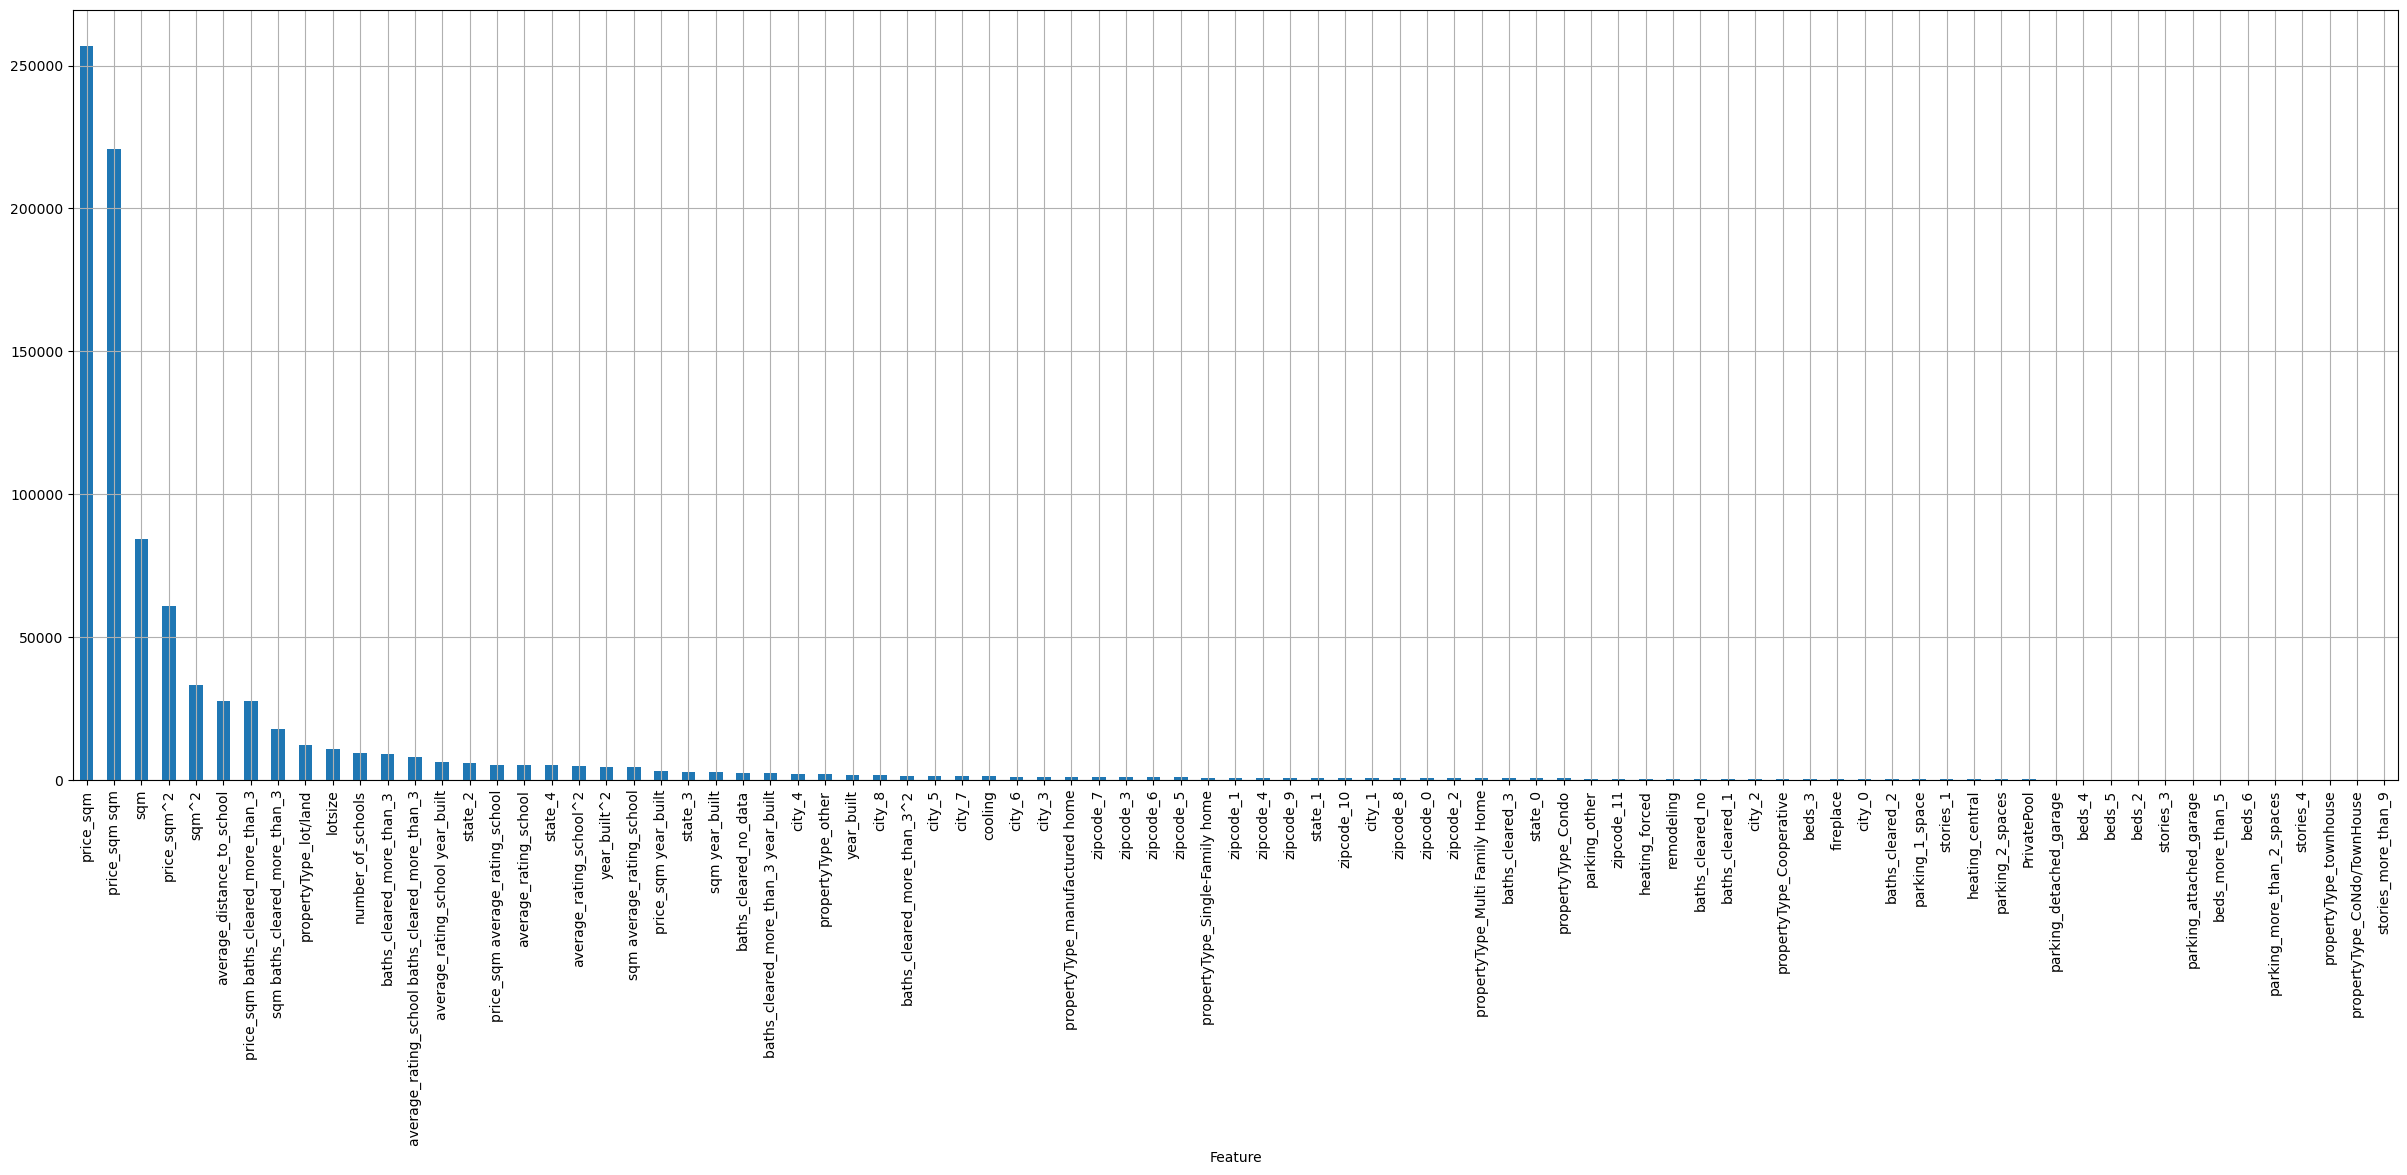

In [33]:
%%time
# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

#### Агрегируем и оценим полученные разультаты качества на обученных моделях

**LinearRegression**
- Test R^2: 0.809
- Test MAE: 50350.921
- Test MAPE: 16.044 %

**SGDRegressor**

SGDRegressor(max_iter=10000, eta0=0.01, penalty='l1', alpha=0.01, random_state=42)
- Test R^2: 0.807
- Test MAE: 44210.784
- Test MAPE: 14.863 %

**Lasso**

Lasso(alpha=0.01)
- Test R^2: 0.807
- Test MAE: 44850.977
- Test MAPE: 15.018 %

**Ridge**

Ridge(alpha=1)
- Test R^2: 0.809
- Test MAE: 50350.921
- Test MAPE: 16.044 %

**DecisionTreeRegressor**

DecisionTreeRegressor(criterion = 'squared_error', max_depth = 25, min_samples_leaf = 16, random_state=42)
- Test R^2: 0.889
- Test MAE: 26842.421
- Test MAPE: 8.713 %

**RandomForestRegressor**

RandomForestRegressor(criterion = 'squared_error', n_estimators = 500, max_depth = 31, max_features = 'sqrt', min_samples_leaf = 1, random_state=42)
- Test R^2: 0.901
- Test MAE: 25999.909
- Test MAPE: 7.330 %

**GradientBoostingRegressor**

GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.1, max_depth = 10, max_features = 'sqrt', min_samples_leaf = 4, subsample = 0.9, random_state=random_state)
- Test R^2: 0.912
- Test MAE: 28404.127
- Test MAPE: 7.916

**XGBRegressor**

XGBRegressor(min_child_weight = 20, learning_rate = 0.1, colsample_bytree = 0.9, max_depth = 6, subsample = 0.9, reg_lambda = 1, n_jobs = -1,
booster = 'gbtree', objective ='reg:squarederror', n_estimators = 1000, eval_metric ='rmse', random_state = 42, early_stopping_rounds = 20)
- Test R^2: 0.913
- Test MAE: 24590.533
- Test MAPE: 7.213 %

**CatBoostRegressor**

CatBoostRegressor(n_estimators=1000, learning_rate=0.1, max_depth=10, random_state = 42)
- Test R^2: 0.916
- Test MAE: 23191.093
- Test MAPE: 6.700 %

**LGBMRegressor**

LGBMRegressor(n_estimators=1000, learning_rate=0.1, max_depth=10, random_state=42)
- Test R^2: 0.909
- Test MAE: 24765.941
- Test MAPE: 7.103 %

**LightAutoML (LAMA)**
- Test R^2: 0.900
- Test MAE: 24576.836
- Test MAPE: 7.057 %

**Вывод:**

Таким образом лучшее качество показал алгоритм **CatBoostRegressor: Test R^2: 0.916, Test MAE: 23191, Test MAPE: 6.7 %**.


In [8]:
# Создание и обучение модели
model_catb = CatBoostRegressor(n_estimators=1000, learning_rate=0.1, max_depth=10, random_state = 42)
model_catb.fit(X_train_poly, y_train_log, verbose = 100)

# рассчитаем точность для тестовой выборки
y_train = (np.exp(y_train_log) - 1)
y_test = (np.exp(y_test_log) - 1)

y_train_pred_catb_poly = (np.exp(model_catb.predict(X_train_poly)) - 1)
y_test_pred_catb_poly = (np.exp(model_catb.predict(X_test_poly)) - 1)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred_catb_poly, y_test, y_test_pred_catb_poly)

0:	learn: 0.6522827	total: 425ms	remaining: 7m 4s
100:	learn: 0.2195222	total: 26.9s	remaining: 3m 59s
200:	learn: 0.1958058	total: 53.1s	remaining: 3m 31s
300:	learn: 0.1825401	total: 1m 19s	remaining: 3m 3s
400:	learn: 0.1725972	total: 1m 44s	remaining: 2m 36s
500:	learn: 0.1648166	total: 2m 11s	remaining: 2m 11s
600:	learn: 0.1586929	total: 2m 37s	remaining: 1m 44s
700:	learn: 0.1541272	total: 3m 3s	remaining: 1m 18s
800:	learn: 0.1495470	total: 3m 31s	remaining: 52.6s
900:	learn: 0.1447650	total: 3m 57s	remaining: 26.1s
999:	learn: 0.1410690	total: 4m 24s	remaining: 0us
Train R^2: 0.942
Train MAE: 18222.753
Train MAPE: 4.802


Test R^2: 0.916
Test MAE: 23191.093
Test MAPE: 6.700


### <center>3. Деплой модели

В целях разработки небольшого веб-сервиса для прогнозирования стоимости выставленной на продажу недвижимости сериализуем необходимые для этого данные и запишем результаты в файлы.

In [11]:
# добавляем поле "obj_id" чтобы в дальнейшем идентифицировать объект
X_test_depl = X_test_poly.copy()
X_test_depl['obj_id'] = list(range(X_test_depl.shape[0]))

In [12]:
MODEL_FILE = 'best_model.pkl'
FEATURE_ORDER_FILE = 'feature_order.pkl'
TEST_DATA_FILE = 'test_data.pkl'

In [13]:
# Производим сериализацию модели и записываем результат в файл MODEL_FILE формата pkl
with open(MODEL_FILE, 'wb') as output:
    pickle.dump(model_catb, output)

# Производим сериализацию тестовых данных и записываем результат в файл TEST_DATA_FILE формата pkl
with open(TEST_DATA_FILE, 'wb') as output:
    pickle.dump(X_test_depl, output)

feature_order = X_test_depl.columns.tolist()
feature_order.remove('obj_id')
# Производим сериализацию feature_order и записываем результат в файл FEATURE_ORDER_FILE формата pkl
with open(FEATURE_ORDER_FILE, 'wb') as output:
    pickle.dump(feature_order, output)

Осуществим деплой модели на веб-сервис в файле server_dip.py